# Team WarwiQC
# AI-Assisted QAOA for Mean-Variance Minimisation in Portfolio Optimisation  

---

## Contents


1. [Imports](#imports)
2. [Data](#data)
3. [Quantum Approximate Optimization Algorithm (QAOA)](#quantum-approximate-optimization-algorithm-qaoa)
    1. [Mean–variance objective function](#meanvariance-objective-function)
    2. [One-Hot encoding and constraints](#one-hot-encoding-and-constraints)
    3. [Quadratic Penalties](#quadratic-penalties)
        1. [One-hot (per asset)](#one-hot-per-asset)
        2. [Portfolio budget](#portfolio-budget)
        3. [Linear biases](#linear-biases)
        4. [Quadratic coupling](#quadratic-coupling)
    4. [Ising form (for QAOA)](#ising-form-for-qaoa)
    5. [Post-processing](#post-processing)
    6. [Concept Recap](#concept-recap)
    7. [Measuring the final state](#measuring-the-final-state)
    8. [Selecting the Final Portfolio](#selecting-the-final-portfolio)
    9. [Final pipeline](#final-pipeline)
    10. [Stable Final Weights via Pooled Counts](#stable-final-weights-via-pooled-counts)
        1. [Purpose](#purpose)
        2. [Functions](#functions)
    11. [Why pool counts?](#why-pool-counts)
4. [Optimising $\beta$ and $\gamma$](#optimising-beta-and-gamma)
    1. [Bayesian Optimisation (BO)](#bayesian-optimisation-bo)
        1. [Bayesian Optimization for QAOA (Periodic Parameters)](#bayesian-optimization-for-qaoa-periodic-parameters)
    2. [Overview of Reinforcement Learning (RL)](#overview-of-reinforcement-learning-rl)
    3. [The REINFORCE Algorithm (Monte Carlo Policy Gradient)](#the-reinforce-algorithm-monte-carlo-policy-gradient)
        1. [Limitations of REINFORCE for QAOA Parameter Optimization](#limitations-of-reinforce-for-qaoa-parameter-optimization)
        2. [Next Steps: Moving to A2C](#next-steps-moving-to-a2c)
        3. [When A2C Fails to Update the Policy](#when-a2c-fails-to-update-the-policy)
        4. [Enter Proximal Policy Optimization (PPO)](#enter-proximal-policy-optimization-ppo)
        5. [Comparison of Optimization Approaches for QAOA](#comparison-of-optimization-approaches-for-qaoa)
5. [Testing our best optimisers on real data](#testing-our-best-optimisers-on-real-data)
    1. [Baseline models](#baseline-models)
        1. [Baseline Method 1 - COBYLA (Constrained Optimization BY Linear Approximations)](#baseline-method-1---cobyla-constrained-optimization-by-linear-approximations)
        2. [Baseline Method 2 -L-BFGS-B (Limited-memory Broyden–Fletcher–Goldfarb–Shanno – Bound constrained)](#baseline-method-2--l-bfgs-b-limited-memory-broydenfletchergoldfarbshanno--bound-constrained)
        3. [Nelder–Mead (Simplex Optimization)](#neldermead-simplex-optimization)
        4. [Baseline Comparison](#baseline-comparison)
    2. [Bayesian Optimisation](#bayesian-optimisation)
    3. [PPO](#ppo)
    4. [Comparing Search Space of all methods](#plot-spaces)
6. [Testing on 10 buckets](#testing-on-10-buckets)
    1. [Running in hardware](#running-in-hardware)
7. [Testing weights on future data](#testing-weights-on-future-data)

---

This project applies the Quantum Approximate Optimisation Algorithm (QAOA) to financial portfolio optimisation, targeting **mean–variance ratio maximisation** as the measure of performance. Using historical stock price data, we compute expected returns and the covariance matrix, then encode portfolio allocation as a QUBO with one-hot constraints (each asset can take discrete weight levels, and the budget must sum to 1).

The QUBO is mapped into an Ising Hamiltonian and solved using QAOA in Qiskit. Bitstrings sampled from the quantum circuit are decoded into portfolio weights and scored by their mean–variance ratio. Penalty terms are introduced to enforce one-hot and budget constraints, while Bayesian optimisation and Reinforcement Learning techniques are used to tune QAOA parameters $(\beta, \gamma)$

For small instances, we aim to validate results against brute-force solutions, showing that QAOA can find near-optimal mean–variance portfolios. This demonstrates a hybrid quantum–classical workflow, where quantum circuits explore the combinatorial search space and classical AI refines parameters, offering a path towards scalable quantum-enhanced finance.

---
## Imports

In [1]:
# --- Setup: install any missing packages once ---
import sys, subprocess

def ensure(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg])

for p in [
    "qiskit[visualization]",
    "qiskit-aer",
    "qiskit-ibm-runtime",
    "typing_extensions>=4.12",
    "torch",
    "scikit-optimize",
    "matplotlib",
    "numpy",
    "pandas",
    "scipy",
    "psycopg2"
]:
    ensure(p)

In [55]:
import qiskit
print("Qiskit version:", qiskit.__version__)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import LinearSegmentedColormap
import os, psycopg2, json, time 
from collections import deque, Counter
from datetime import datetime

from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective
from skopt.learning import GaussianProcessRegressor as SkoptGP
from skopt.learning.gaussian_process.kernels import RBF, ConstantKernel, ExpSineSquared

from scipy.optimize import minimize
from scipy.stats import norm

import torch
import torch.nn as nn, torch.optim as optim
import torch.distributions as D
from torch.distributions import Normal, VonMises

from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_vector, plot_histogram
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.result import QuasiDistribution
from qiskit.quantum_info import SparsePauliOp

from qiskit_aer import Aer

from qiskit_ibm_runtime import Estimator, Options
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler, Options
from qiskit_ibm_runtime import SamplerV2 as Sampler

Qiskit version: 2.2.2


## Load IBM Quantum Account

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

try:
    # Load your IBM Quantum account (run once with your token)
    QiskitRuntimeService.save_account(channel="ibm_cloud", token="", instance="", overwrite=True)
    service = QiskitRuntimeService()
    
    # List available backends
    print("✅ IBM Quantum account loaded successfully.")
    print("Available backends:")
    print(service.backends())

except Exception as e:
    print("Could not load IBM Quantum account.")
    print("Error:", e)
    print("\n👉 Please check if your account is set up correctly:")
    print("1. Log in at https://quantum-computing.ibm.com/")
    print("2. Copy your API token from Account settings.")
    print("3. Replace YOUR_API_TOKEN above with your actual token.")
    print("4. Re-run this cell.")

✅ IBM Quantum account loaded successfully.
Available backends:
[<IBMBackend('ibm_brussels')>, <IBMBackend('ibm_aachen')>, <IBMBackend('ibm_strasbourg')>]


---
## Data

The data we will use is sourced from Kaggle: https://www.kaggle.com/datasets/prodzar/stocks-historical-price-data
and can be found in the NayaOne Sandpit here: https://cityoflondon.nayaone.com/datasets/920/description

The data contains stock data from 13 different companies over 2 years. We will focus on 3 of the stocks: AAPL (Apple), TSLA (Tesla), and NVDA (Nvidia).
Before implementing our stocks into QAOA, we first must load and clean our data. We will then create a dataset of the log returns for each company for use within the Mean-Variance calculation, and get some basic statistics such as the covariance matrix and expected log returns.

### Load data

In [4]:
def newCursor():
    try:
        connection = psycopg2.connect(user = os.environ["DB_USER"],
                                      host = os.environ["DB_HOST"],
                                      password = os.environ["DB_PASSWORD"],
                                      port = "5432",
                                      database = os.environ["DB_DATABASE"])
        cursor = connection.cursor()
        return cursor
    
    except (Exception, psycopg2.Error) as error:
        print("Error while connected to PostgreSQL", error)
        return error

In [5]:
print(os.environ["DB_USER"])

col_prod_jupyter_user


In [6]:
c = newCursor()
q = """
SELECT *
FROM api."stocks_yahoo_finance"
"""
c.execute(q)
cols = [desc[0] for desc in c.description]
df = pd.DataFrame(c.fetchall(), columns=cols)
df.head()

Stock        Date               Open                High  \
0  ADBE  2019-05-31  271.2799987792969   272.9100036621094   
1  ADBE  2019-06-03   270.510009765625  272.80999755859375   
2  ADBE  2019-06-04  263.2699890136719  268.92999267578125   
3  ADBE  2019-06-05  272.7799987792969   273.2099914550781   
4  ADBE  2019-06-06  273.7200012207031    275.760009765625   

                  Low               Close   Volume Dividends Stock Splits  
0              268.75   270.8999938964844  2526600       0.0          0.0  
1   257.5299987792969   259.0299987792969  3903400       0.0          0.0  
2   257.4599914550781   268.7099914550781  3750800       0.0          0.0  
3   268.3900146484375   272.8599853515625  2650400       0.0          0.0  
4  271.04998779296875  274.79998779296875  2211800       0.0          0.0

### Clean Data
As can be seen on the NayaOne platform, the data is already clean. There are no missing values and all trading dates are in the data as expected. The only thing to do is convert numerical data to the right type so calculations of rows and columns are able to work. Afterwards, we will move to creating log returns.

In [7]:
print(df.dtypes)

Stock           object
Date            object
Open            object
High            object
Low             object
Close           object
Volume          object
Dividends       object
Stock Splits    object
dtype: object


In [8]:
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [9]:
# Isolate the three desired stocks
apple = df[df['Stock'] == 'AAPL']
tesla = df[df['Stock'] == 'TSLA']
nvidia = df[df['Stock'] == 'NVDA']

In [10]:
# Sort by date
apple = apple.sort_values("Date").reset_index(drop=True)
tesla = tesla.sort_values("Date").reset_index(drop=True)
nvidia = nvidia.sort_values("Date").reset_index(drop=True)

In [11]:
# Check if length seems correct
print(apple.shape)
print(tesla.shape)
print(nvidia.shape)

(526, 9)
(526, 9)
(526, 9)


In [12]:
# See if data looks as expected
apple.head(10)

Stock        Date       Open       High        Low      Close       Volume  \
0  AAPL  2019-05-31  43.181805  43.613062  42.877969  42.897572  108174400.0   
1  AAPL  2019-06-03  43.027439  43.595909  41.721424  42.463867  161584400.0   
2  AAPL  2019-06-04  42.988224  44.063910  42.762796  44.017353  123872000.0   
3  AAPL  2019-06-05  45.154295  45.328268  44.384898  44.727940  119093600.0   
4  AAPL  2019-06-06  44.860258  45.445882  44.632378  45.384624   90105200.0   
5  AAPL  2019-06-07  45.700720  47.026338  45.519399  46.592632  122737600.0   
6  AAPL  2019-06-10  46.999386  47.871695  46.952829  47.188061  104883600.0   
7  AAPL  2019-06-11  47.746726  48.026062  47.437989  47.734474  107731600.0   
8  AAPL  2019-06-12  47.523745  48.018709  47.386528  47.582554   73012800.0   
9  AAPL  2019-06-13  47.707525  48.219639  47.437994  47.572758   86698400.0   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  
5        0.0           0.0  
6        0.0           0.0  
7        0.0           0.0  
8        0.0           0.0  
9        0.0           0.0

### Create Log Returns data

In [13]:
# Function to create log returns column
def compute_log_returns(df, ticker):
    df = df.copy()
    df = df.drop(columns=df.columns[0]) # Drop first column - ticker
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    return df[["Date", "log_return"]].assign(Ticker=ticker)

In [14]:
# Apply to each stock
apple_ret = compute_log_returns(apple, "AAPL")
tesla_ret = compute_log_returns(tesla, "TSLA")
nvidia_ret = compute_log_returns(nvidia, "NVDA")

# Sanity check on Apple data
apple_ret.head(10)

Date  log_return Ticker
0  2019-05-31         NaN   AAPL
1  2019-06-03   -0.010162   AAPL
2  2019-06-04    0.035930   AAPL
3  2019-06-05    0.016014   AAPL
4  2019-06-06    0.014575   AAPL
5  2019-06-07    0.026269   AAPL
6  2019-06-10    0.012698   AAPL
7  2019-06-11    0.011513   AAPL
8  2019-06-12   -0.003188   AAPL
9  2019-06-13   -0.000206   AAPL

Now that we have the log returns data, we combine these into one df and also remove the first row as it will always be NaN since there is no date before the first date in the data.

In [15]:
returns = pd.concat([apple_ret, tesla_ret, nvidia_ret], ignore_index=True)

#  (Date as index, Tickers as columns)
returns_wide = returns.pivot(index="Date", columns="Ticker", values="log_return")

returns_wide.head()

Ticker          AAPL      NVDA      TSLA
Date                                    
2019-05-31       NaN       NaN       NaN
2019-06-03 -0.010162 -0.012480 -0.034002
2019-06-04  0.035930  0.066648  0.078576
2019-06-05  0.016014 -0.012101  0.015326
2019-06-06  0.014575  0.017541  0.046513

In [16]:
# Double check there is only one NaN row
print(returns_wide['AAPL'].isna().sum())
print(returns_wide['NVDA'].isna().sum())
print(returns_wide['TSLA'].isna().sum())

1
1
1


In [17]:
# Drop first row and save df as a csv for easy access
returns_wide = returns_wide.dropna(how="any")

returns_wide.to_csv('data/returns.csv')

### Mean and Covariance Matrix

Finally, we need to find the mean and covariance matrix

In [18]:
# Set constant of no. trading days per year
TRADING_DAYS = 252

In [19]:
# Expected daily and annual returns
mu_daily = returns_wide.mean()
mu_annual = mu_daily * TRADING_DAYS

print(f"Daily expected returns: {mu_daily}")
print("\n")
print(f"Annualised expected returns: {mu_annual}")

Daily expected returns: Ticker
AAPL    0.002208
NVDA    0.003390
TSLA    0.005543
dtype: float64


Annualised expected returns: Ticker
AAPL    0.556501
NVDA    0.854405
TSLA    1.396737
dtype: float64


In [20]:
# Covariance (daily and annual)
sigma_daily = returns_wide.cov()
sigma_annual = sigma_daily * TRADING_DAYS

print(f"Daily covariance matrix: {sigma_daily}")
print("\n")
print(f"Annualised covariance matrix: {sigma_annual}")

Daily covariance matrix: Ticker      AAPL      NVDA      TSLA
Ticker                              
AAPL    0.000545  0.000532  0.000525
NVDA    0.000532  0.000966  0.000731
TSLA    0.000525  0.000731  0.002138


Annualised covariance matrix: Ticker      AAPL      NVDA      TSLA
Ticker                              
AAPL    0.137356  0.134083  0.132393
NVDA    0.134083  0.243459  0.184126
TSLA    0.132393  0.184126  0.538843


---
# Quantum Approximate Optimization Algorithm (QAOA)
## Mean–variance objective function

Let $N\in\mathbb{N}$ be the number of assets. The objective we minimise (after adding penalty terms for constraints in the QUBO) is

$$
f(w)= w^\top \mu - \lambda w^\top \Sigma w - r_f\mathbf{1}^\top w + \text{(penalties)} ,
$$

where the variables and data have the following dimensions:

- $w \in \mathbb{R}^{N}$: portfolio weights (typically $w_i\ge 0$, $\mathbf{1}^\top w = 1$).
- $\mu \in \mathbb{R}^{N}$: expected returns (per the chosen period).
- $\Sigma \in \mathbb{R}^{N\times N}$: covariance matrix of returns (symmetric, PSD).
- $\mathbf{1} \in \mathbb{R}^{N}$: vector of ones.
- $r_f \in \mathbb{R}$: risk-free rate (same period as $\mu$)
- $\lambda \in \mathbb{R}_{\ge 0}$: risk-aversion (trade-off) parameter
- $f:\mathbb{R}^{N}\to\mathbb{R}$: scalar objective value.

The linear term $w^\top\mu$ is the portfolio's **expected return**, while the quadratic term $\lambda w^\top\Sigma w$ is the **risk penalty** and proportional to portfolio variance. $\lambda$ controls the return-risk trade-off.

If the portfolio is **fully invested**, $\mathbf{1}^\top w = 1$, so the term $r_f\mathbf{1}^\top w = r_f$ is a constant and can be **dropped** without changing the argmin when converting to QUBO.

Additional constraints arise from the choice of encoding and the portfolio budget.

## One-Hot encoding and constraints

One-hot encoding means each asset's weight is chosen from a small, discrete set of allowed levels ("buckets"). Pick a bucket grid
$v=(v_1,\dots,v_M)\in[0,1]^M$.

For each asset $i$ you introduce $M$ binary decision variables $(x_{i,1},\dots,x_{i,M})$ with
$x_{i,m}\in\{0,1\}$ and the **one-hot constraint**:

$$
\sum_{m=1}^{M} x_{i,m}=1
$$.



Setting $x_{i,m}=1$ ensures asset $i$ takes weight $v_m$, and all other $x_{i,n}=0$ for $n\neq m$. The portfolio weight materialises as

$$
w_i=\sum_{m} v_m\,x_{i,m}
$$

We also need to consider the **portfolio budget constraint**. If we want the portfolio to be **fully invested** then the sum of the weights $w_i$ must be equal to unity and

$$
\sum_i \sum_mv_mx_{i,m} = 1
$$ 

must be enforced.

## Quadratic Penalties

Both the One-hot and portfolio budget constraints can be reflected in the objective as **quadratic penalties** added to the energy we minimise. 

### One-hot (per asset)

For each asset $i$ enforce the "pick exactly one bucket" constraint:

$$
P_{1\, hot}(x) = \alpha \sum_i(\sum_mx_{i,m}-1)^2
$$

- $\alpha >0$ is the **penalty strength** (a lagrange-like weight). It sets how hard the optimisation pushes each asset to satisfy the one-hot rule. Larger $\alpha$ prioritises feasibility (exactly one bucket "on") over improving the mean-variance objective; too small $\alpha$ can allow violations.

- The penalty is $0$ when exactly one bucket is chosen - **the minimum**

### Portfolio budget
Enforce the portfolio budget constraint using the following penalty:

$$
P_{budget}(x) = \beta(\sum_i\sum_mv_mx_{i,m}-1)^2
$$

- $\beta>0$ controls how strongly the optimiser enforces the portfolio budget relative to the mean-variance objective. Larger $\beta$ discourages any deviation of the total weight from the target (here, $1$).

 ## QUBO form

Negating the mean-variance objective and adding the quadratic penalties yields the function we wish to minimise:

$$
E(x) = -\sum_{i,m}\mu_iv_mx_{i,m} + \lambda\sum_{i,j}\sum_{m,n}
v_mv_n\Sigma_{ij}x_{i,m}x_{j,n} + \alpha\sum_i(\sum_mx_{i,m}-1)^2 + \beta(\sum_{i,m}v_mx_{i,m}-1)^2
$$

In order to encode the QUBO into the cost hamiltonian $H_c$, it is first necessary to recast the function into a linear and quadratic term:

$$
E(x) = const + h^\top x +x^\top Jx
$$
Recall we are considering a portfolio with $N$ assets and $M$ "buckets" to distribute the weights.

### Linear biases

 $h \in \mathbb{R}^{NM}\,$ is the **vector of linear biases** (one entry per binary $x_{i,m}$)

Equivalently, $h = [h_{1,1}, \dots, h_{1,M}, h_{2,1}, \dots, h_{N,M}]^\top$ and the term expands as: 

$$
h^\top x = \sum_{i=1}^N\sum_{m=1}^Mh_{i,m}x_{i,m}
$$

### Quadratic coupling

 $J \in \mathbb{R}^{NM \times NM}$ is the **quadratic coupling matrix** between binary variables. 

Indexing $p \equiv (i,m)$ and $q\equiv (j,n)$ the quadratic term expands as:

$$
x^\top Jx = \sum_{p < q}J_{pq}x_px_q 
$$

with $J$ symmetric and $J_{pp} = 0$. So $J_{(i,m),(j,n)}$ is the weight on the pair $x_{(i,m)}x_{(j,n)}$.

For this portfolio the linear biases vector and quadratic coupling matrix is:


$$
h_{i,m} = -\mu_i v_m + \lambda v_m^{2}\Sigma_{ii} - \alpha + \beta(v_m^{2}-2v_m)
$$

$$
J_{(i,m),(j,n)}=2\lambda\Sigma_{ij}v_m v_n+2\beta v_m v_n+2\alpha\mathbf{1}\{i=j,m\neq n\},\ (i,m)\neq(j,n).
$$


## Ising form (for QAOA)

The **Ising form** rewrites a binary optimisation problem in terms of spin variables or Pauli-$Z$ operators.

Starting from a QUBO

$$
E(s) = c + \sum_p \tilde{h}_p s_p + \sum_{p<q} \tilde{J}_{pq} s_p s_q
$$

introduce Ising spins $s_p\in\{-1,1\}$ via

$$
x_p=\tfrac12(1-s_p).
$$

The **classical Ising energy** is

$$
E(s) = c + \sum_p \tilde{h}_p s_p + \sum_{p<q} \tilde{J}_{pq} s_p s_q
$$

with the coefficient map

$$
\tilde{J}_{pq} = \tfrac{1}{4} J_{pq} \qquad
\tilde{h}_p = -\tfrac{1}{2} h_p - \tfrac{1}{4} \sum_{q \ne p} J_{pq} \qquad
c = \text{const} + \tfrac{1}{2} \sum_p h_p + \tfrac{1}{4} \sum_{p<q} J_{pq}
$$

For quantum implementation (QAOA), replace spins by Pauli operators $s_p\mapsto Z_p$ to obtain the **cost Hamiltonian**

$$
H_C = c + \sum_p \tilde{h}_p Z_p + \sum_{p < q} \tilde{J}_{pq} Z_p Z_q
$$

and the cost unitary

$$
U_C(\gamma)=e^{-i\gamma H_C}.
$$

*Notes.* Constant shifts $c$ only add a global phase (irrelevant), and any positive rescaling of all coefficients simply rescales the optimal $\gamma$. Each binary variable corresponds to one qubit.




In [21]:
def build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot=1.0, B_budget=0.0, r_f=0.0):
    """
    QUBO for one-hot weight encoding with M buckets per asset.

    mu       : (N,) expected returns
    Sigma    : (N,N) covariance (symmetric)
    v_levels : (M,) bucket weight values v_m  (e.g., [0.0, 0.25, 0.5, 0.75, 1.0])
    lam      : risk aversion lambda (>=0)
    A_onehot : penalty for one-hot per asset: A * (sum_m b_{i,m} - 1)^2
    B_budget : penalty for budget: B * (sum_{i,m} v_m b_{i,m} - 1)^2
    r_f      : risk-free rate; if nonzero we use excess returns mu - r_f

    Returns
    -------
    h : (N*M,) vector of linear QUBO coefficients
    J : (N*M, N*M) upper-triangular matrix of quadratic QUBO coefficients (diag zeros)
    idx_map : helper mapping from flat index -> (i, m)
    """
    mu = np.asarray(mu)
    Sigma = np.asarray(Sigma)
    v = np.asarray(v_levels)
    N = len(mu)
    M = len(v)

    exret = mu - r_f
    nvars = N * M

    # Helper index mapping
    def flat(i, m): return i * M + m

    h = np.zeros(nvars, dtype=float)
    J = np.zeros((nvars, nvars), dtype=float)

    # Linear terms
    for i in range(N):
        for m in range(M):
            a = flat(i, m)
            h[a] += -exret[i] * v[m]                 # -mu term
            h[a] += lam * Sigma[i, i] * (v[m]**2)    # risk diagonal
            h[a] += -A_onehot                        # from (sum_m b_{i,m} - 1)^2
            if B_budget != 0.0:
                h[a] += B_budget * (v[m]**2 - 2 * v[m])  # budget linear part

    # Quadratic terms
    # (i) same-asset, different buckets: one-hot + risk self-coupling + budget cross-term
    for i in range(N):
        for m in range(M):
            for n in range(m+1, M):
                a = flat(i, m); b = flat(i, n)
                J[a, b] += 2 * lam * Sigma[i, i] * v[m] * v[n]   # self risk coupling
                J[a, b] += 2 * A_onehot                          # one-hot penalty
                if B_budget != 0.0:
                    J[a, b] += 2 * B_budget * v[m] * v[n]        # budget cross term

    # (ii) cross-asset couplings + budget cross-term
    for i in range(N):
        for j in range(i+1, N):
            for m in range(M):
                for n in range(M):
                    a = flat(i, m); b = flat(j, n)
                    J[a, b] += 2 * lam * Sigma[i, j] * v[m] * v[n]
                    if B_budget != 0.0:
                        J[a, b] += 2 * B_budget * v[m] * v[n]

    # Return upper-triangular J (as most QAOA builders expect)
    # Zero the diagonal explicitly
    np.fill_diagonal(J, 0.0)
    return h, np.triu(J, 1), {(i*M+m):(i, m) for i in range(N) for m in range(M)}

In [22]:
def qubo_to_ising_onehot(h, J):
    """
    Convert QUBO (h,J) from one-hot encoding into Ising form.

    QUBO: E(x) = sum_i h[i] x_i + sum_{i<j} J[i,j] x_i x_j
    Ising: E(z) = sum_i z_lin[i] z_i + sum_{i<j} z_pair[i,j] z_i z_j + const
    with x_i = (1 - z_i)/2.

    Parameters
    ----------
    h : (nvars,) QUBO linear coefficients
    J : (nvars,nvars) QUBO quadratic (upper-triangular, zeros on diag)

    Returns
    -------
    z_lin : (nvars,) linear Ising coefficients
    z_pair : (nvars,nvars) Ising pair coefficients (upper-triangular)
    const : float, constant energy shift
    """
    nvars = len(h)
    z_lin = np.zeros(nvars, dtype=float)
    z_pair = np.zeros_like(J, dtype=float)
    const = 0.0

    # Linear contributions
    for i in range(nvars):
        const += 0.5 * h[i]
        z_lin[i] += -0.5 * h[i]

    # Quadratic contributions
    for i in range(nvars):
        for j in range(i+1, nvars):
            Jij = J[i, j]
            if Jij != 0.0:
                const += 0.25 * Jij
                z_pair[i, j] = 0.25 * Jij
                z_lin[i] += -0.25 * Jij
                z_lin[j] += -0.25 * Jij

    return z_lin, np.triu(z_pair, 1), const

In [23]:
def qaoa_circuit(z_lin, z_pair, gammas, betas, measure=False, atol=0.0, add_barriers=False):
    """
    Build a QAOA ansatz for an Ising cost:
        H_C = Σ_i z_lin[i] Z_i + Σ_{i<j} z_pair[i,j] Z_i Z_j

    Parameters
    ----------
    z_lin : (n,) array-like
        Linear Ising coefficients (one per qubit).
    z_pair : (n,n) array-like
        Pairwise Ising coefficients. Can be full symmetric or upper-triangular;
        only the upper triangle (i<j) is used.
    gammas : float or sequence of floats
        Cost angles γ_k, one per layer.
    betas : float or sequence of floats
        Mixer angles β_k, one per layer (must match len(gammas)).
    measure : bool, default False
        If True, append measurements to classical bits.
    atol : float, default 0.0
        Coefficients with |val| <= atol are treated as zero (skips tiny gates).
    add_barriers : bool, default False
        If True, insert barriers between layers for readability.

    Returns
    -------
    qc : QuantumCircuit
        The QAOA circuit.
    """
    # --- sanitise inputs ---
    z_lin = np.asarray(z_lin, dtype=float).ravel()
    n = z_lin.size

    z_pair = np.asarray(z_pair, dtype=float)
    if z_pair.shape != (n, n):
        raise ValueError(f"z_pair must be shape ({n},{n}) but got {z_pair.shape}")

    gammas = np.atleast_1d(np.asarray(gammas, dtype=float))
    betas  = np.atleast_1d(np.asarray(betas,  dtype=float))
    if gammas.size != betas.size:
        raise ValueError(f"gammas and betas must have the same length, got {gammas.size} and {betas.size}")

    # upper-triangular couplings only (i<j)
    upper = np.triu(z_pair, 1)
    if atol > 0.0:
        pair_idx = np.transpose(np.nonzero(np.abs(upper) > atol))
    else:
        pair_idx = np.transpose(np.nonzero(upper))

    # --- build circuit ---
    qc = QuantumCircuit(n, n if measure else 0)

    # Initial state |+>^n
    qc.h(range(n))

    # Layers
    for g, b in zip(gammas, betas):
        g = float(g); b = float(b)

        # Cost: single-Z terms  (e^{-i g z_i Z} = RZ(2 g z_i))
        for q, zi in enumerate(z_lin):
            if abs(zi) > atol:
                qc.rz(2.0 * g * zi, q)

        # Cost: ZZ terms  (e^{-i g z_ij Z⊗Z} = RZZ(2 g z_ij))
        for i, j in pair_idx:
            theta = 2.0 * g * upper[i, j]
            qc.rzz(theta, int(i), int(j))

        # Mixer: X on every qubit  (e^{-i b X} = RX(2 b))
        for q in range(n):
            qc.rx(2.0 * b, q)

        if add_barriers:
            qc.barrier()

    if measure:
        qc.measure(range(n), range(n))

    return qc

     ┌───┐┌──────────┐           ┌─────────┐            ┌─┐      
q_0: ┤ H ├┤ Rz(0.42) ├─■─────────┤ Rx(0.8) ├────────────┤M├──────
     ├───┤├──────────┤ │ZZ(1.12) └─────────┘ ┌─────────┐└╥┘┌─┐   
q_1: ┤ H ├┤ Rz(-0.7) ├─■──────────■──────────┤ Rx(0.8) ├─╫─┤M├───
     ├───┤└──────────┘            │ZZ(-0.56) ├─────────┤ ║ └╥┘┌─┐
q_2: ┤ H ├────────────────────────■──────────┤ Rx(0.8) ├─╫──╫─┤M├
     └───┘                                   └─────────┘ ║  ║ └╥┘
c: 3/════════════════════════════════════════════════════╩══╩══╩═
                                                         0  1  2 


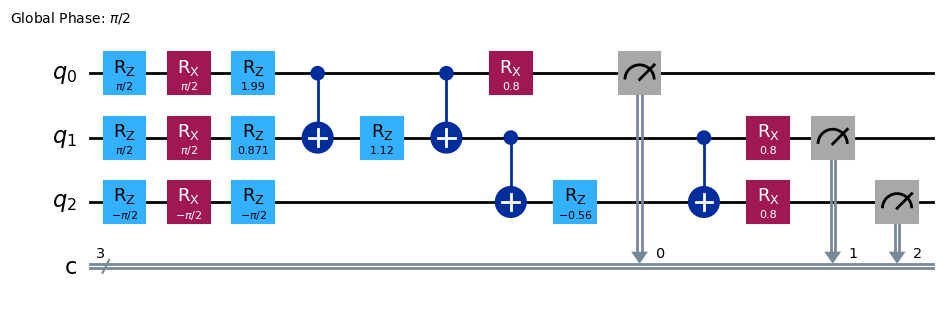

In [24]:
# Example: 3 qubits, toy Ising coefficients

z_lin = np.array([0.3, -0.5, 0.0])    # linear Z terms
z_pair = np.zeros((3,3))
z_pair[0,1] = 0.8
z_pair[1,2] = -0.4

gammas = [0.7]   # depth p=1
betas  = [0.4]

qc = qaoa_circuit(z_lin, z_pair, gammas, betas, measure=True)

# 1) Nicest option (Matplotlib rendering)
qc.draw('mpl')         # shows gates with nice layout

# 2) Text fallback if mpl unavailable
print(qc.draw('text'))

# 3) To see hardware-decomposed circuit (RZZ → CX + RZ + CX)
from qiskit import transpile
tqc = transpile(qc, basis_gates=['rz','rx','cx'])
tqc.draw('mpl')

In [25]:
# ---------- Dummy financial data ----------
mu = np.array([0.1, 0.2])   # expected returns (2 assets)
Sigma = np.array([[0.05, 0.01],
                  [0.01, 0.04]])  # covariance matrix
v_levels = [0.0, 0.5, 1.0]  # 3 one-hot buckets per asset
lam = 0.5                   # risk aversion
A_onehot = 5.0               # one-hot penalty
B_budget = 1.0               # budget penalty

# ---------- Pipeline ----------
# Step 1: Build QUBO
h, J, idx_map = build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot, B_budget)

# Step 2: Convert QUBO -> Ising
z_lin, z_pair, const = qubo_to_ising_onehot(h, J)

# Step 3: Build QAOA circuit
gammas = [0.7]   # depth p = 1
betas  = [0.4]
qc = qaoa_circuit(z_lin, z_pair, gammas, betas, measure=True)

# ---------- Visualise ----------
qc.draw("mpl")   # nice matplotlib plot
# or, as fallback:
print(qc.draw("text"))

     ┌───┐  ┌──────────┐                      ┌─────────┐               ┌─┐»
q_0: ┤ H ├──┤ Rz(-3.5) ├──■─────────■─────────┤ Rx(0.8) ├───────────────┤M├»
     ├───┤┌─┴──────────┴┐ │ZZ(3.5)  │         └─────────┘               └╥┘»
q_1: ┤ H ├┤ Rz(-3.8307) ├─■─────────┼─────────■────────────■─────────────╫─»
     ├───┤├─────────────┤           │ZZ(3.5)  │ZZ(3.8587)  │             ║ »
q_2: ┤ H ├┤ Rz(-4.1615) ├───────────■─────────■────────────┼─────────────╫─»
     ├───┤└─┬──────────┬┘                                  │             ║ »
q_3: ┤ H ├──┤ Rz(-3.5) ├───────────────────────────────────┼─────────────╫─»
     ├───┤┌─┴──────────┴┐                                  │ZZ(0.17587)  ║ »
q_4: ┤ H ├┤ Rz(-3.7931) ├──────────────────────────────────■─────────────╫─»
     ├───┤├─────────────┤                                                ║ »
q_5: ┤ H ├┤ Rz(-4.0862) ├────────────────────────────────────────────────╫─»
     └───┘└─────────────┘                                                ║ »

## Post-processing

The function `bitstring_to_zvec(s,n)` converts a measured bitstring `s` (e.g. 00100) into a 1D array (e.g. [1 1 -1 1 1]) for calculating $\langle H_C \rangle$.

The variable `n` is the number of bits in the bitstring.

In [26]:
def bitstring_to_zvec(s, n):
    """
    Convert a Qiskit bitstring to a ±1 spin vector z of length n.
    Qiskit returns bitstrings most-significant bit leftmost, and with
    measure(range(n), range(n)) the leftmost char corresponds to qubit n-1.
    We reverse the string so index 0 maps to qubit 0.
    """
    x = np.fromiter((int(c) for c in s[::-1]), dtype=int, count=n)
    z = 1 - 2*x  # 0->+1, 1->-1
    return z

The `expectation_from_counts` function estimates the **expected value of the cost Hamiltonian** from the measurement results (counts) obtained after running a QAOA circuit on a quantum simulator or real backend.

This expectation value corresponds to the **average energy** of the sampled bitstrings under the Ising-form Hamiltonian:

$$
\langle H_C \rangle
= \sum_i z_{\text{lin},i} \langle Z_i \rangle
+ \sum_{i<j} z_{\text{pair},ij} \langle Z_i Z_j \rangle
$$

### Inputs

| Parameter | Type | Description |
|------------|------|-------------|
| `z_lin` | array-like, shape `(n,)` | Linear coefficients of the cost Hamiltonian. Each term corresponds to a single-qubit \( Z_i \) operator. |
| `z_pair` | array-like, shape `(n,n)` | Quadratic coupling matrix for two-qubit interactions \( Z_i Z_j \). Only the **upper triangle** is used to avoid double counting. |
| `counts` | dict `{bitstring: shots}` | Measurement histogram from Qiskit, mapping each measured bitstring (e.g. `'0101'`) to how many times it was observed. The sum of all counts equals the total number of **shots**. 

### Outputs

`exp_val` is the output of the function and is the expectation value $\langle H_C \rangle$, i.e. the weighted average energy computed from the measurement outcomes.


In [27]:
def expectation_from_counts(z_lin, z_pair, counts):
    """
    Compute ⟨H_C⟩ = E = sum_i z_lin[i] Z_i + sum_{i<j} z_pair[i,j] Z_i Z_j
    from a counts dict returned by result.get_counts(...).

    z_lin : (n,)
    z_pair: (n,n) (only upper triangle used)
    counts: dict {bitstring: shots}
    """
    z_lin = np.asarray(z_lin, dtype=float).ravel()
    n = z_lin.size
    z_pair = np.asarray(z_pair, dtype=float)
    assert z_pair.shape == (n, n), "z_pair shape must be (n, n)"

    total = sum(counts.values())
    if total == 0:
        return np.nan

    # Pre-extract nonzero ZZ pairs (upper triangle)
    ii, jj = np.triu_indices(n, 1)
    pair_mask = (z_pair[ii, jj] != 0.0)
    ii, jj = ii[pair_mask], jj[pair_mask]
    coeffs = z_pair[ii, jj]

    exp_val = 0.0
    for s, c in counts.items():
        z = bitstring_to_zvec(s, n)
        e = float(z_lin @ z)
        if coeffs.size:
            e += float(np.sum(coeffs * z[ii] * z[jj]))
        exp_val += (c / total) * e
    return exp_val


The `estimate_expectation()` function executes a **QAOA circuit** and estimates the **expected cost Hamiltonian value** from its measurement outcomes.

It ensures that the circuit included measurement operations, runs it on the chosen backend, gathers bitstring **counts**, and calls `expectation_from_counts()` to compute the energy expectation.

### Inputs

| Parameter | Type | Description |
|------------|------|-------------|
| `qc` | `QuantumCircuit` | The QAOA circuit to be executed. If it has no measurement operations, they will be added automatically. |
| `z_lin` | array-like, shape `(n,)` | Linear coefficients of the Ising cost Hamiltonian. |
| `z_pair` | array-like, shape `(n,n)` | Quadratic coupling matrix (only the upper triangle is used). |
| `shots` | int, optional | Number of measurement shots (repetitions) to run on the backend. Default = 2000. |
| `backend` | Qiskit backend, optional | The quantum backend on which to execute the circuit (e.g. `Aer.get_backend("qasm_simulator")`). If `None`, the Aer simulator is used by default. |

---

### Outputs

- `exp_val` (float): Estimated expectation value $\langle H_C \rangle$ computed from the measured bitstring distribution.
- `counts` (dict `{bitstring: shots}`): Measurement histogram giving how often each bitstring was observed.


In [28]:
def estimate_expectation(qc, z_lin, z_pair, shots=20_000,
                         backend=None,                 # <— restored
                         backend_name="ibm_brussels",  # used if backend is None
                         opt_level=1):
    import numpy as np
    z_lin = np.asarray(z_lin, dtype=float).ravel()
    n = z_lin.size

    # ensure measurements
    qc_run = qc.copy()
    if qc_run.num_clbits == 0:
        qc_run = qc_run.copy()
        qc_run.measure_all(add_bits=True)

    # --- Choose execution path ---
    if backend is None or hasattr(backend, "target"):  # IBM path (None -> pick by name; or a real IBM backend obj)
        if backend is None:
            service = QiskitRuntimeService()
            backend = service.backend(backend_name)

        pm = generate_preset_pass_manager(optimization_level=opt_level, backend=backend)
        qc_isa = pm.run(qc_run)

        sampler = Sampler(mode=backend)
        res = sampler.run([(qc_isa,)], shots=shots).result()
        try:
            counts = res[0].data.meas.get_counts()
        except Exception:
            # fallback if only bitstrings are exposed
            bitstrings = res[0].data.meas.get_bitstrings()
            counts = {}
            for b in bitstrings:
                counts[b] = counts.get(b, 0) + 1

    else:
        # Aer path if you explicitly pass an Aer backend
        from qiskit_aer import Aer
        if backend == "aer" or backend is Aer:
            backend = Aer.get_backend("qasm_simulator")
        tqc = transpile(qc_run, backend=backend, optimization_level=1)
        result = backend.run(tqc, shots=shots).result()
        counts = result.get_counts()

    return expectation_from_counts(z_lin, z_pair, counts), counts

### Example pipeline on dummy data

In [29]:
# 1) Build QUBO (one-hot), 2) convert to Ising, 3) build circuit, 4) estimate ⟨H_C⟩
mu = np.array([0.1, 0.2])
Sigma = np.array([[0.05, 0.01],
                  [0.01, 0.04]])
v_levels = [0.0, 0.5, 1.0]
lam, A_onehot, B_budget = 0.5, 5.0, 1.0

h, J, idx_map = build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot, B_budget)
z_lin, z_pair, _ = qubo_to_ising_onehot(h, J)

gammas = [0.7]; betas = [0.4]
qc = qaoa_circuit(z_lin, z_pair, gammas, betas, measure=False)  # no need to pre-measure

E_hat, counts = estimate_expectation(qc, z_lin, z_pair, shots=4096)
print("Estimated <H_C> =", E_hat)

Estimated <H_C> = -6.067689208984375


### Example pipeline on real data

In [29]:
# Test on real data
mu = np.array(mu_annual)
Sigma = np.array(sigma_annual)
v_levels = [0.0, 0.25, 0.5, 0.75, 1.0]
lam, A_onehot, B_budget = 0.5, 5.0, 1.0

h, J, idx_map = build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot, B_budget)
z_lin, z_pair, _ = qubo_to_ising_onehot(h, J)

gammas = np.array([0.074054])
betas  = np.array([2.528226])
qc = qaoa_circuit(z_lin, z_pair, gammas, betas, measure=False)  # no need to pre-measure

E_hat, counts = estimate_expectation(qc, z_lin, z_pair, shots=4096)
print("Estimated <H_C> =", E_hat)


Estimated <H_C> = -1.1681531405496477


## Concept Recap

After training the QAOA, we obtain optimal circuit parameters $(\gamma, \beta)$ that minimise the expected value of the cost hamiltonian:

$$
C(\gamma , \beta) = \langle \psi(\gamma, \beta)|H_C | \psi (\gamma , \beta) \rangle
$$

The cost hamiltonian encodes the portfolio optimisation objective, which in the QUBO form:

$$
H_C = \sum_i h_i Z_i + \sum_{i<j} J_{ij} Z_i Z_j
$$

where:

- $h_i$ corresponds to the $\textbf{linear biases}$ (expected returns, budget terms).
- $J_{ij}$ encodes $\textbf{quadratic couplings}$ (covariance and penalty terms).

Each qubit represents a $\textbf{binary decision variable}$ $x_{i,m} \in \{0,1 \}$, indicating whether asset $i$ is assigned to weight level $v_m$. 

For each asset $i$, exactly one of its corresponding qubits should be active ( $x_{i,m} = 1$ for a single $m$).

This is reflected in the $\textbf{one-hot constraint}$:

$$
\sum_m x_{i,m} = 1
$$

The overall portfolio weights are then reconstructed as:

$$
w_i = \sum_m v_m x_{i,m},
$$

where $v_m$ are the discretised weight levels.

The $\textbf{mixer Hamiltonian}$:

$$
H_M = \sum_i X_i
$$

enables transitions between bistrings during optimisation.

## Measuring the final state

Once we apply the QAOA circuit with the trained parameters:

$$
|\psi (\boldsymbol{\gamma},\boldsymbol{\beta})\rangle = U_M(\boldsymbol{\beta})U_C(\boldsymbol{\gamma})|s\rangle , 
$$

where $|s\rangle$ is the initial quantum state before any QAOA layers are applied.
We measure the resulting quantum state in the computational basis.

Each measured bitsring:

$$
x = x_{i,m} \quad i = 1, \dots , N \quad m = 1, \dots , M
$$

represents a possible potential portfolio configuration.

- The frequency of a bitstring reflects its probability amplitude squared.
- The energy (or cost) of a bitstring under $H_C$ gives the value of the objective function for that portfolio.

By evaluating:

$$
E(x) = \sum_i h_i x_i + \sum_{i<j} J_{ij} x_i x_j,
$$

We can identify the lowest energy bitstring as the $\textbf{optimal portfolio}$.

## Selecting the Final Portfolio

The post processing code below:

- Runs the circuit with optimal $(\boldsymbol{\gamma} , \boldsymbol{\beta})$ on a simulator.
- Collects measurement counts for all bistrings.
- Evaluates the bitstrings energy using $H_C$.
- Selects the $\textbf{minimum-energy configuration}$ as the final solution.
- Converts the corresponding bitstring into a vector of $\textbf{portfolio weights}$.

This mirrors how you select the ground state in a variational quantum algorithm.

## Final pipeline



In [30]:
# === FINAL WEIGHTS (one-hot) — minimal refactor using existing functions ===

def bitstring_to_binary_vec(s, n):
    """
    Reuse your existing bitstring_to_zvec(s, n), then map ±1 spins -> {0,1} binaries.
    """
    z = bitstring_to_zvec(s, n)           # returns ±1 with index 0 ↔ qubit 0
    return ((1 - z) // 2).astype(int)     # 0->+1, 1->-1  ==>  x = (1 - z)/2

def energy_qubo_bitstring(bitstr, h, J):
    """
    QUBO energy for a measured bitstring x in {0,1}^n.
    Assumes J stores only the upper triangle (a < b), matching your notebook build.
    E(x) = Σ_a h_a x_a + Σ_{a<b} J_ab x_a x_b
    """
    x = bitstring_to_binary_vec(bitstr, len(h))
    e_lin = float(h @ x)
    e_quad = 0.0
    # sum only upper triangle to avoid double counting
    for a in range(x.size):
        if x[a] == 0:
            continue
        e_quad += float(J[a, a+1:] @ x[a+1:])
    return e_lin + e_quad

def decode_weights_one_hot(bitstr, idx_map, v_levels, renormalize=True):
    """
    Decode a one-hot bitstring to portfolio weights:
    bitstr -> w_i = Σ_m v_m x_{i,m}, using idx_map: {flat_index -> (i, m)}.
    """
    n = len(idx_map)
    x = bitstring_to_binary_vec(bitstr, n)
    # infer number of assets from idx_map values
    N = 1 + max(i for (i, m) in idx_map.values())
    v = np.asarray(v_levels, dtype=float)

    w = np.zeros(N, dtype=float)
    for a, (i, m) in idx_map.items():
        if x[a] == 1:
            w[i] += float(v[m])

    if renormalize and w.sum() > 0:
        w = w / w.sum()
    return x, w

def qaoa_final_weights(qc, h, J, idx_map, v_levels,
                                                     shots=20_000, backend=None,
                                                     renormalize=True):
    
    # We only need counts; pass zero arrays for the Ising form since we won't use ⟨H_C⟩ here.
    n = len(h)
    z_lin_dummy  = np.zeros(n, dtype=float)
    z_pair_dummy = np.zeros((n, n), dtype=float)
    _, counts = estimate_expectation(qc, z_lin_dummy, z_pair_dummy, shots=shots, backend=backend)

    # Pick minimum-energy observed bitstring under QUBO (h, J)
    best_key, best_E = None, float("inf")
    for s in counts.keys():
        E = energy_qubo_bitstring(s, h, J)
        if E < best_E:
            best_E, best_key = E, s

    onehot_vec, w = decode_weights_one_hot(best_key, idx_map, np.asarray(v_levels), renormalize=renormalize)

    print("Best bitstring (Qiskit key, MSB→LSB):", best_key)
    print("Minimum observed QUBO energy:", best_E)
    print("Final weights (sum=1):", w)

    return {
        "bitstring": best_key,
        "energy": best_E,
        "onehot_vector": onehot_vec,
        "weights": w,
        "counts": counts
    }

In [31]:
# === Run QAOA circuit with optimal parameters and extract portfolio weights (refactored) ===

# Store optimal values as 1-element arrays (for p=1)
gammas_opt = np.array([0.074054])
betas_opt  = np.array([2.528226])

# 1) Build the QAOA circuit (no measurements needed here)
qc = qaoa_circuit(z_lin, z_pair, gammas_opt, betas_opt, measure=False, add_barriers=False)

# 2) Use the refactored pipeline (executes circuit via estimate_expectation, picks min-QUBO-energy bitstring, decodes weights)
result = qaoa_final_weights(  
    qc=qc,
    h=h,
    J=J,                  # J upper-triangular as built
    idx_map=idx_map,      # {flat_index -> (i, m)}
    v_levels=v_levels,
    shots=50_000,         # same as before
    backend=None,         # use default Aer qasm_simulator inside estimate_expectation
    renormalize=True
)

# 3) Extract and display final results
w_star = result["weights"]

print("\n=== Final Portfolio Weights ===")
for i, w in enumerate(w_star):
    print(f"Asset {i+1}: {w:.4f}")

Best bitstring (Qiskit key, MSB→LSB): 100000010000001
Minimum observed QUBO energy: -17.18202253257249
Final weights (sum=1): [0.         0.33333333 0.66666667]

=== Final Portfolio Weights ===
Asset 1: 0.0000
Asset 2: 0.3333
Asset 3: 0.6667


## Stable Final Weights via Pooled Counts

### Purpose
This cell makes QAOA results **more stable** by running the circuit multiple times, **pooling measurement counts** across runs, and then selecting the **single observed bitstring** with the **most negative QUBO energy**. It also returns diagnostics (mean/std of decoded weights) to quantify variability.



### Functions

`merge_counts(dicts)`

Merges a list of Qiskit `counts` dictionaries (bitstring → frequency) into one combined histogram.

- **Input:** `dicts` — list of counts dicts, e.g. `[{'010': 12, ...}, {'010': 8, ...}, ...]`
- **Output:** one dict with summed frequencies, e.g. `{'010': 20, ...}`

---

 `pick_min_energy_from_counts(counts, h, J, idx_map, v_levels, renormalize=True)`
 
Given a counts histogram, score **each observed bitstring** using the QUBO energy

$$
E(x) = \sum_p h_p x_p + \sum_{p<q} J_{pq}x_p x_q
$$

(assumes **upper-triangular** `J` to avoid double counting), then:

1. Pick the **bitstring with minimum energy**.
2. **Decode** it into portfolio weights using the one-hot map (`idx_map`, `v_levels`).
3. Optionally **renormalize** weights to sum to 1.

- **Inputs:** `counts`, `h`, `J (upper-triangular)`, `idx_map: {flat_index → (asset i, level m)}`, `v_levels`
- **Returns:** `(best_key, best_E, onehot_vec, w)`

> Uses helper functions  defined earlier:
> - `energy_qubo_bitstring(...)`
> - `decode_weights_one_hot(...)`

---

 `run_stable_final_weights(qc, h, J, idx_map, v_levels, n_runs=10, shots=20_000, backend=None, renormalize=True, seed_simulator=None, seed_transpiler=None)`
 
End-to-end routine to obtain **stable final weights**:

1. **Backend setup & seeding** (optional):  
   - If no backend is provided, uses `Aer.get_backend("qasm_simulator")`.  
   - If `seed_simulator` is set, passes it to the backend for reproducible sampling.  
   - If `seed_transpiler` is set, uses it when transpiling to reduce layout randomness.

2. **Repeated execution** (`n_runs` times):  
   - Ensures measurements (via `estimate_expectation` or explicit transpile+run).
   - Collects per-run `counts`.
   - For each run, also decodes that run’s **own** best bitstring to get a weight vector (for diagnostics).

3. **Pooling and selection**:  
   - Combine all per-run histograms with `merge_counts`.
   - From the **pooled** histogram, choose the **minimum-energy** bitstring and decode final weights.

4. **Diagnostics**:  
   - Stack the per-run weight vectors and compute mean/std across runs.

- **Inputs**
  - `qc`: QAOA circuit (measured or unmeasured; measurements will be added if missing).
  - `h`: QUBO linear biases (one-hot space).
  - `J`: QUBO quadratic couplings (**upper triangle filled**).
  - `idx_map`: maps one-hot flat indices to `(asset i, level m)`.
  - `v_levels`: discrete weight levels for one-hot encoding.
  - `n_runs`, `shots`: how many executions and shots per run.
  - `backend`: optional Qiskit backend (defaults to Aer QASM simulator).
  - `seed_simulator`, `seed_transpiler`: integers for reproducibility.
  - `renormalize`: if `True`, scales decoded weights to sum to 1.

- **Returns** a dictionary:
  - `"bitstring"`: best pooled bitstring (Qiskit key, MSB→LSB)
  - `"energy"`: most negative pooled QUBO energy
  - `"onehot_vector"`: decoded one-hot vector for that bitstring
  - `"weights"`: final portfolio weights (renormalized if requested)
  - `"counts_pooled"`: merged histogram across all runs
  - `"per_run_counts"`: list of counts dicts (one per run)
  - `"per_run_weights"`: matrix of decoded weights (shape `n_runs × n_assets`)
  - `"stats"`: summary (mean/std of weights, `n_runs`, `shots_per_run`, `total_shots`)

---

## Why pool counts?
QAOA sampling is stochastic. A single execution may miss the truly best bitstring. By **summing counts** across multiple runs, you approximate the underlying distribution better and reduce variance in the selected portfolio.



In [32]:
def merge_counts(dicts):
    merged = Counter()
    for d in dicts:
        merged.update(d)
    return dict(merged)

def pick_min_energy_from_counts(counts, h, J, idx_map, v_levels, renormalize=True):
    # Uses your existing helpers from the refactor
    best_key, best_E = None, float("inf")
    for s in counts:
        E = energy_qubo_bitstring(s, h, J)  # assumes J upper-triangular
        if E < best_E:
            best_E, best_key = E, s
    onehot_vec, w = decode_weights_one_hot(best_key, idx_map, np.asarray(v_levels), renormalize)
    return best_key, best_E, onehot_vec, w

def run_stable_final_weights(qc, h, J, idx_map, v_levels,
                             n_runs=10, shots=20_000, backend=None,
                             renormalize=True,
                             seed_simulator=None, seed_transpiler=None):
    """
    Run the QAOA circuit multiple times, pool counts, and return the bitstring/weights
    with the most negative QUBO energy observed across all runs combined.
    Also returns per-run decoded weights for stability diagnostics.
    """
    # Optionally set seeds for reproducibility (Aer backends)
    if backend is None:
        from qiskit_aer import Aer
        backend = Aer.get_backend("qasm_simulator")
    if seed_simulator is not None:
        try:
            backend.set_options(seed_simulator=int(seed_simulator))
        except Exception:
            pass  # ignore if backend doesn't support it

    # Collect counts across runs
    per_run_counts = []
    per_run_weights = []

    n = len(h)
    z_lin_dummy  = np.zeros(n)
    z_pair_dummy = np.zeros((n, n))

    from qiskit import transpile
    for _ in range(n_runs):
        # Rebuild measured circuit via estimate_expectation
        # (estimate_expectation will add measurements if missing)
        # Use seed_transpiler if provided
        tqc = None
        if seed_transpiler is not None:
            # transpile explicitly with a seed, then run
            needs_measure = (qc.num_clbits == 0)
            if needs_measure:
                from qiskit import QuantumCircuit
                qc_run = QuantumCircuit(n, n)
                qc_run.compose(qc, inplace=True)
                qc_run.measure(range(n), range(n))
            else:
                qc_run = qc
            tqc = transpile(qc_run, backend=backend, optimization_level=1, seed_transpiler=int(seed_transpiler))

        # Execute and get counts (reuse expectation function)
        if tqc is None:
            # Let estimate_expectation handle transpile/run
            _, counts = estimate_expectation(qc, z_lin_dummy, z_pair_dummy, shots=shots, backend=backend)
        else:
            result = backend.run(tqc, shots=shots).result()
            counts = result.get_counts()

        per_run_counts.append(counts)

        # Also decode the best from this single run (useful for std/diagnostics)
        best_key, best_E, onehot_vec, w = pick_min_energy_from_counts(counts, h, J, idx_map, v_levels, renormalize)
        per_run_weights.append(w)

    # Pool counts and pick global best
    pooled = merge_counts(per_run_counts)
    best_key, best_E, onehot_vec, w_star = pick_min_energy_from_counts(pooled, h, J, idx_map, v_levels, renormalize)

    # Diagnostics
    W = np.vstack(per_run_weights)  # shape (n_runs, n_assets)
    stats = {
        "weights_mean": W.mean(axis=0),
        "weights_std":  W.std(axis=0, ddof=1) if n_runs > 1 else np.zeros_like(W[0]),
        "n_runs": n_runs,
        "shots_per_run": shots,
        "total_shots": sum(pooled.values())
    }

    return {
        "bitstring": best_key,
        "energy": best_E,
        "onehot_vector": onehot_vec,
        "weights": w_star,
        "counts_pooled": pooled,
        "per_run_counts": per_run_counts,
        "per_run_weights": W,
        "stats": stats
    }

In [33]:
# Build once with your optimal params
gamma = np.array([2.276443618468566])
beta = np.array([2.085301915703815])

qc = qaoa_circuit(z_lin, z_pair, gamma, beta, measure=False)

res = run_stable_final_weights(
    qc=qc,
    h=h,
    J=J,
    idx_map=idx_map,
    v_levels=v_levels,
    n_runs=10,          # try 10–30
    shots=20_000,       # increase if needed
    seed_simulator=123, # set both seeds for reproducibility (optional)
    seed_transpiler=123,
    renormalize=True
)

print("\n=== Final (pooled) Portfolio Weights ===")
for i, w in enumerate(res["weights"]):
    print(f"Asset {i+1}: {w:.4f}")

print("\nMost negative pooled QUBO energy:", res["energy"])
print("Per-asset std across runs:", res["stats"]["weights_std"])


=== Final (pooled) Portfolio Weights ===
Asset 1: 0.0000
Asset 2: 0.6000
Asset 3: 0.4000

Most negative pooled QUBO energy: -17.071796711813484
Per-asset std across runs: [0.00000000e+00 1.17027782e-16 5.85138911e-17]


---
# Optimising $\beta$ and $\gamma$

We will explore two optimisation methods to tune the QAOA parameters $(\beta, \gamma)$ for a portfolio optimisation problem:
- Bayesian Optimisation (BO)
- Reinforcement Learning (RL) using the REINFORCE algorithm

Both methods rely on the black-box function that is the output of the QAOA Algorithm -
`evaluate_qaoa(params)`

The output of this function is a scalar cost (energy) from QAOA (lower = better portfolio). Our task is to tune $(\beta, \gamma)$ so that QAOA produces the lowest energy, corresponding to the best Sharpe ratio portfolio under the QUBO formulation.

Afterwards, we will see which optimisation method works best in both accuracy and time performance.

Firstly we will define our space of inputs: $\beta \in \left[0, \pi\right], \gamma \in \left[0, 2\pi\right]$. The below are used in both optimisation methods.

In [34]:
# Fake function

def evaluate_qaoa(params):
    """
    Mock QAOA evaluation function for testing.

    Parameters
    ----------
    params : tuple
        (beta, gamma)

    Returns
    -------
    float
        Simulated energy (lower is better)
    """
    beta, gamma = params

    # "True" optimal point (hidden from optimizer)
    beta_star, gamma_star = np.pi/3, np.pi

    # Quadratic bowl around the optimum
    energy = (beta - beta_star)**2 + (gamma - gamma_star)**2

    # Add a little noise to simulate quantum measurement error
    noise = np.random.normal(0, 0.05)
    
    return energy + noise

In [35]:
search_space = [
    Real(0, np.pi, name="beta"),
    Real(0, 2*np.pi, name="gamma")
]

Next we will use a wrapper over our evaluation function

In [36]:
def objective(params):
    beta, gamma = params
    energies = [evaluate_qaoa((beta, gamma)) for _ in range(3)]
    return np.mean(energies)

# Bayesian Optimisation (BO)

Bayesian Optimization (BO) is a powerful global optimization method for black-box, expensive-to-evaluate objective functions. It is particularly useful when function evaluations are costly (e.g. training ML models, running quantum circuits) or when gradients are not available.

---

## Problem Setup

Bayesian Optimization is designed to solve optimization problems of the form:

$$
x^* = \arg\min_{x \in \mathcal{X}} f(x)
$$

where:

- $f: \mathcal{X} \rightarrow \mathbb{R}$ is a **black-box function**
- $ \mathcal{X} \subset \mathbb{R}^d $ is the bounded search space
- $ f(x) $ is expensive to evaluate (e.g., requires simulation or hardware runs)
- No gradient information is available

---

## Key Components

### 1. **Surrogate Model (Probabilistic Model)**

Bayesian Optimization builds a surrogate model $ \hat{f}(x) $ of the true objective function $f(x)$, typically using a **Gaussian Process (GP)**:

$$
f(x) \sim \mathcal{GP}(\mu(x), k(x, x'))
$$

- $\mu(x)$: mean function (often set to zero)
- $k(x, x')$: kernel function (e.g., RBF, Matern), models correlation between points
- The GP gives a distribution over possible function values at each $$x$

From the GP, we obtain:

- **Mean**: $\mu(x)$ — estimated function value
- **Uncertainty**: $\sigma(x)$ — model's confidence (standard deviation)

---

### 2. **Acquisition Function**

The acquisition function $\alpha(x)$ guides where to evaluate next by balancing:

- **Exploitation** (low predicted mean $\mu(x)$)
- **Exploration** (high uncertainty $\sigma(x)$)

Common acquisition functions include:

#### Expected Improvement (EI)

$$
\alpha_{\text{EI}}(x) = \mathbb{E}[\max(f^* - f(x), 0)] = (f^* - \mu(x)) \Phi(z) + \sigma(x) \phi(z)
$$

Where:

- $f^*$: best function value seen so far
- $z = \frac{f^* - \mu(x)}{\sigma(x)}$
- $\Phi(z)$: CDF of the standard normal distribution
- $\phi(z)$: PDF of the standard normal distribution

#### Upper Confidence Bound (UCB)

$$
\alpha_{\text{UCB}}(x) = \mu(x) - \kappa \cdot \sigma(x)
$$

- $\kappa$ controls the trade-off between exploration and exploitation.

---

## Bayesian Optimization Loop

1. **Initialize** with a few evaluations of $f(x)$
2. **Fit** a GP model to current data
3. **Maximize** the acquisition function to find next point $x_{\text{next}}$
4. **Evaluate** $f(x_{\text{next}})$
5. **Update** the GP with new data
6. **Repeat** until budget or convergence

$$
\text{next } x = \arg\max_x \alpha(x \mid \mathcal{D}_{1:t})
$$

Where $\mathcal{D}_{1:t} = \{(x_i, f(x_i))\}_{i=1}^t$ is the dataset of past evaluations.

---

### Why did we choose Bayesian Optimisation for this use-case?

BO is designed for black-box functions that are expensive to evaluate (like QAOA circuits).
It builds a surrogate model (usually Gaussian Process) to approximate the objective.

At each step, it balances:
- Exploration: trying new areas in parameter space
- Exploitation: focusing on areas likely to give good results

We’ll use `scikit-optimize` (skopt), which provides a simple BO API.

In [37]:
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=50,        # number of evaluations
    n_random_starts=5, # random initial points
    noise=0.05**2,
    random_state=42 # Reproducability
)

Best parameters found:
beta = 1.0758194490833413
gamma = 3.115787185518917
Energy = -0.0652032674295759


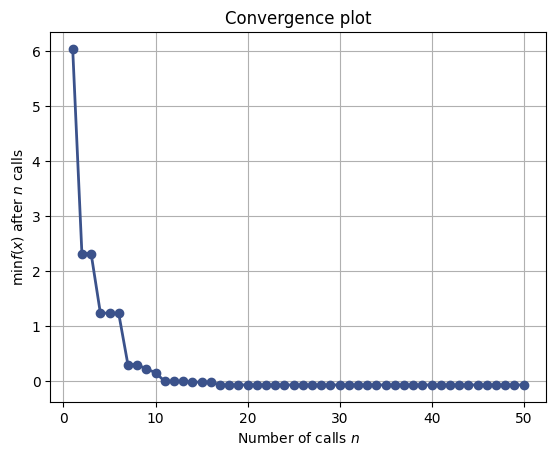

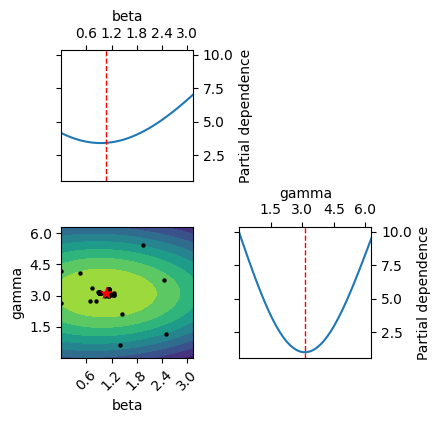

In [38]:
print("Best parameters found:")
print("beta =", result.x[0])
print("gamma =", result.x[1])
print("Energy =", result.fun)

plot_convergence(result)
plt.show()

plot_objective(result)
plt.show()

## Bayesian Optimization for QAOA (Periodic Parameters)

The basic approach above worked well but can be improved. This can be done by utilising:
 - Both beta and gamma parameters treated as periodic
 - Noise handling by averaging multiple evaluations
 - Periodic kernel in the Gaussian Process
 
Below is an implementation using these.

In [39]:
def evaluate_qaoa(params):
    """
    Mock QAOA evaluation function for testing.
    Lower energy = better solution.
    """
    beta, gamma = params
    beta_star, gamma_star = np.pi/3, np.pi
    energy = (beta - beta_star)**2 + (gamma - gamma_star)**2
    noise = np.random.normal(0, 0.05)  # simulate measurement noise
    return energy + noise

##### Objective Function for Bayesian Optimization

 - Wraps `evaluate_qaoa` to handle multiple evaluations for noise reduction.
 - Uses a cache to avoid redundant evaluations.
 - Returns the average energy (to be minimized).


In [40]:
eval_cache = {}

@use_named_args([Real(0, np.pi, name="beta"), Real(0, 2*np.pi, name="gamma")])
def objective(beta, gamma):
    """
    Average multiple evaluations to reduce noise.
    Returns energy (minimize).
    """
    n_repeats = 3
    key = (round(beta,6), round(gamma,6))
    if key in eval_cache:
        return eval_cache[key]
    
    energies = [evaluate_qaoa((beta, gamma)) for _ in range(n_repeats)]
    avg_energy = float(np.mean(energies))
    eval_cache[key] = avg_energy
    return avg_energy


##### Periodic Kernel for GP

 - `beta` is treated as periodic with period π  
 - `gamma` is treated as periodic with period 2π  
 - The GP uses this kernel to model the QAOA energy function respecting wrap-around boundaries

In [41]:
k_beta  = ConstantKernel(1.0) * ExpSineSquared(length_scale=1.0, periodicity=np.pi)
k_gamma = ConstantKernel(1.0) * ExpSineSquared(length_scale=1.0, periodicity=2*np.pi)
kernel = k_beta + k_gamma

# Use skopt's GP wrapper
base_gp = SkoptGP(kernel=kernel, alpha=0.05**2, normalize_y=True)

##### Run Bayesian Optimization
 
 - `n_calls` controls total number of energy evaluations
 - `n_random_starts` ensures initial random exploration
 - `base_estimator` uses the GP with periodic kernel


In [42]:
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=50,
    n_random_starts=10, # Exploration
    random_state=42, # reproducability
    base_estimator=base_gp,
    acq_func="EI", # Expected Improvement (Can change to LCB or PI)
    xi=0.01, # Exploration param for EI/PI
    # kappa=2.0, # Exploration param for LCB
)

In [43]:
print("Best parameters found:")
print("beta  =", result.x[0])
print("gamma =", result.x[1])
print("Energy =", result.fun)

Best parameters found:
beta  = 0.9883512636235615
gamma = 3.22866866379842
Energy = -0.04962900204497075


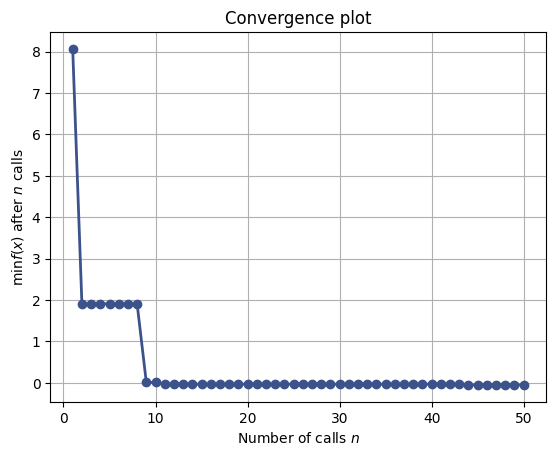

In [44]:
plot_convergence(result)
plt.show()

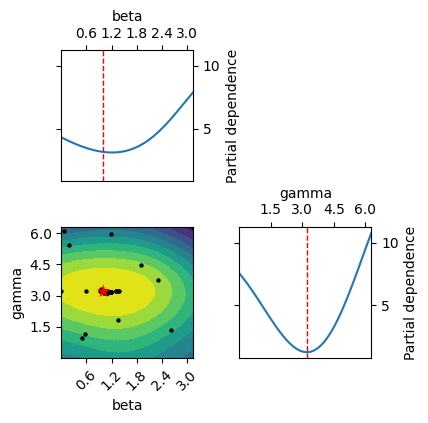

In [45]:
plot_objective(result)
plt.show()

---
# Overview of Reinforcement Learning (RL)

Reinforcement Learning (RL) is a learning paradigm where an **agent** interacts with an **environment** to learn a policy that maximizes long-term cumulative reward.

---

## Problem Setup: Markov Decision Process (MDP)

The RL problem is typically modeled as a **Markov Decision Process (MDP)** defined by the tuple:

$$
(\mathcal{S}, \mathcal{A}, P, R, \gamma)
$$

Where:

- $\mathcal{S}$: set of states
- $\mathcal{A}$: set of actions
- $P(s' \mid s, a)$: transition probability function
- $R(s, a)$: reward function
- $\gamma \in [0, 1)$: discount factor

---

## Agent-Environment Interaction Loop

At each time step $t$:

1. The agent observes state $s_t$
2. It selects action $a_t \sim \pi(a_t \mid s_t; \theta)$
3. It receives reward $r_t$ and transitions to next state $s_{t+1} \sim P(s_{t+1} \mid s_t, a_t)$

---

## Goal: Maximize Expected Return

The objective is to find a policy $\pi_\theta(a \mid s)$ that **maximizes the expected cumulative reward** (also called the return):

$$
J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \sum_{t=0}^{\infty} \gamma^t r_t \right]
$$

---

## Types of RL Approaches

1. **Value-Based Methods**: Learn value functions (e.g., Q-learning, DQN)
2. **Policy-Based Methods**: Directly learn the policy $\pi(a|s)$ (e.g., REINFORCE, PPO)
3. **Actor-Critic Methods**: Combine both (e.g., A2C, PPO with value function baseline)

---

# The REINFORCE Algorithm (Monte Carlo Policy Gradient)

**REINFORCE** is a basic **policy gradient** method introduced by Williams (1992). It learns a parameterized **stochastic policy** by following the gradient of the expected return.

---

## Core Idea

Update the policy parameters $\theta$ using gradient ascent on the expected return:

$$
\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)
$$

Where:

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \nabla_\theta \log \pi_\theta(a_t \mid s_t) \cdot G_t \right]
$$

- $G_t = \sum_{k=t}^{T} \gamma^{k-t} r_k$: the **return** from time $t$
- $\pi_\theta(a_t \mid s_t)$: the **policy** — probability of taking action $a_t$ in state $s_t$

This is called the **likelihood ratio trick** or **score function estimator**.

---

## REINFORCE Algorithm Steps

1. **Collect Trajectories**:
   - Sample episodes $\tau = \{(s_t, a_t, r_t)\}_{t=0}^{T}$ by following the policy $\pi_\theta$

2. **Compute Returns**:
   - For each time step $t$, compute:
     $$
     G_t = \sum_{k=t}^T \gamma^{k-t} r_k
     $$

3. **Compute Gradient Estimate**:
   - For each time step $t$, calculate:
     $$
     \nabla_\theta J(\theta) \approx \nabla_\theta \log \pi_\theta(a_t \mid s_t) \cdot G_t
     $$

4. **Update Policy Parameters**:
   $$
   \theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t \mid s_t) \cdot G_t
   $$

---

## Characteristics of REINFORCE

- On-policy: Uses data from current policy only
- High variance: Can be unstable without baselines
- Simple and easy to implement: Good for understanding fundamentals
- Slow convergence: Requires many samples

---

## With a Baseline (Variance Reduction)

To reduce variance, we can subtract a **baseline** $b(s_t)$ from the return:

$$
\nabla_\theta J(\theta) = \mathbb{E} \left[ \nabla_\theta \log \pi_\theta(a_t \mid s_t) \cdot (G_t - b(s_t)) \right]
$$

If $b(s_t) \approx V^\pi(s_t)$, the baseline becomes a value function estimator — leading to **actor-critic** algorithms.

---

## Summary

- **REINFORCE** is a foundational algorithm in policy gradient RL.
- It directly optimizes the expected return by sampling trajectories and updating the policy using the log-likelihood gradient.
- Although simple, it suffers from high variance and sample inefficiency, and is often replaced by more stable algorithms like **PPO** or **A2C** in practice.



---
## Why did we choose REINFORCE?

REINFORCE is a foundational algorithm in policy gradient RL. It directly optimises the expected return by sampling trajectories and updating the policy using the log-liklihood gradient. It is a simple model so is good as a proof of concept; however later on once we see it performing as expected, we can replace it with a more stable algorithm such as PPO or A2C. The reason we would need to change algorithm is because REINFORCE often suffers from high variance and sample inefficiency.

In all the RL algorithms we use below, we use a 'fake' function for QAOA to save compute time whilst we explore different algorithms

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [47]:
# Policy: Gaussian over beta and gamma
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu = nn.Parameter(torch.tensor([np.pi/2, np.pi]))  # initial mean
        self.log_sigma = nn.Parameter(torch.zeros(2))           # log variance

    def forward(self):
        sigma = torch.exp(self.log_sigma)
        dist = torch.distributions.Normal(self.mu, sigma)
        sample = dist.sample()
        log_prob = dist.log_prob(sample).sum()
        return sample, log_prob

In [48]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=0.05)

n_epochs = 30
baseline = 0
gamma_reward = 0.9  # moving average baseline factor

history = []

for epoch in range(n_epochs):
    sample, log_prob = policy()
    beta, gamma = sample.detach().numpy()
    
    # Reward = negative energy
    energy = evaluate_qaoa((beta, gamma))
    reward = -energy
    
    # Baseline to stabilise
    baseline = gamma_reward * baseline + (1 - gamma_reward) * reward
    
    # Policy gradient loss (REINFORCE)
    loss = -log_prob * (reward - baseline)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    history.append(energy)
    print(f"Epoch {epoch+1}: beta={beta:.3f}, gamma={gamma:.3f}, energy={energy:.4f}")


Epoch 1: beta=1.679, gamma=2.702, energy=0.6527
Epoch 2: beta=1.807, gamma=2.737, energy=0.6969
Epoch 3: beta=0.438, gamma=4.723, energy=2.9222
Epoch 4: beta=2.798, gamma=3.317, energy=3.0211
Epoch 5: beta=3.314, gamma=0.045, energy=14.7505
Epoch 6: beta=0.927, gamma=1.861, energy=1.7207
Epoch 7: beta=1.422, gamma=1.905, energy=1.7223
Epoch 8: beta=0.525, gamma=1.203, energy=4.0285
Epoch 9: beta=1.662, gamma=2.242, energy=1.1232
Epoch 10: beta=1.360, gamma=2.177, energy=1.0976
Epoch 11: beta=1.815, gamma=4.864, energy=3.5892
Epoch 12: beta=0.831, gamma=3.272, energy=-0.0028
Epoch 13: beta=2.887, gamma=3.263, energy=3.3821
Epoch 14: beta=0.170, gamma=3.702, energy=1.0734
Epoch 15: beta=1.739, gamma=2.771, energy=0.5507
Epoch 16: beta=1.039, gamma=3.515, energy=0.1737
Epoch 17: beta=-0.490, gamma=3.637, energy=2.6029
Epoch 18: beta=1.948, gamma=3.524, energy=0.8891
Epoch 19: beta=2.824, gamma=3.706, energy=3.4008
Epoch 20: beta=2.253, gamma=3.063, energy=1.3497
Epoch 21: beta=0.843, gamm

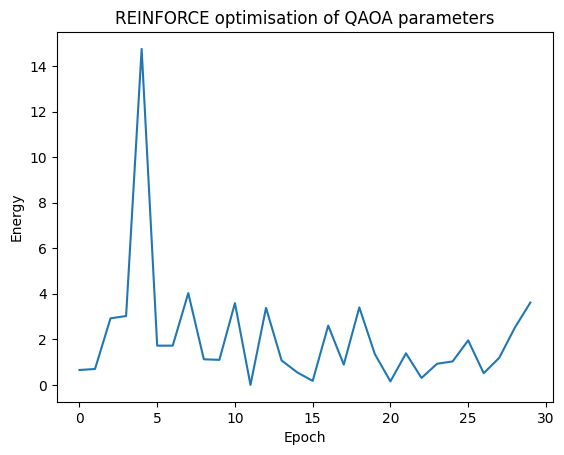

In [49]:
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.title("REINFORCE optimisation of QAOA parameters")
plt.show()

## REINFORCE Algorithm - with improvements

The basic approach above worked well but can be improved. This can be done by utilising:
 - Mini-batching for stable gradient estimates
 - Advantage normalization and entropy regularization
 - Parameter wrapping to respect $[0, 2\pi]$ periodicity using Von Mises
 - Soft guided mean update to accelerate convergence
 
 Below is an implementation using these.

In [50]:
def evaluate_qaoa(params):
    """
    Mock QAOA evaluation function for testing.
    Lower energy = better solution.
    """
    beta, gamma = params
    beta_star, gamma_star = np.pi/3, np.pi
    energy = (beta - beta_star)**2 + (gamma - gamma_star)**2
    noise = np.random.normal(0, 0.05)
    return energy + noise

# Optional wrapper for rewards and caching
eval_cache = {}
def evaluate_qaoa_wrapped(params, n_repeats=1):
    params_wrapped = np.mod(params, 2*np.pi)
    key = tuple(np.round(params_wrapped, 6))
    if key in eval_cache:
        return eval_cache[key]
    rewards = []
    for _ in range(n_repeats):
        r = -evaluate_qaoa(params_wrapped)  # reward = -energy
        rewards.append(r)
    avg_reward = float(np.mean(rewards))
    eval_cache[key] = avg_reward
    return avg_reward

In [51]:
# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
class StatelessVonMisesPolicy(nn.Module):
    def __init__(self, init_kappa=3.0):
        super().__init__()
        self.mu = nn.Parameter(torch.zeros(2))                # means
        self.kappa = nn.Parameter(torch.ones(2) * init_kappa)  # concentration (learnable)

    def sample(self, n=1):
        # ensure concentration is positive / numeric-stable
        k0 = torch.clamp(self.kappa[0], min=1e-3)
        k1 = torch.clamp(self.kappa[1], min=1e-3)

        vm_b = VonMises(self.mu[0], k0)
        vm_g = VonMises(self.mu[1], k1)

        sb = vm_b.sample((n,))
        sg = vm_g.sample((n,))

        samples = torch.stack([sb, sg], dim=1)               # shape (n,2)
        logp = vm_b.log_prob(sb) + vm_g.log_prob(sg)         # shape (n,)

        # simple MC entropy estimate: -E[log p(a)]
        entropy_est = -logp.mean()

        return samples.cpu().numpy(), logp.to(DEVICE), float(entropy_est.to(DEVICE))

In [53]:
class ValueNet(nn.Module):
    """
    Baseline value network conditioned on sampled angles (beta, gamma).
    """
    def __init__(self, input_dim=2, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


In [54]:
def normalize(x, eps=1e-8):
    x = np.array(x, dtype=np.float32)
    if x.size == 0:
        return x
    return (x - x.mean()) / (x.std() + eps)

def reward_to_go(rewards, gamma=0.99):
    n = len(rewards)
    rtg = np.zeros(n, dtype=np.float32)
    R = 0.0
    for t in reversed(range(n)):
        R = rewards[t] + gamma * R
        rtg[t] = R
    return rtg

In [55]:
def train_reinforce_vonmises(
    evaluate_fn,
    n_updates=200,
    samples_per_update=256,    # increased batch size => lower variance
    eval_repeats=8,            # evaluate each sample multiple times
    gamma_discount=0.99,
    policy_lr=1e-4,            # smaller policy LR to stabilize updates
    value_lr=1e-3,
    entropy_coef=0.01,
    value_coef=0.5,
    max_grad_norm=0.5,
    init_kappa=3.0,
    print_every=10
):
    policy = StatelessVonMisesPolicy(init_kappa=init_kappa).to(DEVICE)
    value = ValueNet(input_dim=2).to(DEVICE)

    opt_policy = optim.Adam(policy.parameters(), lr=policy_lr)
    opt_value = optim.Adam(value.parameters(), lr=value_lr)

    rewards_log = []
    ma = deque(maxlen=100)

    # local entropy coef (allow annealing)
    e_coef = entropy_coef

    for update_idx in range(1, n_updates + 1):
        # Sample actions (now returns 3 values)
        samples_np, logp_tensor, entropy_scalar = policy.sample(n=samples_per_update)
        samples_np = ((samples_np + np.pi) % (2 * np.pi)) - np.pi  # wrap angles to [-pi, pi]

        # --- Evaluate rewards with multiple repeats per sample (reduces noise) ---
        batch_rewards = np.zeros(len(samples_np), dtype=np.float32)
        for i, a in enumerate(samples_np):
            batch_rewards[i] = evaluate_fn(a.tolist(), n_repeats=eval_repeats)
        returns = batch_rewards.copy()

        angles_tensor = torch.tensor(samples_np, dtype=torch.float32, device=DEVICE)
        returns_tensor = torch.tensor(returns, dtype=torch.float32, device=DEVICE)

        # Baseline and advantages
        values_pred = value(angles_tensor)
        advantages = returns_tensor - values_pred.detach()
        advantages = torch.tensor(normalize(advantages.cpu().numpy()), dtype=torch.float32, device=DEVICE)

        # Policy update
        policy_loss = -(logp_tensor * advantages).mean()
        entropy_loss = -e_coef * entropy_scalar                   # use the sample entropy estimate
        total_policy_loss = policy_loss + entropy_loss

        opt_policy.zero_grad()
        total_policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_grad_norm)
        opt_policy.step()

        # Value update
        value_loss = value_coef * nn.MSELoss()(value(angles_tensor), returns_tensor)
        opt_value.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(value.parameters(), max_grad_norm)
        opt_value.step()

        avg_reward = float(batch_rewards.mean())
        rewards_log.append(avg_reward)
        ma.append(avg_reward)

        # modest entropy annealing (reduce exploration slowly)
        e_coef = max(e_coef * 0.995, 1e-4)

        if update_idx % print_every == 0 or update_idx == 1:
            print(f"[{update_idx}/{n_updates}] avg_reward={avg_reward:.6f} "
                  f"| policy_loss={policy_loss.item():.6f} "
                  f"| value_loss={value_loss.item():.6f} "
                  f"| entropy={float(entropy_scalar):.6f} "
                  f"| e_coef={e_coef:.6f}")

    # smoother plotting (longer running average)
    import matplotlib.pyplot as plt
    plt.plot(rewards_log, label="avg reward per update")
    rolling = pd.Series(rewards_log).rolling(window=20, min_periods=1).mean()
    plt.plot(rolling.values, label="running(20)")
    plt.xlabel("update")
    plt.ylabel("avg reward")
    plt.legend()
    plt.show()

    return policy, value, rewards_log

[1/300] avg_reward=-18.625429 | policy_loss=0.252724 | value_loss=238.600677 | entropy=1.902402 | e_coef=0.009950


<ipython-input-52-22391975f0cb>:24: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return samples.cpu().numpy(), logp.to(DEVICE), float(entropy_est.to(DEVICE))


[10/300] avg_reward=-19.226648 | policy_loss=0.162206 | value_loss=233.093002 | entropy=1.907829 | e_coef=0.009511
[20/300] avg_reward=-18.617636 | policy_loss=0.255604 | value_loss=202.820953 | entropy=1.947748 | e_coef=0.009046
[30/300] avg_reward=-18.337044 | policy_loss=0.348771 | value_loss=171.889374 | entropy=2.043170 | e_coef=0.008604
[40/300] avg_reward=-18.458549 | policy_loss=0.391416 | value_loss=145.426895 | entropy=1.974907 | e_coef=0.008183
[50/300] avg_reward=-18.080021 | policy_loss=0.346784 | value_loss=108.069695 | entropy=1.958278 | e_coef=0.007783
[60/300] avg_reward=-17.878315 | policy_loss=0.341947 | value_loss=86.425575 | entropy=1.883544 | e_coef=0.007403
[70/300] avg_reward=-19.868855 | policy_loss=0.484819 | value_loss=73.017090 | entropy=1.926106 | e_coef=0.007041
[80/300] avg_reward=-18.559769 | policy_loss=0.494017 | value_loss=52.265156 | entropy=2.026470 | e_coef=0.006696
[90/300] avg_reward=-18.674637 | policy_loss=0.581422 | value_loss=53.595139 | entr

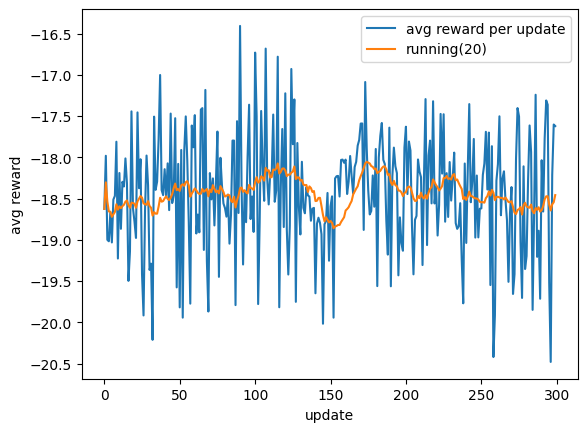

In [56]:
policy, value, logs = train_reinforce_vonmises(
    evaluate_qaoa_wrapped,
    n_updates=300,
    samples_per_update=256,
    eval_repeats=8,
    policy_lr=1e-4,
    value_lr=1e-3,
    entropy_coef=0.01,
    init_kappa=3.0,
    print_every=10
)

In [57]:
# inspect learned parameters (call after training)
mu = policy.mu.detach().cpu().numpy()           # raw learned means (radians)
kappa = policy.kappa.detach().cpu().numpy()     # concentration (higher -> narrower)
# wrap to [0, 2*pi)
mu_wrapped = (mu + 2*np.pi) % (2*np.pi)

beta = mu_wrapped[0]
gamma = mu_wrapped[1]

print(f"raw mu = {mu}")
print(f"wrapped mu (0..2pi) => beta={beta:.6f} rad, gamma={gamma:.6f} rad")
print(f"beta (deg) = {beta*180/np.pi:.3f}°, gamma (deg) = {gamma*180/np.pi:.3f}°")
print("kappa =", kappa)

# High-precision final evaluation (reduce noise by averaging many evals)
final_reward = evaluate_qaoa_wrapped([beta, gamma], n_repeats=200)  # large n_repeats for stable estimate
final_energy = -final_reward
print(f"final avg reward (n=200) = {final_reward:.6f}  => approx energy = {final_energy:.6f}")

raw mu = [ 0.01474795 -0.00945206]
wrapped mu (0..2pi) => beta=0.014748 rad, gamma=6.273734 rad
beta (deg) = 0.845°, gamma (deg) = 359.458°
kappa = [2.972294  2.9829612]
final avg reward (n=200) = -10.875117  => approx energy = 10.875117


## Limitations of REINFORCE for QAOA Parameter Optimization

## Experiment Setup

We tested the REINFORCE algorithm to optimize QAOA parameters for a toy problem with known optimal values:

* **True optimal parameters:**

  - $\beta = \pi/3$
  * $\gamma = \pi$

* **Policy distribution:** Von Mises for periodicity of angles.

* **Training setup:**

  * 300 updates
  * 32 samples per update
  * Value baseline included
  * Entropy regularization with exponential decay

## Observations

* The **reward curve was very noisy** with large fluctuations across updates.
* The final learned parameters were:

  * $\beta \approx 0.015$ rad
  * $\gamma \approx 6.27$ rad
* These values are **far from the ground truth** $(\pi/3, \pi)$
* Final average reward was (-10.87), corresponding to a high energy (poor solution).

## Diagnosis: Why REINFORCE Struggled

1. **High-variance gradient estimates:**

   * REINFORCE relies purely on sampled returns, which makes its gradient estimates very noisy, especially with small batch sizes.

2. **Exploration issues:**

   * The Von Mises distribution starts broad low $\kappa$, leading to uninformative updates.
   * As entropy regularization decays, the policy collapses to a narrow mode near a boundary instead of exploring more effectively.

3. **Poor sample efficiency:**

   * With only 32 samples per update, each gradient step had limited information.
   * This makes convergence slow and unstable.

4. **Local minima and symmetries in the QAOA landscape:**

   * The cost landscape has many local minima and periodic structure.
   * REINFORCE has no mechanism to escape suboptimal basins once exploration is reduced.

5. **Baseline instability:**

   * The value function baseline reduced variance somewhat, but did not stabilize training enough to guide convergence.

## Conclusion

REINFORCE proved unsuitable for this problem setup:

* It converged to the wrong parameter regime.
* It showed high variance and poor sample efficiency.
* It failed to exploit the structure of the QAOA cost landscape.

## Next Steps: Moving to A2C

Advantage Actor-Critic (A2C) provides a natural improvement:

* **Lower variance updates** by using synchronous advantage estimates.
* **Better bias/variance tradeoff** with value function learning.
* **Stability** through more frequent updates and better exploration control.

---

## Overview

**Advantage Actor-Critic (A2C)** is a synchronous variant of the **Actor-Critic** reinforcement learning algorithm. It combines the benefits of **policy-based** and **value-based** methods. A2C addresses instability and inefficiency issues found in traditional Actor-Critic approaches by using **synchronous updates** across multiple agents.

---

## Key Concepts

- **Actor**: Learns the policy function $\pi(a|s)$. It decides which action to take given a state.
- **Critic**: Learns the value function $V(s)$. It evaluates how good the current state (and policy) is.
- **Advantage Function**: Measures how much better an action is compared to the average (baseline):  
  $$
  A(s, a) = Q(s, a) - V(s)
  $$

---

## How A2C Works

1. **Multiple agents** (environments) run in parallel, each collecting trajectories of state, action, reward, and next state.
2. **Policy (Actor)** and **Value Function (Critic)** may share parameters or be updated jointly.
3. For each trajectory:
   - Compute the **value estimate** using the Critic.
   - Compute the **advantage**:
     $$A(s, a) = R - V(s)$$

     where $ R $ is the cumulative discounted return:
     $$
     R_t = \sum_{k=0}^{T-t} \gamma^k r_{t+k}
     $$
4. **Actor Update**:  
   Use the policy gradient:
   $$
   \nabla_\theta J = \mathbb{E} \left[ \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot A(s_t, a_t) \right]
   $$
5. **Critic Update**:  
   Minimize the mean squared error between predicted and actual return:
   $$
   L(\phi) = \left( R_t - V_\phi(s_t) \right)^2
   $$
6. **Entropy Bonus (optional)**:  
   Encourages exploration by adding an entropy term to the actor loss:
   $$
   L_{\text{actor}} = -\log \pi_\theta(a_t|s_t) \cdot A_t + \beta \cdot H(\pi_\theta(s_t))
   $$

---

## Pseudocode

```python
initialize policy network πθ(a|s) and value network Vϕ(s)

for iteration in range(max_iterations):
    collect trajectories from N environments:
        for each environment:
            store (s_t, a_t, r_t, s_{t+1}) for T steps

    compute returns R_t using discounted rewards

    for each time step t:
        A_t = R_t - Vϕ(s_t)  # compute advantage

    update actor:
        θ ← θ + α_actor * ∇θ log πθ(a_t|s_t) * A_t

    update critic:
        ϕ ← ϕ - α_critic * ∇ϕ (R_t - Vϕ(s_t))²

    (optional) add entropy bonus to actor loss
```

In the next experiment, we will implement A2C for the same QAOA optimization problem to test whether it achieves more stable convergence to the true optimal parameters.



In [58]:
# Learnable Gaussian policy for continuous actions

class SimpleGaussianPolicy(nn.Module):
    """Simple Gaussian policy - no wrapping in forward pass to preserve gradients"""
    def __init__(self, init_mean=None, init_log_std=-0.5):
        super().__init__()
        if init_mean is None:
            init_mean = torch.rand(2) * 2 * np.pi
        else:
            init_mean = torch.tensor(init_mean, dtype=torch.float32)
        
        self.mu = nn.Parameter(init_mean)
        self.log_std = nn.Parameter(torch.ones(2) * init_log_std)
    
    def forward(self, deterministic=False):
        """Sample without wrapping to preserve gradients"""
        mu = self.mu
        std = torch.exp(self.log_std).clamp(min=0.05, max=0.8)
        
        if deterministic:
            # Wrap only for output
            return torch.remainder(mu, 2 * np.pi), None
        
        dist = Normal(mu, std)
        action = dist.rsample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        
        return action, log_prob
    
    def get_std(self):
        return torch.exp(self.log_std).clamp(min=0.05, max=0.8)

In [59]:
# Neural network for state-value estimation

class ValueNet(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )
    
    def forward(self, state):
        return self.net(state).squeeze(-1)

Trains an A2C agent to optimize QAOA angles using a learnable Gaussian policy.
    
- `evaluate_fn` provides the reward for given angles $(\beta, \gamma)$.
- The policy (actor) samples angle parameters; the value net (critic) estimates expected returns.
- Rewards are used to compute advantages: $A(s) = R - V(s)$.
- Policy and value networks are updated using gradient descent.
- Includes entropy regularization to encourage exploration.
- Tracks and plots performance over time, including convergence to target angles.
    
Returns:
    policy: trained policy network
    value: trained value network
    rewards_history: list of average rewards during training
    best_params: best found (wrapped) angles with highest reward

In [60]:
# A2C training loop for QAOA parameter optimization

def train_a2c_qaoa(
    evaluate_fn,
    n_updates=2000,
    batch_size=32,
    eval_repeats=5,
    policy_lr=5e-3,
    value_lr=1e-2,
    entropy_coef=0.02,
    value_coef=0.5,
    max_grad_norm=1.0,
    init_std=0.5,
    print_every=100
):
    """A2C for QAOA"""
    # Start close to target
    init_mean = [1.5, 3.0]
    
    policy = SimpleGaussianPolicy(init_mean=init_mean, init_log_std=np.log(init_std)).to(DEVICE)
    value = ValueNet().to(DEVICE)
    
    policy_optimizer = optim.Adam(policy.parameters(), lr=policy_lr)
    value_optimizer = optim.Adam(value.parameters(), lr=value_lr)
    
    rewards_history = []
    best_reward = -float('inf')
    best_params = None
    mu_history = []
    
    for update in range(1, n_updates + 1):
        actions_list = []
        log_probs_list = []
        rewards_list = []
        
        for _ in range(batch_size):
            # Sample action (no wrapping here)
            action, log_prob = policy.forward(deterministic=False)
            
            # Wrap for evaluation only
            action_wrapped = torch.remainder(action, 2 * np.pi)
            action_np = action_wrapped.detach().cpu().numpy()
            reward = evaluate_fn(action_np.tolist(), n_repeats=eval_repeats)
            
            actions_list.append(action)  # Store unwrapped for value network
            log_probs_list.append(log_prob)
            rewards_list.append(reward)
            
            if reward > best_reward:
                best_reward = reward
                best_params = action_np.copy()
        
        actions = torch.stack(actions_list)
        log_probs = torch.stack(log_probs_list)
        rewards = torch.FloatTensor(rewards_list).to(DEVICE)
        
        # Value and advantages
        values = value(actions.detach())
        advantages = rewards - values.detach()
        
        if batch_size > 1:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Policy loss
        policy_loss = -(log_probs * advantages).mean()
        
        # Entropy
        std = policy.get_std()
        entropy = 0.5 * torch.log(2 * np.pi * np.e * std**2).sum()
        entropy_loss = -entropy_coef * entropy
        
        total_policy_loss = policy_loss + entropy_loss
        
        # Update policy
        policy_optimizer.zero_grad()
        total_policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_grad_norm)
        policy_optimizer.step()
        
        # Value loss
        values_for_loss = value(actions.detach())
        value_loss = value_coef * nn.MSELoss()(values_for_loss, rewards)
        
        # Update value
        value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(value.parameters(), max_grad_norm)
        value_optimizer.step()
        
        # Logging
        avg_reward = rewards.mean().item()
        max_reward = rewards.max().item()
        rewards_history.append(avg_reward)
        
        with torch.no_grad():
            current_mu = torch.remainder(policy.mu, 2 * np.pi).cpu().numpy()
            mu_history.append(current_mu.copy())
        
        if update % print_every == 0 or update == 1:
            std_vals = policy.get_std().detach().cpu().numpy()
            print(f"[Update {update}/{n_updates}]")
            print(f"  avg={avg_reward:.4f} | max={max_reward:.4f} | best={best_reward:.4f}")
            print(f"  μ=[{current_mu[0]:.4f}, {current_mu[1]:.4f}] | σ=[{std_vals[0]:.3f}, {std_vals[1]:.3f}]")
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Rewards
    axes[0, 0].plot(rewards_history, alpha=0.3)
    rolling = pd.Series(rewards_history).rolling(window=100, min_periods=1).mean()
    axes[0, 0].plot(rolling.values, linewidth=2, label='rolling mean')
    axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='optimal')
    axes[0, 0].set_xlabel("update")
    axes[0, 0].set_ylabel("avg reward")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_title("Training Progress")
    
    # Parameter convergence
    mu_history = np.array(mu_history)
    axes[0, 1].plot(mu_history[:, 0], label='β (learned)', linewidth=2)
    axes[0, 1].axhline(y=np.pi/3, color='r', linestyle='--', label='β target', linewidth=2)
    axes[0, 1].plot(mu_history[:, 1], label='γ (learned)', linewidth=2)
    axes[0, 1].axhline(y=np.pi, color='b', linestyle='--', label='γ target', linewidth=2)
    axes[0, 1].set_xlabel("update")
    axes[0, 1].set_ylabel("parameter (rad)")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_title("Parameter Convergence")
    
    # Parameter space
    axes[1, 0].scatter([np.pi/3], [np.pi], s=300, c='red', marker='*', 
                      label='Target', zorder=5, edgecolors='black', linewidth=2)
    if best_params is not None:
        axes[1, 0].scatter([best_params[0]], [best_params[1]], s=200, c='green', 
                          marker='o', label='Best found', zorder=4, edgecolors='black', linewidth=2)
    with torch.no_grad():
        mean_action, _ = policy.forward(deterministic=True)
        mean_params = mean_action.cpu().numpy()
    axes[1, 0].scatter([mean_params[0]], [mean_params[1]], s=150, c='blue', 
                      marker='s', label='Final mean', zorder=3, alpha=0.8)
    
    subsample = max(1, len(mu_history) // 50)
    axes[1, 0].plot(mu_history[::subsample, 0], mu_history[::subsample, 1], 
                   'k-', alpha=0.3, linewidth=1, label='Trajectory')
    
    axes[1, 0].set_xlabel("β (rad)")
    axes[1, 0].set_ylabel("γ (rad)")
    axes[1, 0].set_xlim([0, 2*np.pi])
    axes[1, 0].set_ylim([0, 2*np.pi])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_title("Parameter Space")
    
    # Error over time
    errors = np.sqrt((mu_history[:, 0] - np.pi/3)**2 + (mu_history[:, 1] - np.pi)**2)
    axes[1, 1].plot(errors, linewidth=2, color='purple')
    axes[1, 1].set_xlabel("update")
    axes[1, 1].set_ylabel("L2 distance to optimum (rad)")
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_title("Convergence")
    axes[1, 1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    return policy, value, rewards_history, best_params

Training A2C for QAOA parameter optimization
Target: β = π/3 ≈ 1.047 rad (60°), γ = π ≈ 3.142 rad (180°)
[Update 1/2000]
  avg=-0.7781 | max=-0.0126 | best=-0.0126
  μ=[1.5000, 3.0000] | σ=[0.503, 0.503]
[Update 100/2000]
  avg=-1.0368 | max=-0.0148 | best=0.0281
  μ=[1.5000, 3.0000] | σ=[0.800, 0.800]
[Update 200/2000]
  avg=-3.8492 | max=-0.0933 | best=0.0385
  μ=[1.5000, 3.0000] | σ=[0.800, 0.800]
[Update 300/2000]
  avg=-1.7904 | max=0.0060 | best=0.0401
  μ=[1.5000, 3.0000] | σ=[0.800, 0.800]
[Update 400/2000]
  avg=-1.6477 | max=-0.0639 | best=0.0409
  μ=[1.5000, 3.0000] | σ=[0.800, 0.800]
[Update 500/2000]
  avg=-2.7225 | max=-0.1031 | best=0.0409
  μ=[1.5000, 3.0000] | σ=[0.800, 0.800]
[Update 600/2000]
  avg=-2.9769 | max=-0.2484 | best=0.0409
  μ=[1.5000, 3.0000] | σ=[0.800, 0.800]
[Update 700/2000]
  avg=-2.7639 | max=0.0262 | best=0.0409
  μ=[1.5000, 3.0000] | σ=[0.800, 0.800]
[Update 800/2000]
  avg=-2.5212 | max=-0.0780 | best=0.0464
  μ=[1.5000, 3.0000] | σ=[0.800, 0.800

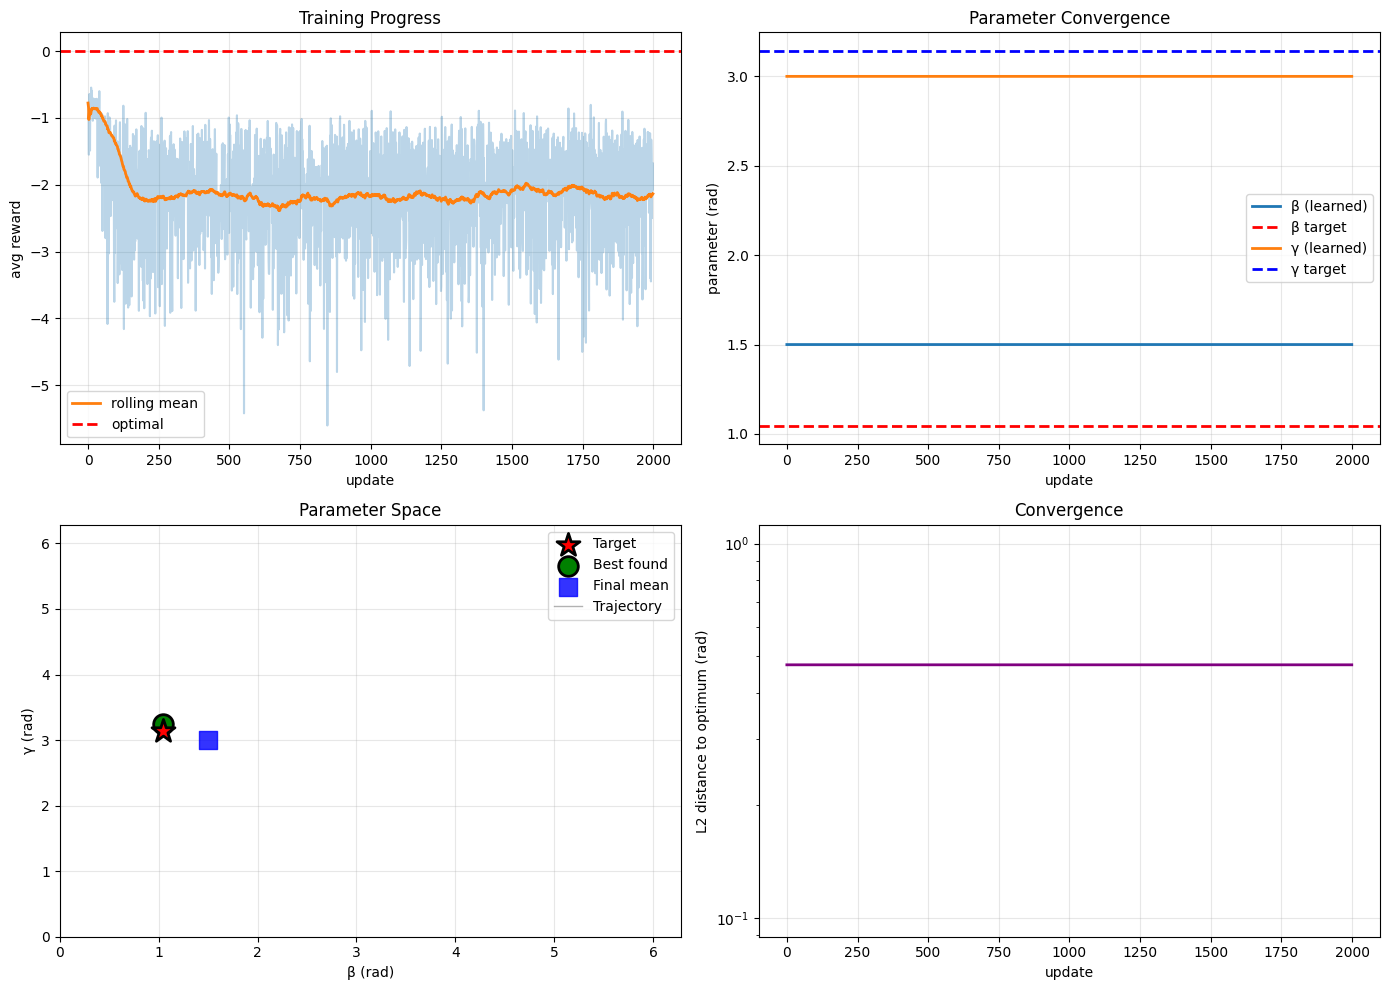


FINAL RESULTS

Policy mean (for deployment):
  β = 1.500000 rad = 85.94° (target: 60.00°)
  γ = 3.000000 rad = 171.89° (target: 180.00°)
  σ = [0.800, 0.800]

Best sample during training:
  β = 1.046915 rad = 59.98°
  γ = 3.244500 rad = 185.90°

Evaluation (n=200):
  Policy mean: reward=-0.223459, energy=0.223459
  Best sample: reward=0.064011, energy=-0.064011

Errors (policy mean):
  |β - β*| = 0.452802 rad = 25.94°
  |γ - γ*| = 0.141593 rad = 8.11°
  L2 error = 0.474424 rad


In [61]:
# Final output

print("Training A2C for QAOA parameter optimization")
print("Target: β = π/3 ≈ 1.047 rad (60°), γ = π ≈ 3.142 rad (180°)")
print("="*60)

policy, value, logs, best_params = train_a2c_qaoa(
    evaluate_qaoa_wrapped,
    n_updates=2000,
    batch_size=32,
    eval_repeats=5,
    policy_lr=5e-3,
    value_lr=1e-2,
    entropy_coef=0.02,
    init_std=0.5,
    print_every=100
)

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)

with torch.no_grad():
    mean_action, _ = policy.forward(deterministic=True)
    mean_params = mean_action.cpu().numpy()
    std_vals = policy.get_std().detach().cpu().numpy()

beta_mean, gamma_mean = mean_params

print(f"\nPolicy mean (for deployment):")
print(f"  β = {beta_mean:.6f} rad = {beta_mean*180/np.pi:.2f}° (target: 60.00°)")
print(f"  γ = {gamma_mean:.6f} rad = {gamma_mean*180/np.pi:.2f}° (target: 180.00°)")
print(f"  σ = [{std_vals[0]:.3f}, {std_vals[1]:.3f}]")

print(f"\nBest sample during training:")
print(f"  β = {best_params[0]:.6f} rad = {best_params[0]*180/np.pi:.2f}°")
print(f"  γ = {best_params[1]:.6f} rad = {best_params[1]*180/np.pi:.2f}°")

final_reward_mean = evaluate_qaoa_wrapped(mean_params.tolist(), n_repeats=200)
final_reward_best = evaluate_qaoa_wrapped(best_params.tolist(), n_repeats=200)

print(f"\nEvaluation (n=200):")
print(f"  Policy mean: reward={final_reward_mean:.6f}, energy={-final_reward_mean:.6f}")
print(f"  Best sample: reward={final_reward_best:.6f}, energy={-final_reward_best:.6f}")

beta_error_mean = abs(beta_mean - np.pi/3)
gamma_error_mean = abs(gamma_mean - np.pi)

print(f"\nErrors (policy mean):")
print(f"  |β - β*| = {beta_error_mean:.6f} rad = {beta_error_mean*180/np.pi:.2f}°")
print(f"  |γ - γ*| = {gamma_error_mean:.6f} rad = {gamma_error_mean*180/np.pi:.2f}°")
print(f"  L2 error = {np.sqrt(beta_error_mean**2 + gamma_error_mean**2):.6f} rad")

## When A2C Fails to Update the Policy

In the above we encountered a failure:

- The **best-performing parameters** (actions) sampled during training **were indeed close to optimal**.
- However, the **policy's mean $\mu$ did not change at all** during training and $\sigma$ was also stuck.
- This indicates that **the gradient signal was effectively zero**, or too small to cause meaningful updates.

### What Happened?

A2C uses the following policy gradient loss:

$$
\mathcal{L}_{\text{policy}} = -\log \pi_\theta(a_t | s_t) \cdot A_t
$$

If the **advantages $A_t $** are noisy or poorly estimated (e.g., when using unwrapped angles), and the log-probability gradient is flat (common with sharp Gaussians or when action falls in tails), the **gradient can vanish**. This causes the policy to "freeze," even if it samples good actions by chance.

---

## Enter Proximal Policy Optimization (PPO)

**Proximal Policy Optimization (PPO)** is a more stable and robust alternative to vanilla A2C.

It introduces a **clipped objective** to ensure that the policy does not update too aggressively, while still encouraging improvement.

### Core Idea

PPO uses the ratio of the new policy to the old policy:

$$
r_t(\theta) = \frac{\pi_\theta(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)}
$$

Then it optimizes the **clipped surrogate objective**:

$$
\mathcal{L}_{\text{PPO}} = \mathbb{E}_t \left[ \min \left( r_t(\theta) A_t, \ \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t \right) \right]
$$

Where:
- $ \epsilon $ is a small hyperparameter (e.g., 0.2).
- $ A_t $ is the advantage estimate.
- The `clip` function prevents the policy from changing too much in a single step.

### Why This Helps

- The **clipping** ensures **small but reliable updates** to the policy.
- It avoids the issue of the **policy becoming overconfident** and ignoring the gradient.
- PPO is more **resilient to noisy or sparse advantages**, which is critical when optimizing low-dimensional but sensitive parameters like QAOA angles.

---

Below we implement a PPO Algorithm on our dummy data

In [62]:
### PPO
class PPOPolicy(nn.Module):
    """Policy network that outputs mean and log_std"""
    def __init__(self, init_mean=None, init_log_std=-0.7):
        super().__init__()
        if init_mean is None:
            init_mean = [2.0, 3.5]
        
        # Direct parameters (not a neural network for this simple case)
        self.mu = nn.Parameter(torch.tensor(init_mean, dtype=torch.float32))
        self.log_std = nn.Parameter(torch.ones(2) * init_log_std)
    
    def forward(self):
        mu = self.mu
        std = torch.exp(self.log_std).clamp(min=0.1, max=0.7)
        return mu, std
    
    def get_action_and_log_prob(self, deterministic=False):
        mu, std = self.forward()
        
        if deterministic:
            action = mu
            return action, None
        
        dist = Normal(mu, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        
        return action, log_prob
    
    def evaluate_actions(self, actions):
        """Evaluate log prob of given actions under current policy"""
        mu, std = self.forward()
        dist = Normal(mu, std)
        log_probs = dist.log_prob(actions).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1)
        return log_probs, entropy

In [63]:
# NN for calculation
class PPOValueNet(nn.Module):
    """Value network for PPO"""
    def __init__(self, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )
    
    def forward(self, state):
        return self.net(state).squeeze(-1)

# Experience buffer due to multiple training epochs
class PPOBuffer:
    """Experience buffer for PPO"""
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        
    def store(self, state, action, reward, log_prob):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.log_probs.append(log_prob)
    
    def get(self):
        states = torch.stack(self.states)
        actions = torch.stack(self.actions)
        rewards = torch.FloatTensor(self.rewards).to(DEVICE)
        log_probs = torch.stack(self.log_probs)
        return states, actions, rewards, log_probs
    
    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []

In [64]:
# Training function
def train_ppo_qaoa(
    evaluate_fn,
    n_iterations=300,
    batch_size=64,
    eval_repeats=3,
    n_epochs=10,
    policy_lr=3e-3,
    value_lr=1e-2,
    clip_epsilon=0.2,
    entropy_coef=0.02,
    value_coef=0.5,
    max_grad_norm=0.5,
    gamma=0.0,  # No discounting for single-step problem
    gae_lambda=0.95,
    init_std=0.5,
    print_every=15
):
    """
    PPO for QAOA parameter optimization
    """
    init_mean = [1.2, 3.1]  # Start close to targets
    
    policy = PPOPolicy(init_mean=init_mean, init_log_std=np.log(init_std)).to(DEVICE)
    value_net = PPOValueNet().to(DEVICE)
    
    policy_optimizer = optim.Adam(policy.parameters(), lr=policy_lr)
    value_optimizer = optim.Adam(value_net.parameters(), lr=value_lr)
    
    buffer = PPOBuffer()
    
    rewards_history = []
    best_reward = -float('inf')
    best_params = None
    mu_history = []
    
    print("Training PPO for QAOA Parameter Optimization")
    print(f"Target: β = {np.pi/3:.4f} rad (60°), γ = {np.pi:.4f} rad (180°)")
    print("="*70)
    
    for iteration in range(1, n_iterations + 1):
        # Collect batch of experiences
        buffer.clear()
        
        for _ in range(batch_size):
            with torch.no_grad():
                action, log_prob = policy.get_action_and_log_prob()
                
            # Wrap for evaluation
            action_wrapped = torch.fmod(action, 2 * np.pi)
            action_wrapped = torch.where(action_wrapped < 0, 
                                        action_wrapped + 2 * np.pi, 
                                        action_wrapped)
            
            action_np = action_wrapped.cpu().numpy()
            reward = evaluate_fn(action_np.tolist(), n_repeats=eval_repeats)
            
            # Store unwrapped action for policy updates
            buffer.store(action, action, reward, log_prob)
            
            if reward > best_reward:
                best_reward = reward
                best_params = action_np.copy()
        
        # Get batch data
        states, actions, rewards, old_log_probs = buffer.get()
        
        # Compute advantages using values
        with torch.no_grad():
            values = value_net(states)
            advantages = rewards - values
            returns = rewards  # For single-step, returns = rewards
            
            # Normalize advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # PPO update for multiple epochs
        for epoch in range(n_epochs):
            # Evaluate actions under current policy
            new_log_probs, entropy = policy.evaluate_actions(actions)
            
            # Compute ratio for PPO
            ratio = torch.exp(new_log_probs - old_log_probs)
            
            # Clipped surrogate objective
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Entropy bonus
            entropy_loss = -entropy_coef * entropy.mean()
            
            total_policy_loss = policy_loss + entropy_loss
            
            # Update policy
            policy_optimizer.zero_grad()
            total_policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy.parameters(), max_grad_norm)
            policy_optimizer.step()
            
            # Value loss
            values_pred = value_net(states)
            value_loss = value_coef * nn.MSELoss()(values_pred, returns)
            
            # Update value network
            value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(value_net.parameters(), max_grad_norm)
            value_optimizer.step()
        
        # Logging
        avg_reward = rewards.mean().item()
        max_reward = rewards.max().item()
        rewards_history.append(avg_reward)
        
        with torch.no_grad():
            current_mu = torch.fmod(policy.mu, 2 * np.pi).cpu().numpy()
            current_mu = np.where(current_mu < 0, current_mu + 2 * np.pi, current_mu)
            mu_history.append(current_mu.copy())
            current_std = torch.exp(policy.log_std).clamp(min=0.1, max=0.7).cpu().numpy()
        
        if iteration % print_every == 0 or iteration == 1:
            print(f"[Iter {iteration:3d}] avg={avg_reward:7.4f} | max={max_reward:7.4f} | "
                  f"best={best_reward:7.4f} | μ=[{current_mu[0]:.3f},{current_mu[1]:.3f}] | "
                  f"σ=[{current_std[0]:.2f},{current_std[1]:.2f}]")
    
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    mu_history = np.array(mu_history)
    
    # Rewards
    axes[0, 0].plot(rewards_history, alpha=0.3, label='avg reward')
    rolling = pd.Series(rewards_history).rolling(window=20, min_periods=1).mean()
    axes[0, 0].plot(rolling.values, linewidth=2, label='rolling mean (20)')
    axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='optimal')
    axes[0, 0].set_xlabel("iteration")
    axes[0, 0].set_ylabel("avg reward")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_title("Training Progress")
    
    # Parameter convergence
    axes[0, 1].plot(mu_history[:, 0], label='β', linewidth=2, color='blue')
    axes[0, 1].axhline(y=np.pi/3, color='red', linestyle='--', label='β*', linewidth=2)
    axes[0, 1].plot(mu_history[:, 1], label='γ', linewidth=2, color='green')
    axes[0, 1].axhline(y=np.pi, color='orange', linestyle='--', label='γ*', linewidth=2)
    axes[0, 1].set_xlabel("iteration")
    axes[0, 1].set_ylabel("parameter (rad)")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_title("Parameter Convergence")
    
    # Parameter space
    axes[1, 0].scatter([np.pi/3], [np.pi], s=300, c='red', marker='*', 
                      label='Target', zorder=5, edgecolors='black', linewidth=2)
    if best_params is not None:
        axes[1, 0].scatter([best_params[0]], [best_params[1]], s=200, c='green', 
                          marker='o', label='Best found', zorder=4, edgecolors='black', linewidth=2)
    
    final_mu = mu_history[-1]
    axes[1, 0].scatter([final_mu[0]], [final_mu[1]], s=150, c='blue', 
                      marker='s', label='Final mean', zorder=3)
    
    subsample = max(1, len(mu_history) // 30)
    axes[1, 0].plot(mu_history[::subsample, 0], mu_history[::subsample, 1], 
                   'k-', alpha=0.3, linewidth=1.5, label='Trajectory')
    
    axes[1, 0].set_xlabel("β (rad)")
    axes[1, 0].set_ylabel("γ (rad)")
    axes[1, 0].set_xlim([0, 2*np.pi])
    axes[1, 0].set_ylim([0, 2*np.pi])
    axes[1, 0].legend(fontsize=9)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_title("Parameter Space")
    
    # Distance to optimum
    errors = np.sqrt((mu_history[:, 0] - np.pi/3)**2 + (mu_history[:, 1] - np.pi)**2)
    axes[1, 1].plot(errors, linewidth=2, color='purple')
    axes[1, 1].set_xlabel("iteration")
    axes[1, 1].set_ylabel("L2 distance to optimum (rad)")
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_title("Convergence to Optimum")
    
    plt.tight_layout()
    plt.show()
    
    return policy, value_net, rewards_history, best_params

Training PPO for QAOA Parameter Optimization
Target: β = 1.0472 rad (60°), γ = 3.1416 rad (180°)
[Iter   1] avg=-0.5509 | max=-0.0266 | best=-0.0266 | μ=[1.170,3.073] | σ=[0.49,0.49]
[Iter  15] avg=-0.3492 | max= 0.0184 | best= 0.0699 | μ=[1.200,3.060] | σ=[0.36,0.32]
[Iter  30] avg=-0.1243 | max= 0.0359 | best= 0.0699 | μ=[1.143,3.029] | σ=[0.32,0.21]
[Iter  45] avg=-0.1396 | max= 0.0353 | best= 0.1123 | μ=[1.158,2.967] | σ=[0.30,0.14]
[Iter  60] avg=-0.1944 | max= 0.0462 | best= 0.1123 | μ=[1.159,2.947] | σ=[0.31,0.11]
[Iter  75] avg=-0.1615 | max= 0.0154 | best= 0.1123 | μ=[1.116,2.959] | σ=[0.33,0.10]
[Iter  90] avg=-0.1546 | max= 0.0243 | best= 0.1123 | μ=[1.122,2.973] | σ=[0.30,0.10]
[Iter 105] avg=-0.1359 | max= 0.0165 | best= 0.1123 | μ=[1.122,2.946] | σ=[0.29,0.10]
[Iter 120] avg=-0.1186 | max= 0.0296 | best= 0.1123 | μ=[1.180,2.979] | σ=[0.28,0.10]
[Iter 135] avg=-0.1174 | max= 0.0377 | best= 0.1123 | μ=[1.170,2.963] | σ=[0.27,0.10]
[Iter 150] avg=-0.1564 | max= 0.0106 | best

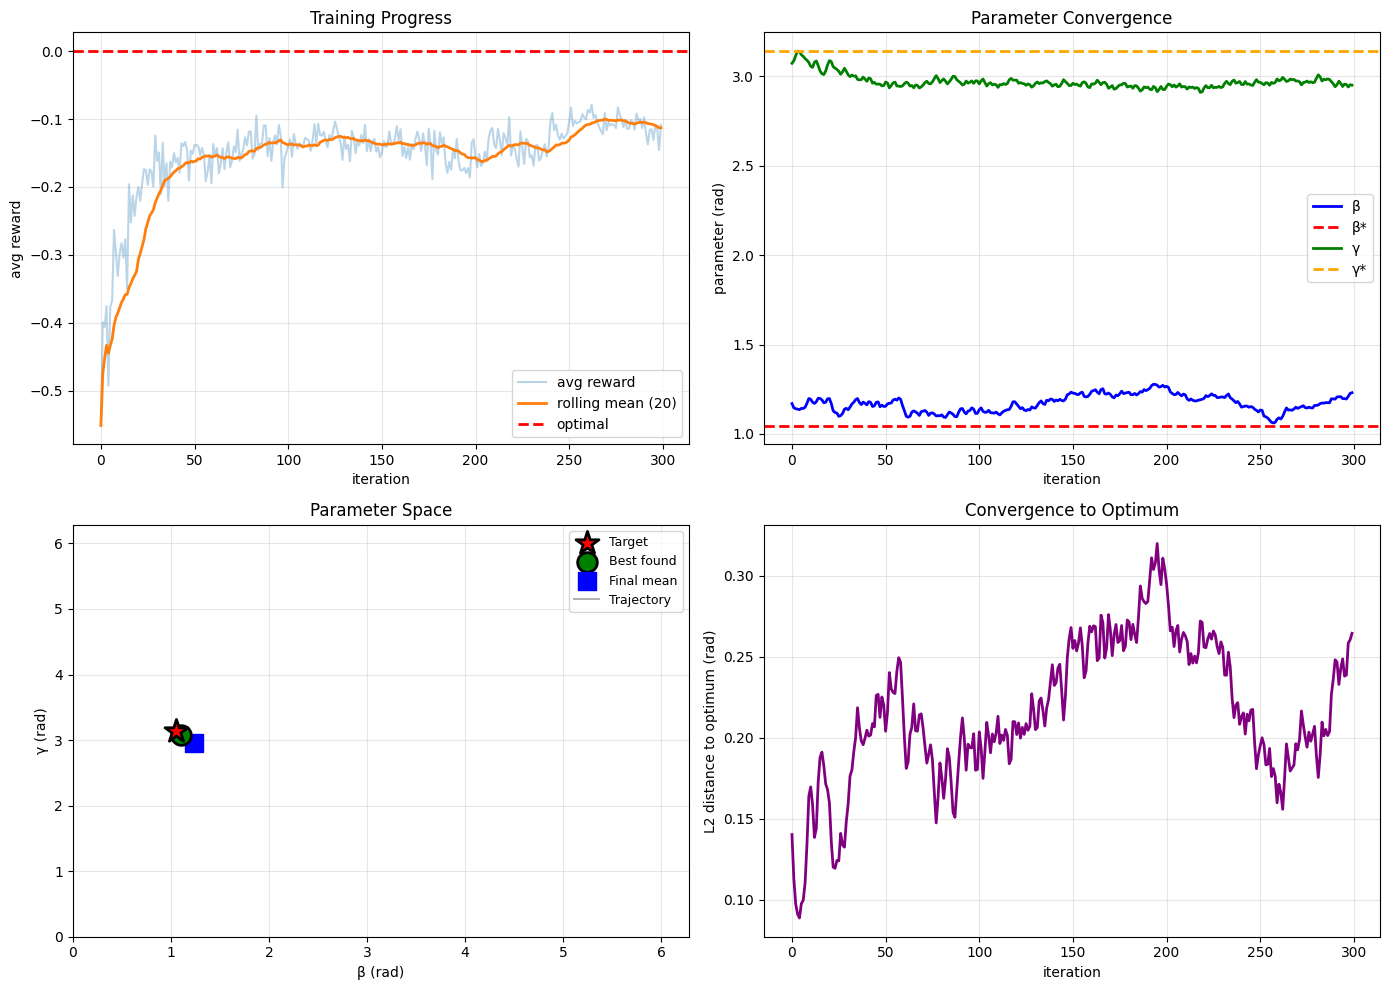


FINAL RESULTS

Policy mean (for deployment):
  β = 1.230492 rad = 70.50° (target: 60.00°, error: 10.50°)
  γ = 2.951046 rad = 169.08° (target: 180.00°, error: 10.92°)
  σ = [0.234, 0.100]

Best sample during training:
  β = 1.099881 rad = 63.02° (error: 3.02°)
  γ = 3.075128 rad = 176.19° (error: 3.81°)

Final evaluation (n=200):
  Policy mean: reward=-0.072028, energy=0.072028
  Best sample: reward=0.112334, energy=-0.112334

Recommendation: Use the best sample found during training
  β = 1.099881 rad, γ = 3.075128 rad


In [65]:
# Train PPO
policy, value_net, logs, best_params = train_ppo_qaoa(
    evaluate_qaoa_wrapped,
    n_iterations=300,
    batch_size=64,
    eval_repeats=3,
    n_epochs=10,
    policy_lr=3e-3,
    value_lr=1e-2,
    clip_epsilon=0.2,
    entropy_coef=0.02,
    init_std=0.5,
    print_every=15
)

print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)

with torch.no_grad():
    final_mu, final_std = policy.forward()
    mean_params = torch.fmod(final_mu, 2 * np.pi).cpu().numpy()
    mean_params = np.where(mean_params < 0, mean_params + 2 * np.pi, mean_params)
    std_vals = final_std.cpu().numpy()

print(f"\nPolicy mean (for deployment):")
print(f"  β = {mean_params[0]:.6f} rad = {mean_params[0]*180/np.pi:.2f}° "
      f"(target: 60.00°, error: {abs(mean_params[0]-np.pi/3)*180/np.pi:.2f}°)")
print(f"  γ = {mean_params[1]:.6f} rad = {mean_params[1]*180/np.pi:.2f}° "
      f"(target: 180.00°, error: {abs(mean_params[1]-np.pi)*180/np.pi:.2f}°)")
print(f"  σ = [{std_vals[0]:.3f}, {std_vals[1]:.3f}]")

print(f"\nBest sample during training:")
print(f"  β = {best_params[0]:.6f} rad = {best_params[0]*180/np.pi:.2f}° "
      f"(error: {abs(best_params[0]-np.pi/3)*180/np.pi:.2f}°)")
print(f"  γ = {best_params[1]:.6f} rad = {best_params[1]*180/np.pi:.2f}° "
      f"(error: {abs(best_params[1]-np.pi)*180/np.pi:.2f}°)")

final_reward_mean = evaluate_qaoa_wrapped(mean_params.tolist(), n_repeats=200)
final_reward_best = evaluate_qaoa_wrapped(best_params.tolist(), n_repeats=200)

print(f"\nFinal evaluation (n=200):")
print(f"  Policy mean: reward={final_reward_mean:.6f}, energy={-final_reward_mean:.6f}")
print(f"  Best sample: reward={final_reward_best:.6f}, energy={-final_reward_best:.6f}")

print(f"\nRecommendation: Use the best sample found during training")
print(f"  β = {best_params[0]:.6f} rad, γ = {best_params[1]:.6f} rad")

The above worked well, however it is clear that it converged fast due to the initial conditions. To conclude, we will look at changing initial conditions and seeing how PPO performs. When we try this using QAOA, we aim to do this by starting at multiple initial conditions and finding the best outcome.


=== Run 1 with init_mean = [0.0, 0.0] ===

Training PPO for QAOA Parameter Optimization
Target: β = 1.0472 rad (60°), γ = 3.1416 rad (180°)
[Iter   1] avg=-0.5203 | max= 0.0097 | best= 0.0097 | μ=[1.170,3.129] | σ=[0.49,0.49]
[Iter  15] avg=-0.1992 | max= 0.0421 | best= 0.0694 | μ=[1.076,3.147] | σ=[0.35,0.36]
[Iter  30] avg=-0.1538 | max= 0.0440 | best= 0.0694 | μ=[1.203,3.057] | σ=[0.24,0.22]
[Iter  45] avg=-0.0855 | max= 0.0263 | best= 0.0797 | μ=[1.154,3.065] | σ=[0.20,0.15]
[Iter  60] avg=-0.0820 | max= 0.0386 | best= 0.0797 | μ=[1.168,3.084] | σ=[0.19,0.11]
[Iter  75] avg=-0.0713 | max= 0.0305 | best= 0.0797 | μ=[1.220,3.056] | σ=[0.17,0.10]
[Iter  90] avg=-0.0355 | max= 0.0598 | best= 0.0819 | μ=[1.092,3.104] | σ=[0.15,0.10]
[Iter 105] avg=-0.0291 | max= 0.0690 | best= 0.0819 | μ=[1.102,3.099] | σ=[0.13,0.10]
[Iter 120] avg=-0.0365 | max= 0.0263 | best= 0.0912 | μ=[1.114,3.103] | σ=[0.11,0.10]
[Iter 135] avg=-0.0281 | max= 0.0228 | best= 0.0912 | μ=[1.118,3.100] | σ=[0.10,0.10]

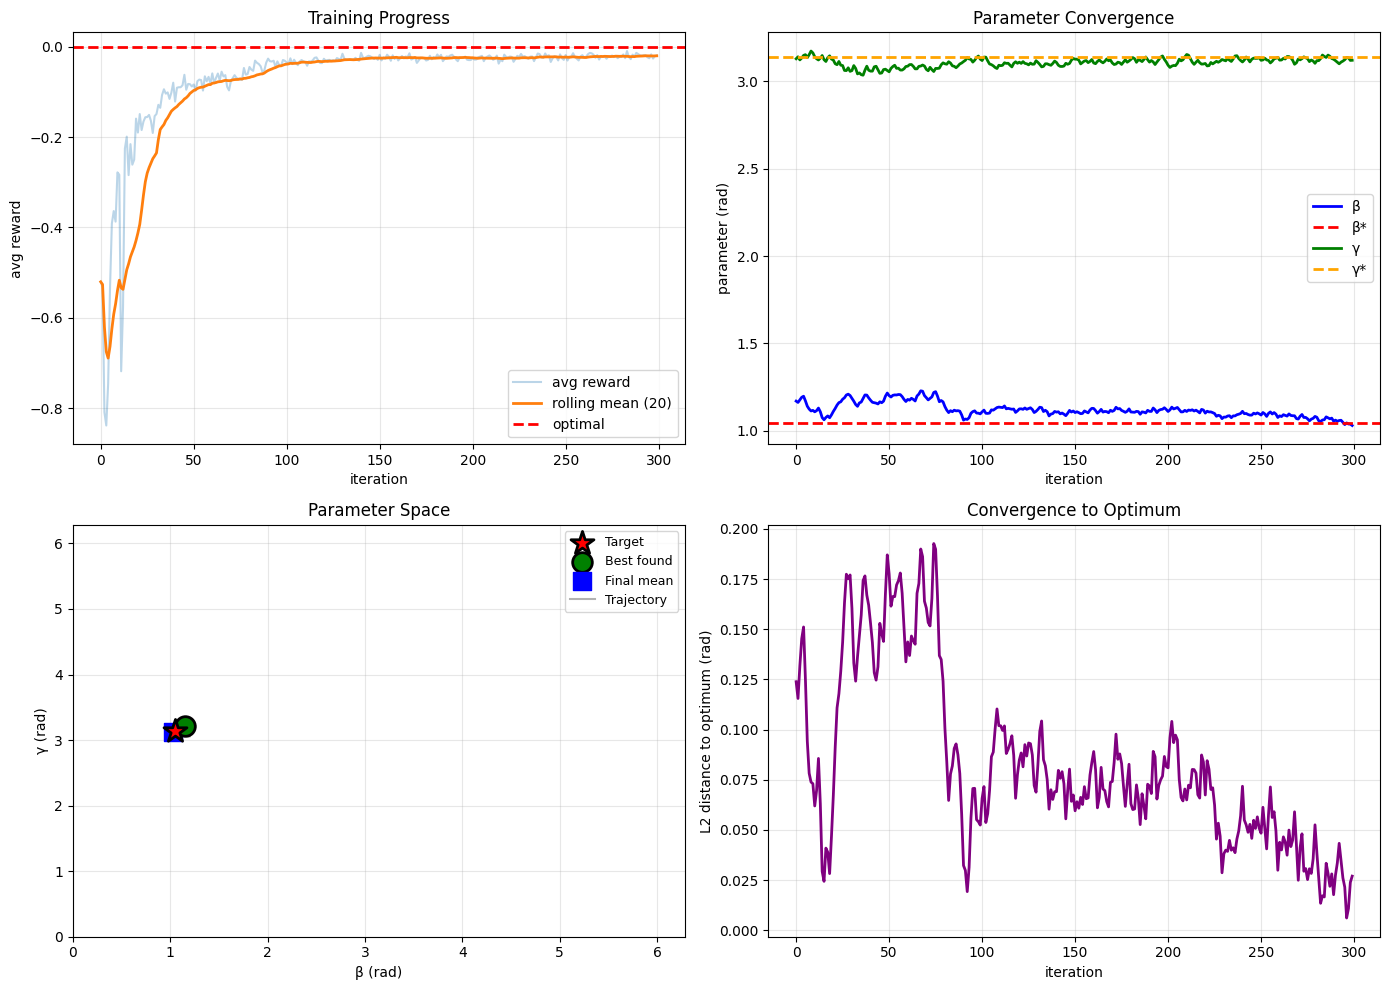


=== Run 2 with init_mean = [1.5707963267948966, 1.5707963267948966] ===

Training PPO for QAOA Parameter Optimization
Target: β = 1.0472 rad (60°), γ = 3.1416 rad (180°)
[Iter   1] avg=-0.5237 | max= 0.0115 | best= 0.0115 | μ=[1.170,3.080] | σ=[0.49,0.49]
[Iter  15] avg=-0.2590 | max= 0.0137 | best= 0.0657 | μ=[1.085,3.140] | σ=[0.33,0.34]
[Iter  30] avg=-0.1229 | max= 0.0210 | best= 0.0847 | μ=[1.052,3.021] | σ=[0.25,0.21]
[Iter  45] avg=-0.0774 | max= 0.0620 | best= 0.0847 | μ=[1.087,2.992] | σ=[0.22,0.15]
[Iter  60] avg=-0.0670 | max= 0.0362 | best= 0.0847 | μ=[1.016,3.028] | σ=[0.21,0.12]
[Iter  75] avg=-0.0652 | max= 0.0777 | best= 0.0849 | μ=[0.952,3.035] | σ=[0.19,0.10]
[Iter  90] avg=-0.0608 | max= 0.0495 | best= 0.0849 | μ=[0.975,3.024] | σ=[0.19,0.10]
[Iter 105] avg=-0.0439 | max= 0.0592 | best= 0.0849 | μ=[1.006,3.057] | σ=[0.17,0.10]
[Iter 120] avg=-0.0362 | max= 0.0531 | best= 0.0908 | μ=[0.997,3.052] | σ=[0.17,0.10]
[Iter 135] avg=-0.0511 | max= 0.0141 | best= 0.0908 | μ

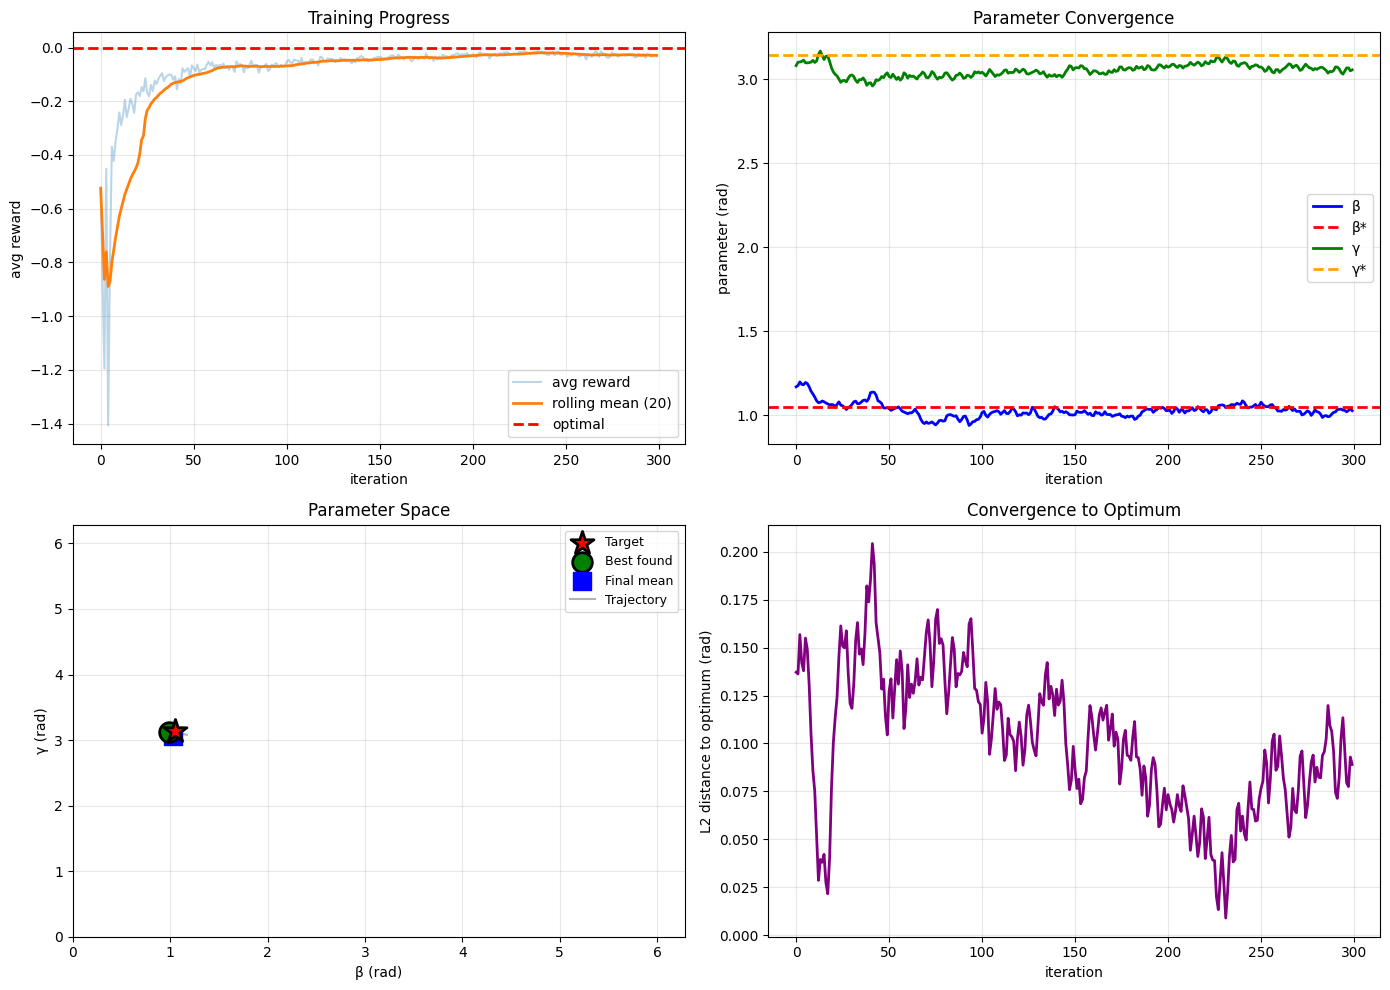


=== Run 3 with init_mean = [1.2, 3.1] ===

Training PPO for QAOA Parameter Optimization
Target: β = 1.0472 rad (60°), γ = 3.1416 rad (180°)
[Iter   1] avg=-0.6059 | max= 0.0133 | best= 0.0133 | μ=[1.171,3.129] | σ=[0.49,0.49]
[Iter  15] avg=-0.2333 | max= 0.0401 | best= 0.0544 | μ=[1.149,3.058] | σ=[0.35,0.33]
[Iter  30] avg=-0.1681 | max= 0.0204 | best= 0.0862 | μ=[1.090,3.006] | σ=[0.31,0.21]
[Iter  45] avg=-0.1254 | max= 0.0567 | best= 0.0862 | μ=[1.153,2.946] | σ=[0.28,0.14]
[Iter  60] avg=-0.1362 | max= 0.0351 | best= 0.0862 | μ=[1.039,2.980] | σ=[0.27,0.11]
[Iter  75] avg=-0.1064 | max= 0.0223 | best= 0.0862 | μ=[1.035,2.988] | σ=[0.27,0.10]
[Iter  90] avg=-0.1145 | max= 0.0364 | best= 0.0862 | μ=[0.992,2.971] | σ=[0.27,0.10]
[Iter 105] avg=-0.0893 | max= 0.0290 | best= 0.0862 | μ=[0.978,3.005] | σ=[0.25,0.10]
[Iter 120] avg=-0.1019 | max= 0.0226 | best= 0.0888 | μ=[0.937,3.000] | σ=[0.25,0.10]
[Iter 135] avg=-0.0848 | max= 0.0668 | best= 0.0888 | μ=[0.962,2.999] | σ=[0.24,0.10]

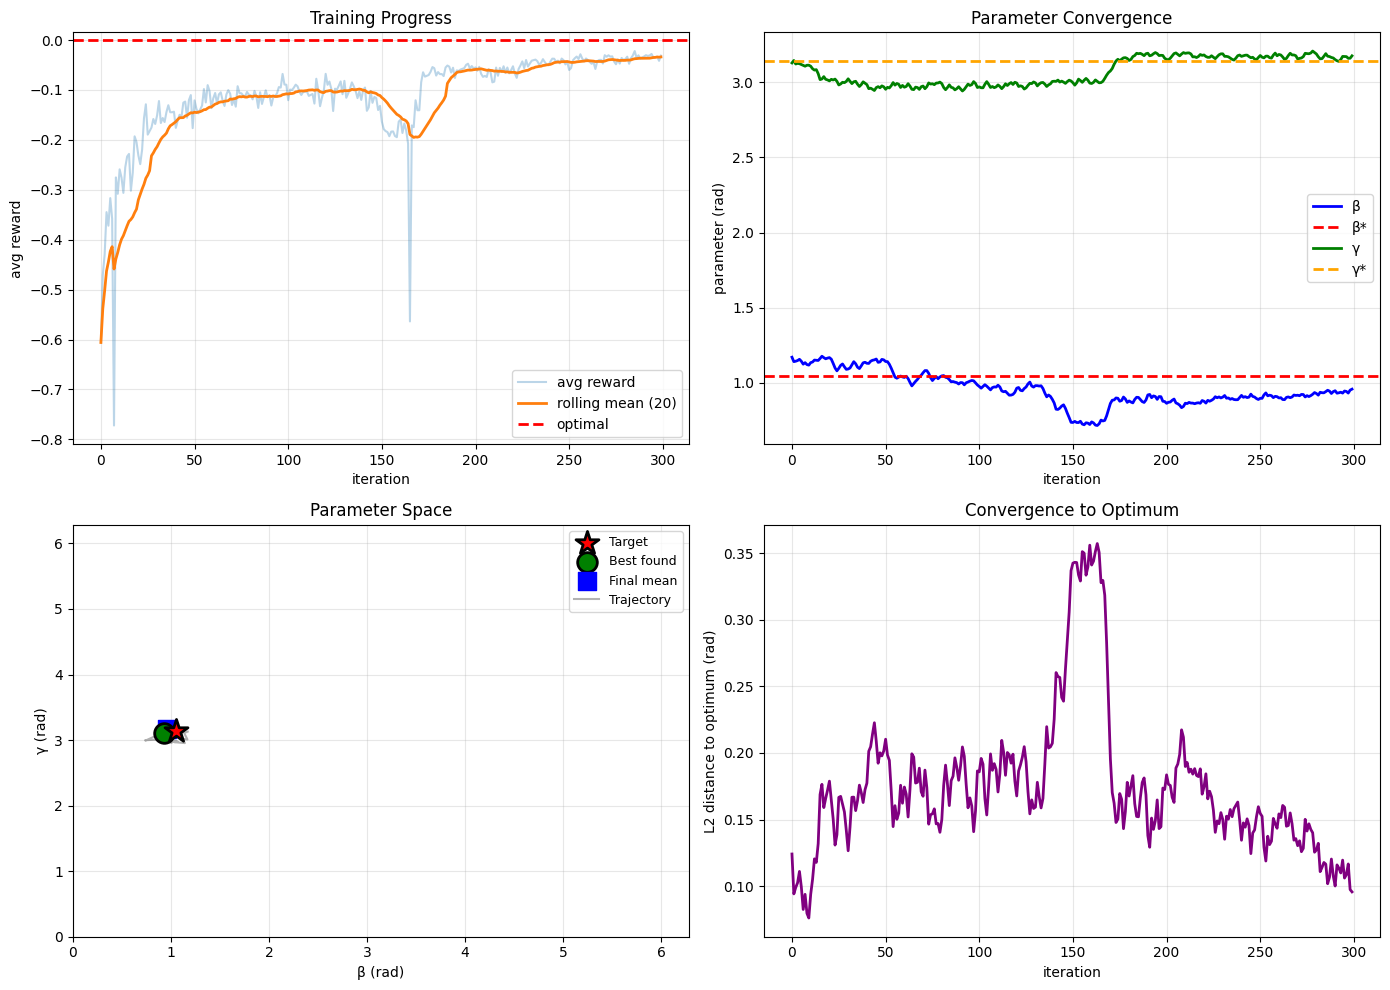


=== Run 4 with init_mean = [2.0, 4.0] ===

Training PPO for QAOA Parameter Optimization
Target: β = 1.0472 rad (60°), γ = 3.1416 rad (180°)
[Iter   1] avg=-0.7916 | max= 0.0082 | best= 0.0082 | μ=[1.224,3.074] | σ=[0.49,0.49]
[Iter  15] avg=-0.2725 | max= 0.0544 | best= 0.0583 | μ=[1.219,3.073] | σ=[0.35,0.30]
[Iter  30] avg=-0.1516 | max= 0.0180 | best= 0.0590 | μ=[1.131,3.032] | σ=[0.30,0.21]
[Iter  45] avg=-0.1103 | max= 0.0262 | best= 0.0640 | μ=[1.118,3.045] | σ=[0.26,0.14]
[Iter  60] avg=-0.0926 | max= 0.0206 | best= 0.0640 | μ=[0.973,3.073] | σ=[0.25,0.10]
[Iter  75] avg=-0.0739 | max= 0.0318 | best= 0.0794 | μ=[0.959,3.100] | σ=[0.25,0.10]
[Iter  90] avg=-0.0944 | max= 0.0247 | best= 0.0794 | μ=[0.898,3.072] | σ=[0.24,0.10]
[Iter 105] avg=-0.0940 | max= 0.0511 | best= 0.0794 | μ=[0.948,3.061] | σ=[0.25,0.10]
[Iter 120] avg=-0.0708 | max= 0.0433 | best= 0.0794 | μ=[1.014,3.102] | σ=[0.24,0.10]
[Iter 135] avg=-0.0741 | max= 0.0292 | best= 0.0794 | μ=[1.055,3.075] | σ=[0.24,0.10]

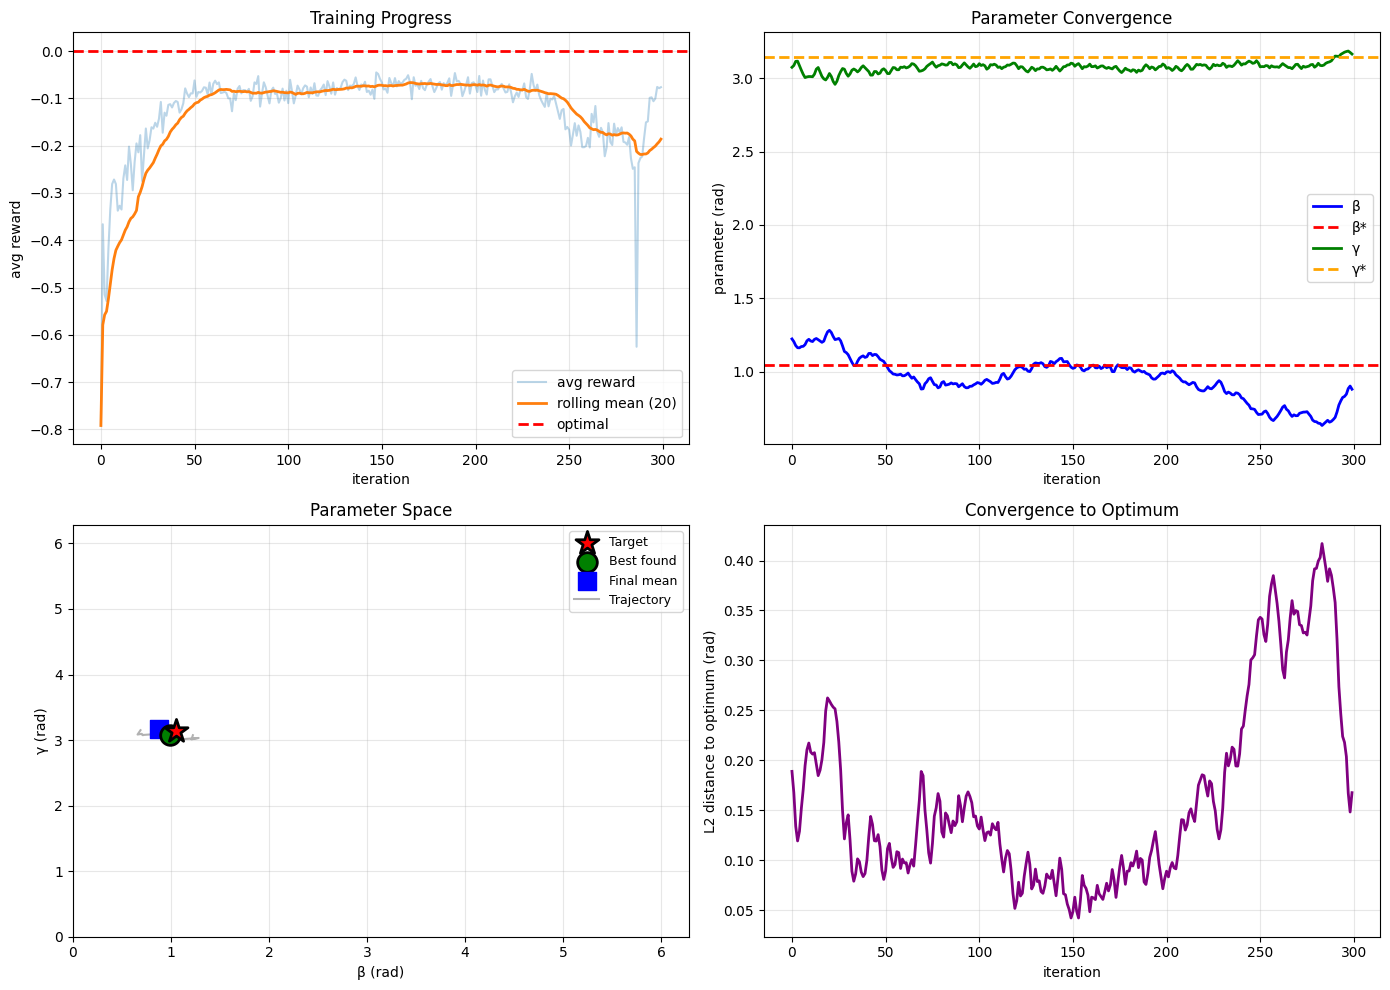


=== Run 5 with init_mean = [1.243174343218738, 1.74377214655517] ===

Training PPO for QAOA Parameter Optimization
Target: β = 1.0472 rad (60°), γ = 3.1416 rad (180°)
[Iter   1] avg=-0.5298 | max=-0.0457 | best=-0.0457 | μ=[1.172,3.128] | σ=[0.49,0.49]
[Iter  15] avg=-0.3032 | max=-0.0267 | best= 0.0310 | μ=[1.061,3.041] | σ=[0.35,0.35]
[Iter  30] avg=-0.1164 | max= 0.0374 | best= 0.0714 | μ=[1.056,3.082] | σ=[0.28,0.23]
[Iter  45] avg=-0.0719 | max= 0.0287 | best= 0.0714 | μ=[0.995,3.041] | σ=[0.24,0.16]
[Iter  60] avg=-0.0832 | max= 0.0385 | best= 0.0820 | μ=[1.052,3.052] | σ=[0.23,0.11]
[Iter  75] avg=-0.0657 | max= 0.0784 | best= 0.0820 | μ=[0.993,3.054] | σ=[0.22,0.10]
[Iter  90] avg=-0.0871 | max= 0.0411 | best= 0.0928 | μ=[0.937,3.047] | σ=[0.22,0.10]
[Iter 105] avg=-0.0674 | max= 0.0234 | best= 0.0928 | μ=[0.921,3.061] | σ=[0.21,0.10]
[Iter 120] avg=-0.0568 | max= 0.0836 | best= 0.0928 | μ=[0.896,3.082] | σ=[0.20,0.10]
[Iter 135] avg=-0.0903 | max= 0.0419 | best= 0.0928 | μ=[0

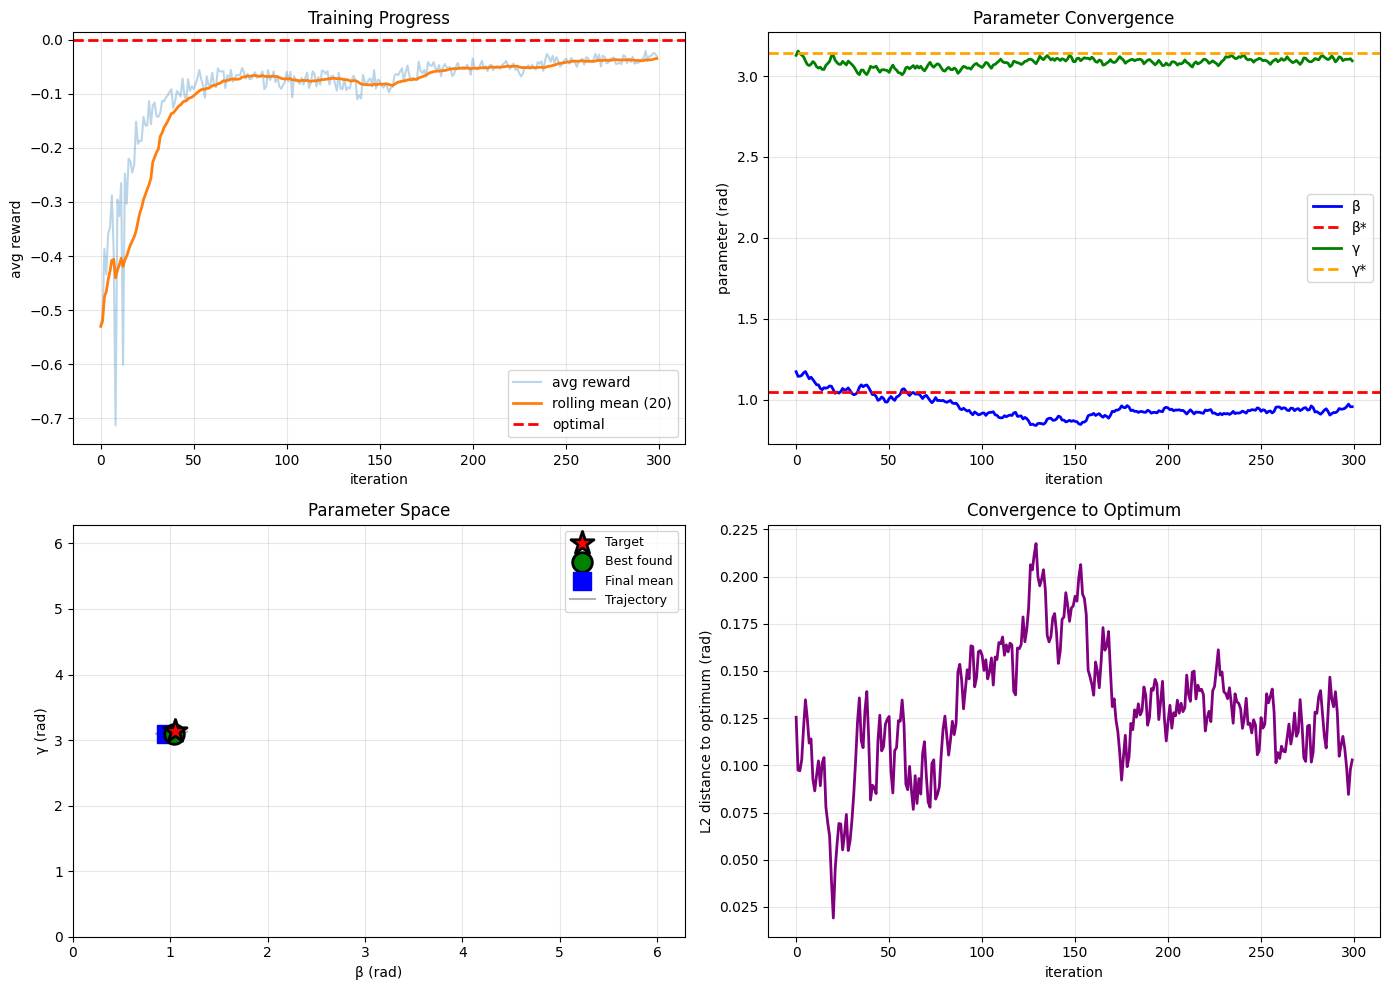

In [66]:
initial_guesses = [
    [0.0, 0.0],
    [np.pi / 2, np.pi / 2],
    [1.2, 3.1],  # current good start
    [2.0, 4.0],
    [np.random.uniform(0, 2*np.pi), np.random.uniform(0, 2*np.pi)]
]

best_result = None
best_reward = -np.inf

for i, init_mean in enumerate(initial_guesses):
    print(f"\n=== Run {i+1} with init_mean = {init_mean} ===\n")
    policy, value_net, logs, best_params = train_ppo_qaoa(
        evaluate_qaoa_wrapped,
        n_iterations=300,
        batch_size=64,
        eval_repeats=3,
        n_epochs=10,
        policy_lr=3e-3,
        value_lr=1e-2,
        clip_epsilon=0.2,
        entropy_coef=0.02,
        init_std=0.5,
        print_every=15
    )
    
    reward = evaluate_qaoa_wrapped(best_params.tolist(), n_repeats=200)
    
    if reward > best_reward:
        best_reward = reward
        best_result = best_params


PPO clearly works well and will be used in our version of optimising the parameters

---
## Comparison of Optimization Approaches for QAOA

### 1a. REINFORCE (Policy Gradient) Approach

**Pros:**

* **Simple and flexible:** Easy to implement for small parameter spaces.
* **Directly optimizes the policy:** Samples parameters from a distribution and updates towards higher rewards.
* **Handles stochastic objectives naturally:** Works well with noisy quantum simulations.
* **Extensible:** Can incorporate baselines, entropy bonuses, and guided updates to improve convergence.

**Cons:**

* **Sample inefficient:** Requires many evaluations to estimate gradients accurately.
* **High variance:** Gradient estimates can fluctuate significantly, especially in noisy settings.
* **Limited scalability:** For larger QAOA depths (p > 1), the parameter space grows linearly, and REINFORCE may converge very slowly.

### 1b. A2C (Advantage Actor-Critic)

**Pros:**

* **Reduces variance with a learned value function:** Uses a critic to estimate the baseline (value), improving the stability of policy gradient updates.
* **Supports continuous control:** Naturally works with parameterized continuous distributions like Gaussians (ideal for QAOA angles).
* **More sample-efficient than REINFORCE:** Learns from immediate rewards and advantage signals.
* **Simpler than asynchronous methods:** A2C is synchronous, easier to debug, and more deterministic than A3C.

**Cons:**

* **Still sensitive to gradient noise:** If the critic is inaccurate or gradients vanish (e.g. log-probs are flat), the policy may not update — even if good actions are sampled.
* **Failed in practice in our setting:** In our QAOA optimization, A2C found good parameters (via sampling) but **failed to move the policy mean**, as gradients were effectively zero.
* **Requires tuning and regularization:** Entropy bonuses, gradient clipping, and normalization are often needed to maintain exploration.


### 1c. PPO (Proximal Policy Optimization)

**Pros:**

* **Stable and reliable updates:** Uses a clipped surrogate objective to prevent destructive policy changes.
* **Better sample reuse:** Trains the policy for multiple epochs on the same data, improving efficiency.
* **Robust to noisy or sparse rewards:** Handles unstable advantage estimates better than A2C or REINFORCE.
* **Widely adopted:** PPO is a go-to algorithm in modern reinforcement learning libraries (e.g., Stable Baselines, CleanRL).

**Cons:**

* **More complex to implement:** Requires experience buffers, advantage normalization, and tracking old policies.
* **Hyperparameters matter:** Clipping threshold, epochs per batch, and batch size can significantly impact performance.
* **Slightly higher compute cost per update:** Due to multiple optimization epochs on each buffer.

**In our setting:** PPO helped **unstick the policy** — the clipped objective and multi-epoch training allowed the policy mean to shift meaningfully toward the optimal QAOA angles.

---

### 2. Bayesian Optimization (BO) Approach

**Pros:**

* **Sample efficient:** GP surrogate models help explore the parameter space intelligently, reducing the number of evaluations needed.
* **Handles noisy objectives:** Can incorporate measurement noise into the GP.
* **Works well for low-dimensional spaces:** Particularly effective when p=1 or other small-dimensional QAOA problems.
* **Provides uncertainty estimates:** GP predicts mean and variance, which can guide exploration vs exploitation.

**Cons:**

* **Scales poorly with dimensionality:** For larger p, the parameter space grows and GP-based BO becomes computationally expensive.
* **Kernel choice matters:** Periodicity and smoothness need to be accounted for; otherwise, GP predictions may be inaccurate.
* **Mostly offline optimization:** Does not learn a general policy for producing good parameters; it finds a single optimum per run.

---


**Conclusion:**

* For our **p=1 QAOA problem**, both PPO and BO are feasible.
* BO is more **sample-efficient** and converges quickly to the optimum.
* PPO also worked well but requires more testing, particularly in initial conditions and neural network architecture.


---

# Testing our best optimisers on real data

## Baseline models

We first show two baseline models that are more traditionally used

### Baseline Method 1 - COBYLA (Constrained Optimization BY Linear Approximations)

**COBYLA** is one of the most commonly used *gradient-free* optimizers for tuning the QAOA parameters $({\gamma}, {\beta})$.

#### Concept
COBYLA works by **building local linear approximations** of the objective function.
It does not require gradient information, making it ideal for quantum circuits where gradients are expensive or noisy to estimate.

#### How It Works
1. Start with an initial guess for $({\gamma}, {\beta})$.
2. Approximate the objective function locally using **linear models** based on nearby evaluations.
3. Update the parameters to minimize the linear approximation.
4. Gradually shrink the trust region (the neighborhood around the current point) as convergence improves.

This iterative process continues until convergence or a maximum number of iterations is reached.

#### Advantages
- **No gradients needed:** Perfect for noisy quantum hardware or stochastic objective functions.  
- **Simple to set up:** Only requires function evaluations, not derivatives.  
- **Robust for small parameter spaces:** Works well for low-depth QAOA (e.g., $p \le 3$).

#### Limitations
- **Scales poorly** with higher-dimensional parameter spaces (many QAOA layers).  
- May **converge slowly** compared to gradient-based optimizers if the landscape is smooth.  
- Sensitive to **initial parameter guesses**, especially in rugged optimization landscapes.

#### In QAOA
COBYLA is a traditional choice for finding optimal QAOA angles because:
- The energy landscape can be noisy or discontinuous due to finite sampling.
- Early QAOA experiments and simulators (e.g., in `Qiskit` and `Cirq`) often used COBYLA as the default classical optimizer.

In [57]:
# Used for all optimisers

def evaluate_qaoa(params, h, J, z_lin, z_pair, shots=4096, backend=None):
    """
    QAOA evaluation using QUBO energy with optional GPU acceleration
    """
    beta, gamma = params
    gammas = [gamma]
    betas = [beta]

    # Build circuit using provided Ising parameters
    qc = qaoa_circuit(z_lin, z_pair, gammas, betas, measure=False)
    
    # Get counts
    n = len(h)
    z_lin_dummy = np.zeros(n, dtype=float)
    z_pair_dummy = np.zeros((n, n), dtype=float)
    _, counts = estimate_expectation(qc, z_lin_dummy, z_pair_dummy, shots=shots, backend="aer")
    
    # Calculate QUBO energy
    best_key, best_E = None, float("inf")
    for s in counts.keys():
        E = energy_qubo_bitstring(s, h, J)
        if E < best_E:
            best_E, best_key = E, s
    
    return best_E

mu = np.array(mu_annual)
Sigma = np.array(sigma_annual)
v_levels = [0.0, 0.25, 0.5, 0.75, 1.0]
lam, A_onehot, B_budget = 2, 20.0, 20.0

In [58]:
# COBYLA

def cobyla_qaoa(h, J, z_lin, z_pair, shots=4096, n_repeats=3, maxiter=100):
    """
    COBYLA: Constrained Optimization BY Linear Approximation
    - Gradient-free method
    - Commonly used in early QAOA papers
    - Good for noisy objective functions
    """
    print("=" * 60)
    print("METHOD 1: COBYLA Optimization")
    print("=" * 60)
    
    eval_history = []
    param_history = []
    
    def objective(params):
        """Average multiple evaluations to reduce shot noise."""
        energies = [evaluate_qaoa(params, h, J, z_lin, z_pair, shots=shots, backend="aer") for _ in range(n_repeats)]
        avg_energy = float(np.mean(energies))
        
        eval_history.append(avg_energy)
        param_history.append(params.copy())
        
        if len(eval_history) % 10 == 0:
            print(f"Iteration {len(eval_history)}: E = {avg_energy:.6f}, "
                  f"β = {params[0]:.4f}, γ = {params[1]:.4f}")
        
        return avg_energy
    
    # Initial guess random
    x0 = np.array([np.pi/4, np.pi/4])
    
    # Bounds for COBYLA (as constraints)
    bounds = [(0, np.pi), (0, 2*np.pi)]
    
    result = minimize(
        fun=objective,
        x0=x0,
        method='COBYLA',
        options={'maxiter': maxiter, 'rhobeg': 0.5, 'tol': 1e-8}
    )
    
    print("\nCOBYLA Results:")
    print(f"  Best β  = {result.x[0]:.6f}")
    print(f"  Best γ  = {result.x[1]:.6f}")
    print(f"  Energy  = {result.fun:.6f}")
    print(f"  Iterations: {len(eval_history)}")
    print(f"  Success: {result.success}")
    
    return result, eval_history, param_history

### Baseline Method 2 -L-BFGS-B (Limited-memory Broyden–Fletcher–Goldfarb–Shanno – Bound constrained)

**L-BFGS-B** is a **quasi-Newton** optimization algorithm that efficiently estimates the curvature (second-order information) of the objective function to guide parameter updates.

#### Concept
L-BFGS-B is part of the **BFGS family** of optimizers, which approximate the inverse of the Hessian matrix (i.e., second derivatives) to perform Newton-like updates without explicitly computing the Hessian.

#### How It Works
1. Start with an initial parameter vector $theta_0 = ({\gamma}, {\beta})$.
2. Compute (or approximate) the gradient $\nabla E(\theta_k)$.
3. Use information from the **last few updates** (limited-memory) to estimate the inverse Hessian and compute a **search direction**.
4. Perform a **line search** along that direction to find the next point $\theta_{k+1}$.
5. Repeat until convergence or the maximum iteration limit.

The **“B”** in **L-BFGS-B** refers to its ability to handle **box constraints** on parameters (e.g., $\gamma_i \in [0, 2\pi]$, $\beta_i \in [0, \pi]$).

#### Advantages
- **Faster convergence** than gradient-free methods (like COBYLA) when gradients are available or can be estimated.
- **Memory-efficient:** Uses limited history instead of storing the full Hessian.
- Supports **parameter bounds**, which is useful for QAOA angle constraints.

#### Limitations
- Requires gradient information — either analytical (via the parameter-shift rule) or numerical (finite differences).  
- Can struggle in **noisy or highly non-smooth** objective landscapes.  
- More complex to tune compared to simpler gradient-free methods.

#### In QAOA
L-BFGS-B is often used in **simulated QAOA** (noiseless or low-noise environments) because it:
- Converges faster when the energy landscape is smooth.  
- Handles bounded parameter spaces naturally.  
- Can be combined with **parameter-shift gradients** for accurate updates.

In [59]:
# L-BFGS-B

def lbfgsb_qaoa(h, J, z_lin, z_pair, shots=4096, n_repeats=3, maxiter=100):
    """
    L-BFGS-B: Limited-memory BFGS with Bounds
    - Gradient-based (uses numerical gradients)
    - More efficient than COBYLA when gradients work well
    - Common choice in optimization literature
    """
    print("\n" + "=" * 60)
    print("METHOD 2: L-BFGS-B Optimization")
    print("=" * 60)
    
    eval_history = []
    param_history = []
    
    def objective(params):
        """Average multiple evaluations to reduce shot noise."""
        energies = [evaluate_qaoa(params, h, J, z_lin, z_pair, shots=shots, backend="aer") for _ in range(n_repeats)]
        avg_energy = float(np.mean(energies))
        
        eval_history.append(avg_energy)
        param_history.append(params.copy())
        
        if len(eval_history) % 10 == 0:
            print(f"Iteration {len(eval_history)}: E = {avg_energy:.6f}, "
                  f"β = {params[0]:.4f}, γ = {params[1]:.4f}")
        
        return avg_energy
    
    # Initial guess: common heuristic values
    x0 = np.array([np.pi/4, np.pi/4])
    
    # Bounds
    bounds = [(0, np.pi), (0, 2*np.pi)]
    
    result = minimize(
        fun=objective,
        x0=x0,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': maxiter, 'ftol': 1e-8}
    )
    
    print("\nL-BFGS-B Results:")
    print(f"  Best β  = {result.x[0]:.6f}")
    print(f"  Best γ  = {result.x[1]:.6f}")
    print(f"  Energy  = {result.fun:.6f}")
    print(f"  Iterations: {len(eval_history)}")
    print(f"  Success: {result.success}")
    
    return result, eval_history, param_history

### Nelder–Mead (Simplex Optimization)

**Nelder–Mead** is a **gradient-free** optimization algorithm that searches for the minimum of a function by evolving a **simplex** — a geometric figure with $n + 1$ vertices in an $n$-dimensional parameter space.

#### Concept
Instead of using gradients, Nelder–Mead evaluates the objective function at the vertices of a simplex and moves it around the search space based on function values.  

#### How It Works
At each iteration, Nelder–Mead:
1. **Evaluates** the objective function at each vertex of the simplex.  
2. **Orders** the vertices from lowest (best) to highest (worst) cost.  
3. **Reflects**, **expands**, **contracts**, or **shrinks** the simplex to move toward regions of lower cost.  
4. Repeats until the simplex size or improvement falls below a tolerance threshold.

Because it doesn’t rely on derivatives, it is well-suited to noisy or discontinuous objectives.

#### Advantages
- **No gradients required:** Works directly with function evaluations.  
- **Robust in small dimensions:** Performs well when there are few parameters (e.g., low QAOA depth).  
- **Simple and intuitive:** Easy to implement and visualize.

#### Limitations
- **Scales poorly** with the number of parameters — the simplex becomes inefficient in high dimensions.  
- **Can stagnate** in flat or noisy landscapes.  
- **No guarantees** of convergence to a global minimum; may get stuck in local minima.

#### In QAOA
Nelder–Mead is often used for:
- **Early QAOA experiments** or **small problem instances** where the parameter count is low.  
- **Benchmarking** against other optimizers, since it’s straightforward and reliable for smooth cost landscapes.  
- **Noisy simulations**, where gradients are unreliable or undefined.

In [60]:
# Nelder-Mead

def nelder_mead_qaoa(h, J, z_lin, z_pair, shots=4096, n_repeats=3, maxiter=100):
    """
    Nelder-Mead: Simplex-based optimization
    - Gradient-free
    - Sometimes more robust to noise than COBYLA
    - Used in some QAOA implementations
    """
    print("\n" + "=" * 60)
    print("Nelder-Mead Optimization")
    print("=" * 60)
    
    eval_history = []
    param_history = []
    
    def objective(params):
        """Average multiple evaluations to reduce shot noise."""
        energies = [evaluate_qaoa(params, h, J, z_lin, z_pair, shots=shots, backend="aer") for _ in range(n_repeats)]
        avg_energy = float(np.mean(energies))
        
        eval_history.append(avg_energy)
        param_history.append(params.copy())
        
        if len(eval_history) % 10 == 0:
            print(f"Iteration {len(eval_history)}: E = {avg_energy:.6f}, "
                  f"β = {params[0]:.4f}, γ = {params[1]:.4f}")
        
        return avg_energy
    
    # Initial guess
    x0 = np.array([np.pi/4, np.pi/4])
    
    # Bounds enforcement through wrapping
    def objective_bounded(params):
        # Wrap parameters to valid range
        beta = np.clip(params[0], 0, np.pi)
        gamma = params[1] % (2*np.pi)
        return objective([beta, gamma])
    
    result = minimize(
        fun=objective_bounded,
        x0=x0,
        method='Nelder-Mead',
        options={'maxiter': maxiter, 'xatol': 1e-4, 'fatol': 1e-8}
    )
    
    # Wrap final result
    result.x[0] = np.clip(result.x[0], 0, np.pi)
    result.x[1] = result.x[1] % (2*np.pi)
    
    print("\nNelder-Mead Results:")
    print(f"  Best β  = {result.x[0]:.6f}")
    print(f"  Best γ  = {result.x[1]:.6f}")
    print(f"  Energy  = {result.fun:.6f}")
    print(f"  Iterations: {len(eval_history)}")
    print(f"  Success: {result.success}")
    
    return result, eval_history, param_history

### Baseline Comparison

We will fun all three baseline models below to compare them.

In [61]:
# Plotter

def plot_optimization_comparison(results_dict):
    """
    Compare convergence of different methods
    results_dict: {method_name: (result, eval_history, param_history)}
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Convergence
    ax1 = axes[0]
    for method_name, (result, eval_history, param_history) in results_dict.items():
        ax1.plot(eval_history, label=method_name, marker='o', markersize=3, alpha=0.7)
    
    ax1.set_xlabel('Function Evaluations', fontsize=12)
    ax1.set_ylabel('Energy', fontsize=12)
    ax1.set_title('Convergence Comparison', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Parameter trajectories
    ax2 = axes[1]
    for method_name, (result, eval_history, param_history) in results_dict.items():
        params = np.array(param_history)
        ax2.plot(params[:, 0], params[:, 1], label=method_name, 
                marker='o', markersize=4, alpha=0.7)
        # Mark final point
        ax2.plot(params[-1, 0], params[-1, 1], 'x', markersize=15, 
                markeredgewidth=3)
    
    ax2.set_xlabel('β', fontsize=12)
    ax2.set_ylabel('γ', fontsize=12)
    ax2.set_title('Parameter Space Trajectories', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, np.pi)
    ax2.set_ylim(0, 2*np.pi)
    
    plt.tight_layout()
    return fig

METHOD 1: COBYLA Optimization
Iteration 10: E = -67.100040, β = 0.9431, γ = 0.8496
Iteration 20: E = -68.212722, β = 0.9105, γ = 0.8495
Iteration 30: E = -80.475300, β = 0.9114, γ = 0.8497
Iteration 40: E = -69.557992, β = 0.9114, γ = 0.8497
Iteration 50: E = -73.811612, β = 0.9114, γ = 0.8497

COBYLA Results:
  Best β  = 0.911416
  Best γ  = 0.849706
  Energy  = -73.811612
  Iterations: 50
  Success: True

METHOD 2: L-BFGS-B Optimization
Iteration 10: E = -80.409610, β = 0.5596, γ = 2.3660
Iteration 20: E = -80.022689, β = 0.7631, γ = 0.9414
Iteration 30: E = -66.602824, β = 0.7813, γ = 0.8143
Iteration 40: E = -79.981751, β = 0.7854, γ = 0.7855
Iteration 50: E = -80.067090, β = 0.7854, γ = 0.7854
Iteration 60: E = -80.448918, β = 0.7854, γ = 0.7854
Iteration 70: E = -78.765077, β = 0.7854, γ = 0.7854
Iteration 80: E = -80.070246, β = 0.7854, γ = 0.7854
Iteration 90: E = -80.396812, β = 0.7854, γ = 0.7854
Iteration 100: E = -80.306630, β = 0.7854, γ = 0.7854
Iteration 110: E = -80.368

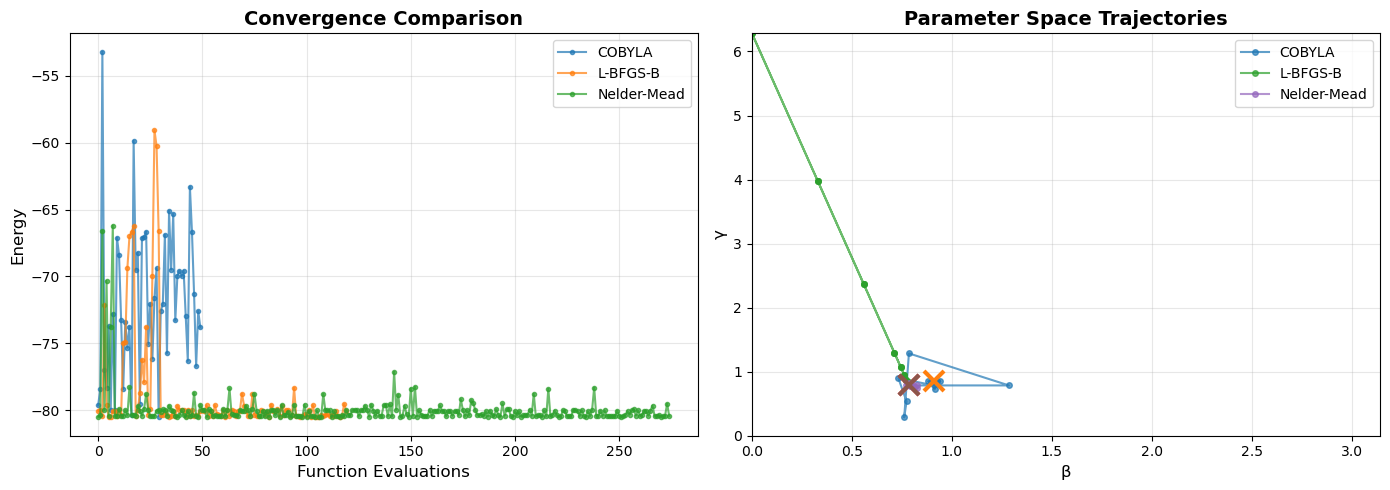


FINAL COMPARISON

COBYLA:
  Energy: -73.811612
  β = 0.9114, γ = 0.8497
  Evaluations: 50

L-BFGS-B:
  Energy: -80.425027
  β = 0.7854, γ = 0.7854
  Evaluations: 120

Nelder-Mead:
  Energy: -80.544959
  β = 0.7854, γ = 0.7854
  Evaluations: 275


In [62]:
# Build QUBO and Ising terms
h, J, idx_map = build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot, B_budget)
z_lin, z_pair, _ = qubo_to_ising_onehot(h, J)


result_cobyla, hist_cobyla, params_cobyla = cobyla_qaoa(
    h, J, z_lin, z_pair, shots=1024, n_repeats=3, maxiter=100
)

result_lbfgsb, hist_lbfgsb, params_lbfgsb = lbfgsb_qaoa(
    h, J, z_lin, z_pair, shots=1024, n_repeats=3, maxiter=100
)

result_nm, hist_nm, params_nm = nelder_mead_qaoa(
    h, J, z_lin, z_pair, shots=1024, n_repeats=3, maxiter=100
)

# Compare results
results = {
    'COBYLA': (result_cobyla, hist_cobyla, params_cobyla),
    'L-BFGS-B': (result_lbfgsb, hist_lbfgsb, params_lbfgsb),
    'Nelder-Mead': (result_nm, hist_nm, params_nm)
}

plot_optimization_comparison(results)
plt.show()

# Summary comparison
print("\n" + "=" * 60)
print("FINAL COMPARISON")
print("=" * 60)
for method_name, (result, hist, params) in results.items():
    print(f"\n{method_name}:")
    print(f"  Energy: {result.fun:.6f}")
    print(f"  β = {result.x[0]:.4f}, γ = {result.x[1]:.4f}")
    print(f"  Evaluations: {len(hist)}")

As seen, Nedler-Mead performed excellently and gave a very low E_hat. We will attempt to equate or beat these scores with Bayesian Optimisation and PPO. If we manage to beat any of the baselines, it indicates there is merit to these techniques.

## Bayesian Optimisation
First we will test Bayesian Optimisation on the real data

In [63]:
# --- Bayesian Optimization setup ---

def bo_qaoa(h, J, z_lin, z_pair, shots=4096, n_calls=50, n_random_starts=10):
    # Search space: beta in [0, pi], gamma in [0, 2pi]
    search_space = [Real(0, np.pi, name="beta"), Real(0, 2*np.pi, name="gamma")]
    
    eval_cache = {}
    
    @use_named_args(search_space)
    def objective(beta, gamma):
        """
        Average multiple evaluations to reduce shot noise.
        """
        n_repeats = 3
        key = (round(beta,6), round(gamma,6))
        if key in eval_cache:
            return eval_cache[key]
        
        energies = [evaluate_qaoa((beta, gamma), h, J, z_lin, z_pair, shots=shots) 
                    for _ in range(n_repeats)]
        avg_energy = float(np.mean(energies))
        eval_cache[key] = avg_energy
        
        if len(eval_cache) % 5 == 0:
            print(f"Eval {len(eval_cache)}: E = {avg_energy:.4f}, "
                  f"β = {beta:.4f}, γ = {gamma:.4f}")
        return avg_energy
    
    # Periodic kernel to reflect circular nature of angles
    k_beta  = ConstantKernel(1.0) * ExpSineSquared(length_scale=1.0, periodicity=np.pi)
    k_gamma = ConstantKernel(1.0) * ExpSineSquared(length_scale=1.0, periodicity=2*np.pi)
    kernel = k_beta + k_gamma

    
    base_gp = SkoptGP(kernel=kernel, alpha=0.05**2, normalize_y=True)
    
    result = gp_minimize(
        func=objective,
        dimensions=search_space,
        n_calls=n_calls,
        n_random_starts=n_random_starts,
        random_state=42,
        base_estimator=base_gp,
        acq_func="EI",   # Expected Improvement
        xi=0.01          # exploration parameter
    )
    
    print("Best parameters found:")
    print("beta  =", result.x[0])
    print("gamma =", result.x[1])
    print("Energy =", result.fun)
    
    return result

Eval 5: E = -80.4468, β = 1.8885, γ = 4.4490
Eval 10: E = -80.5002, β = 2.6991, γ = 0.0665
Eval 15: E = -80.4595, β = 2.8404, γ = 4.4810
Eval 20: E = -76.9549, β = 0.4620, γ = 2.0192
Eval 25: E = -78.4117, β = 2.6176, γ = 5.2911
Eval 30: E = -80.4804, β = 2.7517, γ = 1.4226
Eval 35: E = -79.6884, β = 1.6381, γ = 1.8144
Eval 40: E = -80.5131, β = 1.7990, γ = 5.1495
Eval 45: E = -79.6868, β = 1.8231, γ = 2.9896
Eval 50: E = -80.5098, β = 2.4812, γ = 4.4086
Eval 55: E = -79.5340, β = 1.7945, γ = 4.8275
Eval 60: E = -80.3726, β = 2.4763, γ = 5.5050
Eval 65: E = -79.5605, β = 2.9523, γ = 5.5441
Eval 70: E = -80.4563, β = 0.2069, γ = 2.1004
Eval 75: E = -78.7883, β = 1.9571, γ = 0.4885
Eval 80: E = -80.0031, β = 1.0773, γ = 6.0351
Eval 85: E = -78.3486, β = 2.1556, γ = 6.2221
Eval 90: E = -64.5381, β = 1.0747, γ = 0.0021
Eval 95: E = -80.3713, β = 0.6901, γ = 5.9746
Eval 100: E = -65.0501, β = 0.6047, γ = 1.2799
Best parameters found:
beta  = 2.5442403032286562
gamma = 0.45244274594612993
En

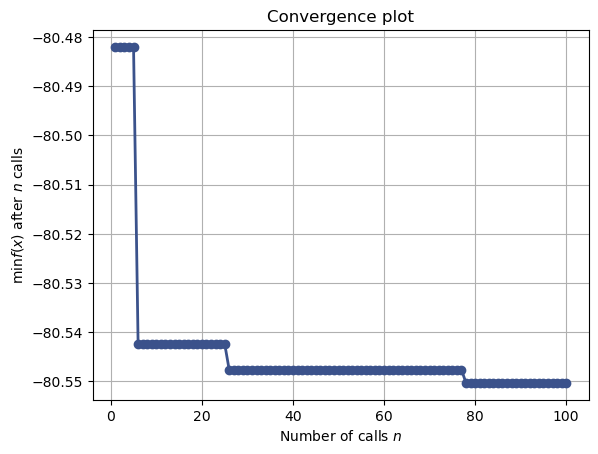

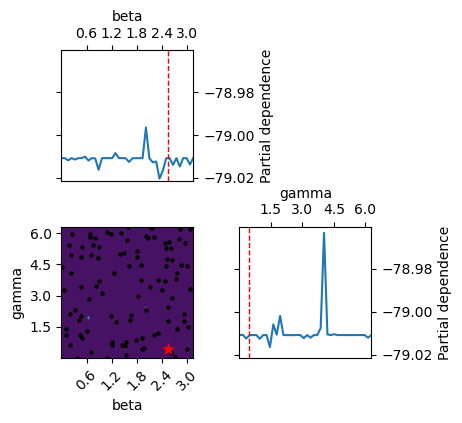

In [64]:
h, J, idx_map = build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot, B_budget)
z_lin, z_pair, _ = qubo_to_ising_onehot(h, J)

# ============================
# 2. Run Bayesian Optimization
# ============================

result = bo_qaoa(h, J, z_lin, z_pair, shots=4096, n_calls=100, n_random_starts=5)

print("\nBayesian Optimization Result:")
print("beta*  =", result.x[0])
print("gamma* =", result.x[1])
print("Energy* =", result.fun)

plot_convergence(result)
plt.show()

plot_objective(result)
plt.show()

Below is one final improvement of the Bayesian Optimisation now that we are using real data. Why? We can see in the convergence plot that we can improve our results by exploring more. The convergence occurs in steps but we want it to decrease faster.

In [65]:
def bo_qaoa_optimized(h, J, z_lin, z_pair, shots=5000, n_calls=50, n_random_starts=15):
    search_space = [Real(0, np.pi, name="beta"), Real(0, 2*np.pi, name="gamma")]
    
    eval_cache = {}
    eval_history = []
    
    @use_named_args(search_space)
    def objective(beta, gamma):
        n_repeats = 3
        key = (round(beta, 6), round(gamma, 6))
        
        if key in eval_cache:
            return eval_cache[key]
        
        # Use QUBO energy evaluation
        energies = [evaluate_qaoa((beta, gamma), h, J,z_lin, z_pair, shots=shots) 
                    for _ in range(n_repeats)]
        avg_energy = float(np.mean(energies))
        
        eval_cache[key] = avg_energy
        eval_history.append({'beta': beta, 'gamma': gamma, 'energy': avg_energy})
        
        if len(eval_history) % 5 == 0:
            print(f"Eval {len(eval_history)}: E = {avg_energy:.4f}, "
                  f"β = {beta:.4f}, γ = {gamma:.4f}")
        
        return avg_energy
    
    # Rest of BO setup...
    kernel = ConstantKernel(1.0, constant_value_bounds=(0.1, 10.0)) * \
             RBF(length_scale=[0.5, 1.0], 
                 length_scale_bounds=[(0.1, 2.0), (0.1, 4.0)])
    
    base_gp = SkoptGP(kernel=kernel, alpha=0.01**2, normalize_y=True, n_restarts_optimizer=10)
    
    result = gp_minimize(
        func=objective,
        dimensions=search_space,
        n_calls=n_calls,
        n_random_starts=n_random_starts,
        random_state=42,
        base_estimator=base_gp,
        acq_func="EI",
        xi=0.05,
        n_jobs=1,
        verbose=False
    )
    print("\n" + "="*60)
    print("Optimized Bayesian Optimization Results:")
    print("="*60)
    print(f"Best β  = {result.x[0]:.6f}")
    print(f"Best γ  = {result.x[1]:.6f}")
    print(f"Energy  = {result.fun:.6f}")
    print(f"Total evaluations: {len(eval_history)}")
    
    
    return result, eval_history

In [66]:
def plot_bo_landscape(result, eval_history):
    """
    Visualize the BO search process and landscape.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Energy vs iterations
    ax1 = axes[0]
    energies = [h['energy'] for h in eval_history]
    best_so_far = np.minimum.accumulate(energies)
    
    ax1.plot(energies, 'o-', alpha=0.5, label='Evaluations')
    ax1.plot(best_so_far, 'r-', linewidth=2, label='Best so far')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Energy')
    ax1.set_title('Bayesian Optimization Convergence')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Parameter space exploration
    ax2 = axes[1]
    betas = [h['beta'] for h in eval_history]
    gammas = [h['gamma'] for h in eval_history]
    colors = energies
    
    scatter = ax2.scatter(betas, gammas, c=colors, cmap='viridis', 
                         s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax2.plot(result.x[0], result.x[1], 'r*', markersize=20, 
            label='Best point', markeredgecolor='black', markeredgewidth=1)
    
    ax2.set_xlabel('β')
    ax2.set_ylabel('γ')
    ax2.set_title('Parameter Space Exploration')
    ax2.set_xlim(0, np.pi)
    ax2.set_ylim(0, 2*np.pi)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=ax2, label='Energy')
    plt.tight_layout()
    
    return fig

Eval 5: E = -80.3835, β = 1.8885, γ = 4.4490
Eval 10: E = -79.1565, β = 1.3570, γ = 1.8298
Eval 15: E = -79.6706, β = 1.8611, γ = 0.2919
Eval 20: E = -79.2484, β = 2.1496, γ = 2.7656
Eval 25: E = -80.0412, β = 1.9632, γ = 3.8504
Eval 30: E = -80.4192, β = 2.6462, γ = 5.7450
Eval 35: E = -80.5106, β = 1.5199, γ = 0.8722
Eval 40: E = -80.4173, β = 0.0000, γ = 1.4848
Eval 45: E = -80.0285, β = 2.4936, γ = 6.2832
Eval 50: E = -80.5224, β = 1.8271, γ = 2.7414
Eval 55: E = -80.4338, β = 2.3441, γ = 2.2717
Eval 60: E = -80.4474, β = 2.6848, γ = 5.0221
Eval 65: E = -80.5365, β = 2.7202, γ = 2.0092
Eval 70: E = -80.1023, β = 2.6053, γ = 5.3697
Eval 75: E = -80.3748, β = 2.0134, γ = 1.7349
Eval 80: E = -80.4137, β = 1.6249, γ = 4.2893
Eval 85: E = -80.5131, β = 1.7274, γ = 0.8161
Eval 90: E = -78.2562, β = 1.1764, γ = 4.5456
Eval 95: E = -80.5218, β = 2.9850, γ = 5.9972
Eval 100: E = -80.3434, β = 0.5328, γ = 6.2832

Optimized Bayesian Optimization Results:
Best β  = 2.002528
Best γ  = 6.283185


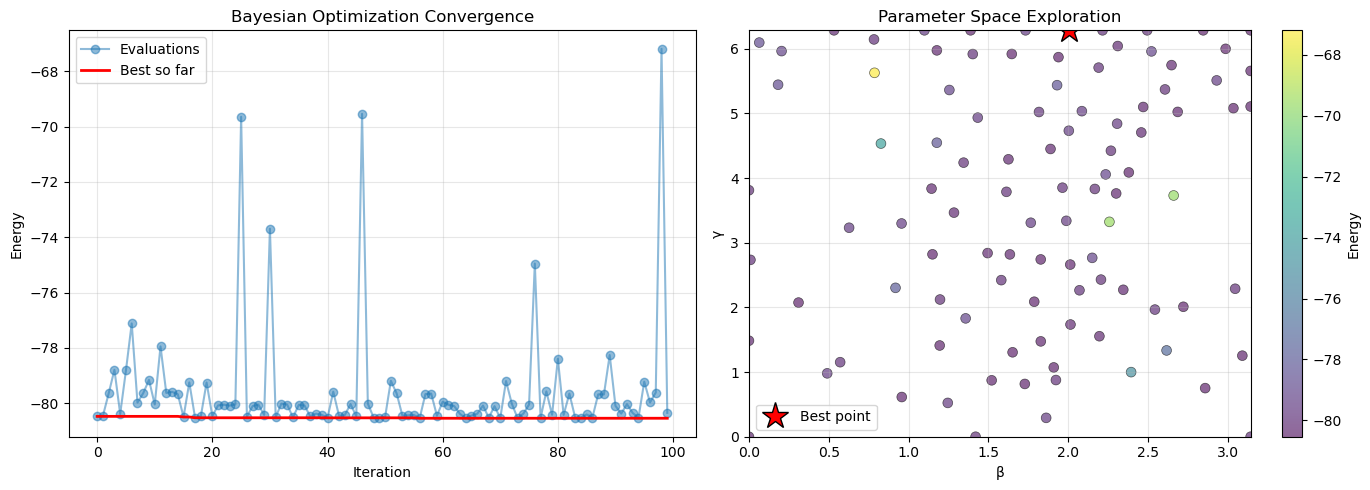

In [67]:
# Build QUBO/Ising
h, J, idx_map = build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot, B_budget)
z_lin, z_pair, _ = qubo_to_ising_onehot(h, J)


result_bo, history = bo_qaoa_optimized(h, J, z_lin, z_pair, shots=4096, n_calls=100, n_random_starts=20)
plot_bo_landscape(result_bo, history)
plt.show()

## PPO

Now we will see how PPO runs on the real data

In [68]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========================================
# Simple PPO
# ========================================

class QAOAPolicy(nn.Module):
    """Simple policy for 2D parameter space"""
    def __init__(self, init_mean=None, init_log_std=-0.5):
        super().__init__()
        if init_mean is None:
            init_mean = [np.pi/4, np.pi/4]
        
        self.mu = nn.Parameter(torch.tensor(init_mean, dtype=torch.float32))
        self.log_std = nn.Parameter(torch.ones(2) * init_log_std)
    
    def forward(self):
        mu = self.mu
        std = torch.exp(self.log_std).clamp(min=0.05, max=1.0)
        return mu, std
    
    def sample_action(self):
        mu, std = self.forward()
        dist = Normal(mu, std)
        action_raw = dist.sample()
        log_prob = dist.log_prob(action_raw).sum()
        
        # Project to bounds: beta in [0, pi], gamma in [0, 2pi)
        action = action_raw.clone()
        action[0] = torch.clamp(action[0], 0, np.pi)
        action[1] = torch.fmod(action[1], 2 * np.pi)
        action[1] = torch.where(action[1] < 0, action[1] + 2 * np.pi, action[1])
        
        return action, log_prob, action_raw
    
    def evaluate_actions(self, actions):
        mu, std = self.forward()
        dist = Normal(mu, std)
        log_probs = dist.log_prob(actions).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1)
        return log_probs, entropy


class QAOAValue(nn.Module):
    """Simple value baseline"""
    def __init__(self):
        super().__init__()
        self.baseline = nn.Parameter(torch.zeros(1))
    
    def forward(self, states):
        return self.baseline.expand(states.shape[0])

# ========================================
# Simple In-Memory Cache
# ========================================

class SimpleCache:
    """Lightweight in-memory cache with no disk I/O"""
    def __init__(self, precision=4):
        self.cache = {}
        self.precision = precision
        self.hits = 0
        self.misses = 0
    
    def get(self, beta, gamma):
        key = (round(beta, self.precision), round(gamma, self.precision))
        if key in self.cache:
            self.hits += 1
            return self.cache[key]
        self.misses += 1
        return None
    
    def set(self, beta, gamma, value):
        key = (round(beta, self.precision), round(gamma, self.precision))
        self.cache[key] = value
    
    def stats(self):
        total = self.hits + self.misses
        hit_rate = 100 * self.hits / total if total > 0 else 0
        return {'size': len(self.cache), 'hit_rate': hit_rate}

# ========================================
# Simple & Fast PPO Trainer (training-time best, no re-eval)
# ========================================

def train_ppo_simple(
    h,
    J,
    z_lin,
    z_pair,
    n_iterations=100,
    samples_per_iter=32,
    n_epochs=4,
    policy_lr=5e-3,
    value_lr=1e-2,
    clip_epsilon=0.2,
    entropy_coef=0.03,
    value_coef=0.5,
    max_grad_norm=0.5,
    init_mean=None,
    init_log_std=-0.5,
    shots=1024,
    cache_precision=4,
    print_every=10
):
    """
    PPO for QAOA with:
      - Proper param wrapping (β in [0,π], γ in [0,2π))
      - Stable cache keys (rounded to cache_precision)
      - Consistent evaluate_qaoa signature everywhere
      - FINAL SUMMARY USES TRAINING-TIME BEST ONLY (no re-evaluation)
    """
    if init_mean is None:
        init_mean = [np.pi/4, np.pi/4]
    
    # Initialize
    policy   = QAOAPolicy(init_mean=init_mean, init_log_std=init_log_std).to(DEVICE)
    value_net = QAOAValue().to(DEVICE)
    policy_optimizer = optim.Adam(policy.parameters(), lr=policy_lr)
    value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)

    # Cache
    cache = SimpleCache(precision=cache_precision)

    # Tracking
    energy_history      = []
    param_history       = []
    best_energy_history = []
    best_energy = float('inf')
    best_params = None

    print("="*70)
    print("Simple & Fast PPO for QAOA (training-time best only)")
    print("="*70)
    print(f"Device: {DEVICE}")
    print(f"Samples/iter: {samples_per_iter}, Epochs: {n_epochs}")
    print(f"Training shots: {shots}")
    print(f"Initial LR: policy={policy_lr:.0e}, value={value_lr:.0e}")
    print(f"Initial std: {np.exp(init_log_std):.3f}, entropy: {entropy_coef:.3f}")
    print(f"Clip: {clip_epsilon}")
    print("="*70 + "\n")

    for iteration in range(1, n_iterations + 1):
        actions_list, actions_raw_list, log_probs_list, rewards_list = [], [], [], []

        # Collect batch
        for _ in range(samples_per_iter):
            with torch.no_grad():
                action, log_prob, action_raw = policy.sample_action()

            # Wrap parameters into valid domain
            beta  = float(np.clip(action[0].item(), 0, np.pi))
            gamma = float(np.mod(action[1].item(), 2*np.pi))
            params = (beta, gamma)

            # Stable cache keys
            key_beta  = round(beta,  cache_precision)
            key_gamma = round(gamma, cache_precision)

            energy = cache.get(key_beta, key_gamma)
            if energy is None:
                energy = evaluate_qaoa(params, h, J, z_lin, z_pair, shots=shots)
                cache.set(key_beta, key_gamma, energy)

            reward = -energy

            actions_list.append(action)
            actions_raw_list.append(action_raw)
            log_probs_list.append(log_prob)
            rewards_list.append(reward)

            if energy < best_energy:
                best_energy = energy
                best_params = params  # already wrapped

        # Tensors
        actions_raw   = torch.stack(actions_raw_list).to(DEVICE)
        old_log_probs = torch.stack(log_probs_list).to(DEVICE)
        rewards       = torch.tensor(rewards_list, dtype=torch.float32).to(DEVICE)

        # Advantages (simple TD residual)
        with torch.no_grad():
            values     = value_net(actions_raw)
            advantages = rewards - values
            returns    = rewards
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO updates
        for _ in range(n_epochs):
            new_log_probs, entropy = policy.evaluate_actions(actions_raw)
            ratio = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages

            policy_loss    = -torch.min(surr1, surr2).mean()
            entropy_loss   = -entropy_coef * entropy.mean()
            total_pol_loss = policy_loss + entropy_loss

            policy_optimizer.zero_grad()
            total_pol_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy.parameters(), max_grad_norm)
            policy_optimizer.step()

            values_pred = value_net(actions_raw)
            value_loss  = value_coef * nn.MSELoss()(values_pred, returns)

            value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(value_net.parameters(), max_grad_norm)
            value_optimizer.step()

        # Logging
        avg_energy = -rewards.mean().item()
        min_energy = -rewards.max().item()
        energy_history.append(avg_energy)
        best_energy_history.append(best_energy)

        with torch.no_grad():
            mu, std = policy.forward()
            current_beta  = torch.clamp(mu[0], 0, np.pi).item()
            current_gamma = torch.fmod(mu[1], 2 * np.pi).item()
            if current_gamma < 0:
                current_gamma += 2 * np.pi
            param_history.append([current_beta, current_gamma])
            current_std = std.cpu().numpy()

        if iteration % print_every == 0 or iteration == 1:
            cache_stats = cache.stats()
            print(f"[{iteration:3d}] E_avg={avg_energy:7.2f} E_min={min_energy:7.2f} "
                  f"E_best={best_energy:7.2f} | β={current_beta:.3f} γ={current_gamma:.3f} | "
                  f"σ=[{current_std[0]:.2f},{current_std[1]:.2f}] | cache={cache_stats['hit_rate']:.0f}%")

    # Final (training-time best only; no re-evaluation)
    print("\n" + "="*70)
    print("FINAL (training-time best only)")
    print("="*70)
    best_beta, best_gamma = best_params
    print(f"Best observed: E={best_energy:.4f} β={best_beta:.4f} γ={best_gamma:.4f}")
    print(f"Policy mean (last μ): β={current_beta:.4f} γ={current_gamma:.4f}")

    recommended         = best_params
    recommended_energy  = best_energy

    print(f"\n{'='*70}")
    print(f"RECOMMENDED: β={recommended[0]:.6f} γ={recommended[1]:.6f} E={recommended_energy:.4f}")
    print("="*70)

    # Separate PPO figures + save, if available
    if 'plot_ppo_results_separate' in globals() and 'save_figures' in globals():
        fig_e, fig_p, fig_s = plot_ppo_results_separate(
            energy_history, param_history, best_params, (current_beta, current_gamma), best_energy,
            best_history=best_energy_history
        )
        save_figures(
            {'ppo-energy': fig_e, 'ppo-params': fig_p, 'ppo-space': fig_s},
            out_dir="figures/ppo",
            base_name="ppo_run"
        )
        plt.show()

    return {
        'policy': policy,
        'value_net': value_net,
        'best_params': best_params,
        'best_energy': best_energy,
        'final_params': (current_beta, current_gamma),   # for reference only
        'final_energy': None,                            # no re-eval
        'energy_history': energy_history,
        'param_history': param_history,
        'best_energy_history': best_energy_history,
        'recommended_params': recommended,
        'recommended_energy': recommended_energy
    }


def plot_results(energy_history, param_history, best_params, final_params, 
                 best_energy, best_history):
    """Visualize training progress"""
    param_history = np.array(param_history)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Energy convergence
    ax1 = axes[0]
    ax1.plot(energy_history, alpha=0.3, color='lightblue', label='Batch avg')
    
    # Rolling average
    window = min(15, len(energy_history) // 5)
    if window > 1:
        rolling = pd.Series(energy_history).rolling(window=window, min_periods=1).mean()
        ax1.plot(rolling.values, linewidth=2, color='blue', label=f'Rolling ({window})')
    
    ax1.plot(best_history, linewidth=2.5, color='red', label='Best so far')
    ax1.axhline(y=best_energy, color='darkred', linestyle='--', alpha=0.7)
    
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Energy')
    ax1.set_title('Training Progress')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Parameter evolution
    ax2 = axes[1]
    ax2.plot(param_history[:, 0], label='β (mean)', linewidth=2, color='blue')
    ax2.plot(param_history[:, 1], label='γ (mean)', linewidth=2, color='green')
    ax2.axhline(y=best_params[0], color='blue', linestyle='--', alpha=0.5)
    ax2.axhline(y=best_params[1], color='green', linestyle='--', alpha=0.5)
    
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Parameter (rad)')
    ax2.set_title('Parameter Evolution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Parameter space
    ax3 = axes[2]
    iterations = np.arange(len(param_history))
    scatter = ax3.scatter(param_history[:, 0], param_history[:, 1],
                         c=iterations, cmap='viridis', s=30, alpha=0.6)
    ax3.plot(best_params[0], best_params[1], 'r*', markersize=20,
            label=f'Best (E={best_energy:.1f})', 
            markeredgecolor='black', markeredgewidth=1.5)
    ax3.plot(final_params[0], final_params[1], 'bs', markersize=10,
            label='Final mean', markeredgecolor='black', markeredgewidth=1)
    
    ax3.set_xlabel('β (rad)')
    ax3.set_ylabel('γ (rad)')
    ax3.set_xlim(0, np.pi)
    ax3.set_ylim(0, 2*np.pi)
    ax3.set_title('Parameter Space')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Iteration')
    
    plt.tight_layout()
    plt.show()


# ========================================
# Multi-Start Version
# ========================================

def multi_start_simple_ppo(
    h, J, z_lin, z_pair,
    n_starts=5,
    strategy='informed',
    custom_points=None,
    **kwargs
):
    """
    Multi-start with different initialization strategies.
    
    Strategies:
    - 'informed': Start near known QAOA sweet spots
    - 'grid': Uniform grid
    - 'boundary': Focus on edges
    - 'custom': Use custom_points
    """
    print("\n" + "="*70)
    print(f"MULTI-START SIMPLE PPO ({n_starts} starts, strategy: {strategy})")
    print("="*70 + "\n")
    
    # Choose initialization
    if strategy == 'custom' and custom_points:
        init_points = custom_points[:n_starts]
    elif strategy == 'grid':
        n_beta = int(np.ceil(np.sqrt(n_starts)))
        n_gamma = int(np.ceil(n_starts / n_beta))
        beta_vals = np.linspace(0.2, np.pi - 0.2, n_beta)
        gamma_vals = np.linspace(0.2, 2*np.pi - 0.2, n_gamma)
        init_points = [[b, g] for b in beta_vals for g in gamma_vals][:n_starts]
    elif strategy == 'boundary':
        init_points = [
            [0.1, 0.1], [np.pi-0.1, 0.1], [0.1, 2*np.pi-0.1],
            [np.pi-0.1, 2*np.pi-0.1], [np.pi/2, 0.1], [np.pi/2, 2*np.pi-0.1],
            [0.1, np.pi], [np.pi-0.1, np.pi]
        ][:n_starts]
    else:  # 'informed'
        init_points = [
            [2.8,0.04], [0.78, 3.14], [0.52, 0.79],
            [np.pi/4, np.pi/4], [np.pi/2, np.pi],
            [0.26, 1.57], [1.05, 1.57]
        ][:n_starts]
    
    all_results = []
    
    for i, init_mean in enumerate(init_points):
        print(f"\n{'='*70}")
        print(f"Start {i+1}/{n_starts} - β={init_mean[0]:.3f}, γ={init_mean[1]:.3f}")
        print("="*70 + "\n")
        
        result = train_ppo_simple(
            h, J, z_lin, z_pair,
            init_mean=init_mean,
            print_every=15,
            **kwargs
        )
        all_results.append(result)
        print(f"\nStart {i+1} done: E={result['recommended_energy']:.4f}\n")
    
    # Find best
    best = min(all_results, key=lambda x: x['recommended_energy'])
    
    print("\n" + "="*70)
    print("BEST ACROSS ALL STARTS")
    print("="*70)
    print(f"Energy: {best['recommended_energy']:.4f}")
    print(f"β={best['recommended_params'][0]:.6f} "
          f"γ={best['recommended_params'][1]:.6f}")
    
    # Summary table
    print("\n" + "="*70)
    print("ALL RESULTS (sorted):")
    print("="*70)
    sorted_results = sorted(all_results, key=lambda x: x['recommended_energy'])
    for i, res in enumerate(sorted_results, 1):
        params = res['recommended_params']
        energy = res['recommended_energy']
        print(f"{i}. E={energy:7.2f} | β={params[0]:.4f} γ={params[1]:.4f}")
    print("="*70)
    
    return best, all_results

In [69]:
h, J, idx_map = build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot, B_budget)
z_lin, z_pair, _ = qubo_to_ising_onehot(h, J)

train_ppo_simple(h, J, z_lin, z_pair, n_iterations=100, samples_per_iter=32)

Simple & Fast PPO for QAOA (training-time best only)
Device: cpu
Samples/iter: 32, Epochs: 4
Training shots: 1024
Initial LR: policy=5e-03, value=1e-02
Initial std: 0.607, entropy: 0.030
Clip: 0.2

[  1] E_avg= -76.96 E_min= -80.55 E_best= -80.55 | β=0.765 γ=0.767 | σ=[0.62,0.62] | cache=0%
[ 10] E_avg= -75.41 E_min= -80.54 E_best= -80.55 | β=0.789 γ=0.790 | σ=[0.72,0.58] | cache=0%
[ 20] E_avg= -74.83 E_min= -80.55 E_best= -80.55 | β=0.750 γ=0.805 | σ=[0.83,0.55] | cache=0%
[ 30] E_avg= -75.85 E_min= -80.55 E_best= -80.55 | β=0.651 γ=0.785 | σ=[0.93,0.54] | cache=0%
[ 40] E_avg= -74.23 E_min= -80.55 E_best= -80.55 | β=0.584 γ=0.775 | σ=[1.00,0.58] | cache=0%
[ 50] E_avg= -74.47 E_min= -80.55 E_best= -80.55 | β=0.457 γ=0.782 | σ=[1.00,0.55] | cache=0%
[ 60] E_avg= -78.05 E_min= -80.54 E_best= -80.55 | β=0.324 γ=0.810 | σ=[1.00,0.51] | cache=0%
[ 70] E_avg= -77.83 E_min= -80.55 E_best= -80.55 | β=0.154 γ=0.937 | σ=[1.00,0.50] | cache=0%
[ 80] E_avg= -77.59 E_min= -80.55 E_best= -80.55 |

{'policy': QAOAPolicy(),
 'value_net': QAOAValue(),
 'best_params': (0.7291839718818665, 0.9144681096076965),
 'best_energy': -80.5502937122623,
 'final_params': (0.0, 0.7900086045265198),
 'final_energy': None,
 'energy_history': [-76.9571762084961,
  -74.69803619384766,
  -76.69284057617188,
  -73.29039001464844,
  -75.05069732666016,
  -75.04708862304688,
  -74.792236328125,
  -77.03997802734375,
  -77.52387237548828,
  -75.40623474121094,
  -76.29711151123047,
  -74.44538879394531,
  -77.59658813476562,
  -74.3924789428711,
  -75.81497192382812,
  -75.29473876953125,
  -75.17081451416016,
  -75.7559814453125,
  -75.9477310180664,
  -74.83428955078125,
  -77.33193969726562,
  -71.9815444946289,
  -74.6428451538086,
  -75.11534118652344,
  -76.03121185302734,
  -75.81343078613281,
  -73.2995834350586,
  -75.31535339355469,
  -76.23192596435547,
  -75.84600830078125,
  -77.79985046386719,
  -76.09141540527344,
  -74.18185424804688,
  -76.72085571289062,
  -74.0115966796875,
  -75.9055

In [70]:
best_result, all_results = multi_start_simple_ppo(h, J, z_lin, z_pair, n_starts=3, strategy='boundary')
best_result


MULTI-START SIMPLE PPO (3 starts, strategy: boundary)


Start 1/3 - β=0.100, γ=0.100

Simple & Fast PPO for QAOA (training-time best only)
Device: cpu
Samples/iter: 32, Epochs: 4
Training shots: 1024
Initial LR: policy=5e-03, value=1e-02
Initial std: 0.607, entropy: 0.030
Clip: 0.2

[  1] E_avg= -77.75 E_min= -80.55 E_best= -80.55 | β=0.080 γ=0.120 | σ=[0.62,0.62] | cache=0%
[ 15] E_avg= -76.75 E_min= -80.55 E_best= -80.55 | β=0.000 γ=0.113 | σ=[0.67,0.64] | cache=0%
[ 30] E_avg= -77.47 E_min= -80.55 E_best= -80.55 | β=0.000 γ=0.079 | σ=[0.68,0.72] | cache=1%
[ 45] E_avg= -76.62 E_min= -80.55 E_best= -80.55 | β=0.000 γ=0.198 | σ=[0.56,0.71] | cache=1%
[ 60] E_avg= -77.27 E_min= -80.55 E_best= -80.55 | β=0.000 γ=0.154 | σ=[0.53,0.80] | cache=2%
[ 75] E_avg= -78.07 E_min= -80.52 E_best= -80.55 | β=0.000 γ=0.199 | σ=[0.50,0.83] | cache=3%
[ 90] E_avg= -77.75 E_min= -80.55 E_best= -80.55 | β=0.000 γ=0.262 | σ=[0.51,0.95] | cache=3%

FINAL (training-time best only)
Best observed: E=-80.550

## Plot spaces

In [71]:
def plot_optimization_comparison(h, J, z_lin, z_pair, 
                                  ppo_result=None, 
                                  bo_result=None, 
                                  nm_result=None,
                                  figsize=(15, 5)):
    """
    Plot how PPO, Bayesian Optimization, and Nelder-Mead explored the parameter space.
    
    Parameters:
    -----------
    h, J, z_lin, z_pair : QUBO problem definition
    ppo_result : tuple from multi_start_ppo_simple() -> (best_result, all_results)
    bo_result : tuple from bo_qaoa_optimized() with eval_history
    nm_result : tuple from nelder_mead_qaoa() with param_history
    """
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle('QAOA Optimization Methods: Parameter Space Exploration', 
                 fontsize=14, fontweight='bold')
    
    # Common settings
    beta_range = (0, np.pi)
    gamma_range = (0, 2*np.pi)
    
    for ax in axes:
        ax.set_xlabel('β', fontsize=12)
        ax.set_ylabel('γ', fontsize=12)
        ax.set_xlim(beta_range)
        ax.set_ylim(gamma_range)
        ax.grid(True, alpha=0.3)
        ax.axhline(np.pi, color='gray', linestyle='--', alpha=0.3, linewidth=0.8)
        ax.axvline(np.pi/2, color='gray', linestyle='--', alpha=0.3, linewidth=0.8)
    
    # === PPO Plot (Multi-Start) ===
    if ppo_result is not None:
        # Unpack multi-start results
        best_result, all_results = ppo_result
        
        # Define colors for different starts
        colors_palette = ['#0d47a1', '#1976d2', '#42a5f5', '#90caf9', '#e3f2fd']
        
        # Plot each start's trajectory
        for i, result in enumerate(all_results):
            param_hist = np.array(result['param_history'])
            betas = param_hist[:, 0]
            gammas = param_hist[:, 1]
            
            color = colors_palette[i % len(colors_palette)]
            
            # Plot trajectory with fading line
            axes[0].plot(betas, gammas, '-', alpha=0.3, linewidth=1.5, color=color)
            
            # Plot points with progression gradient
            n_points = len(betas)
            for j in range(n_points):
                alpha = 0.3 + 0.5 * (j / n_points)
                size = 20 + 30 * (j / n_points)
                axes[0].scatter(betas[j], gammas[j], c=color, s=size, 
                              alpha=alpha, edgecolors='darkblue', linewidth=0.3)
            
            # Mark start position
            axes[0].scatter(betas[0], gammas[0], c='lime', s=150, marker='o', 
                          edgecolors='darkgreen', linewidth=2, zorder=5,
                          alpha=0.7)
            
            # Mark final position
            axes[0].scatter(betas[-1], gammas[-1], c=color, s=200, marker='D', 
                          edgecolors='black', linewidth=2, zorder=5)
            
            # Mark best found in this run
            best_params = result['best_params']
            axes[0].scatter(best_params[0], best_params[1], c='red', s=150, 
                          marker='x', linewidths=3, zorder=6, alpha=0.7)
        
        # Mark the overall best across all starts
        overall_best = best_result['best_params']
        axes[0].scatter(overall_best[0], overall_best[1], c='gold', s=400, 
                       marker='*', edgecolors='orange', linewidth=3, 
                       label=f'Best: {best_result["best_energy"]:.2f}', zorder=7)
        
        # Create legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', 
                   markersize=10, label='Start positions', markeredgecolor='darkgreen', markeredgewidth=2),
            Line2D([0], [0], marker='D', color='w', markerfacecolor='blue', 
                   markersize=10, label='Final μ positions', markeredgecolor='black', markeredgewidth=2),
            Line2D([0], [0], marker='x', color='w', markerfacecolor='red', 
                   markersize=10, label='Best per run', markeredgewidth=3),
            Line2D([0], [0], marker='*', color='w', markerfacecolor='gold', 
                   markersize=15, label=f'Overall best: {best_result["best_energy"]:.2f}', 
                   markeredgecolor='orange', markeredgewidth=2)
        ]
        
        axes[0].set_title(f'Multi-Start PPO ({len(all_results)} starts)\nDiverse Exploration', 
                         fontweight='bold')
        axes[0].legend(handles=legend_elements, loc='upper right', fontsize=7)
    
    # === Bayesian Optimization Plot ===
    if bo_result is not None:
        _, eval_history = bo_result
        
        betas = [e['beta'] for e in eval_history]
        gammas = [e['gamma'] for e in eval_history]
        energies = [e['energy'] for e in eval_history]
        
        # Color by energy (warmer = worse)
        scatter = axes[1].scatter(betas, gammas, c=energies, cmap='RdYlGn_r', 
                                  s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
        
        # Number the points to show order
        for i in range(0, len(betas), max(1, len(betas)//15)):
            axes[1].annotate(str(i+1), (betas[i], gammas[i]), 
                           fontsize=7, ha='center', va='center')
        
        # Mark best
        best_idx = np.argmin(energies)
        axes[1].scatter(betas[best_idx], gammas[best_idx], c='gold', s=300, 
                       marker='*', edgecolors='orange', linewidth=2, 
                       label=f'Best: {energies[best_idx]:.2f}', zorder=6)
        
        axes[1].set_title('Bayesian Optimization\nAcquisition-Guided Sampling', fontweight='bold')
        axes[1].legend(loc='upper right', fontsize=8)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[1])
        cbar.set_label('Energy', rotation=270, labelpad=15)
    
    # === Nelder-Mead Plot ===
    if nm_result is not None:
        _, eval_history, param_history = nm_result
        
        param_hist = np.array(param_history)
        betas = param_hist[:, 0]
        gammas = param_hist[:, 1]
        
        # Color by iteration
        colors = np.arange(len(betas))
        scatter = axes[2].scatter(betas, gammas, c=colors, cmap='Greens', 
                                  s=50, alpha=0.6, edgecolors='darkgreen', linewidth=0.5)
        
        # Show trajectory
        axes[2].plot(betas, gammas, 'g-', alpha=0.3, linewidth=1)
        
        # Draw simplices at key points
        simplex_frames = [0, len(betas)//3, 2*len(betas)//3, len(betas)-3]
        for frame in simplex_frames:
            if frame + 2 < len(betas):
                simplex_points = param_hist[frame:frame+3]
                if len(simplex_points) == 3:
                    triangle = Polygon(simplex_points, fill=False, 
                                     edgecolor='darkgreen', linewidth=1.5, 
                                     linestyle='--', alpha=0.5)
                    axes[2].add_patch(triangle)
        
        # Mark start and end
        axes[2].scatter(betas[0], gammas[0], c='green', s=200, marker='*', 
                       edgecolors='darkgreen', linewidth=2, label='Start', zorder=5)
        axes[2].scatter(betas[-1], gammas[-1], c='gold', s=300, marker='*', 
                       edgecolors='orange', linewidth=2, 
                       label=f'Best: {eval_history[-1]:.2f}', zorder=6)
        
        axes[2].set_title('Nelder-Mead (Simplex)\nGeometric Movements', fontweight='bold')
        axes[2].legend(loc='upper right', fontsize=8)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[2])
        cbar.set_label('Iteration', rotation=270, labelpad=15)
    
    plt.tight_layout()
    return fig


# Fixed Nelder-Mead function
def nelder_mead_qaoa_fixed(h, J, z_lin, z_pair, shots=4096, n_repeats=3, maxiter=100):
    """
    Nelder-Mead: Simplex-based optimization
    - Gradient-free
    - Sometimes more robust to noise than COBYLA
    - Used in some QAOA implementations
    """
    print("\n" + "=" * 60)
    print("BONUS METHOD: Nelder-Mead Optimization")
    print("=" * 60)
    
    eval_history = []
    param_history = []
    best_energy = float("inf")
    best_params = None
    
    def objective(params):
        nonlocal best_energy, best_params
        """Average multiple evaluations to reduce shot noise."""
        # FIX: Pass h and J to evaluate_qaoa
        energies = [evaluate_qaoa(params, h, J, z_lin, z_pair, shots=shots, backend=None) 
                    for _ in range(n_repeats)]
        avg_energy = float(np.mean(energies))
        
        eval_history.append(avg_energy)
        param_history.append(np.array(params, dtype=float))
        
        if avg_energy < best_energy:
            best_energy = avg_energy
            best_params = np.array(params, dtype=float)
        
        if len(eval_history) % 10 == 0:
            print(f"Iteration {len(eval_history)}: E = {avg_energy:.6f}, "
                  f"β = {params[0]:.4f}, γ = {params[1]:.4f}")
        
        return avg_energy
    
    # Initial guess
    x0 = np.array([np.pi/4, np.pi/4])
    
    # Bounds enforcement through wrapping
    def objective_bounded(params):
        # Wrap parameters to valid range
        beta = np.clip(params[0], 0, np.pi)
        gamma = params[1] % (2*np.pi)
        return objective([beta, gamma])
    
    result = minimize(
        fun=objective_bounded,
        x0=x0,
        method='Nelder-Mead',
        options={'maxiter': maxiter, 'maxfev': 4*maxiter, 'xatol': 1e-4, 'fatol': 1e-3}
    )
    
    # Report the true best seen during the run (do NOT re-evaluate to avoid shot-noise drift)
    if best_params is None:
        best_params = np.array(result.x, dtype=float)
        best_energy = float(result.fun)
    
    result.x = np.array(best_params, dtype=float)
    result.fun = float(best_energy)
    
    print("\nNelder-Mead Results:")
    print(f"  Best β  = {result.x[0]:.6f}")
    print(f"  Best γ  = {result.x[1]:.6f}")
    print(f"  Energy  = {result.fun:.6f}")
    print(f"  Evaluations: {len(eval_history)}")
    print(f"  Success: {result.success}")
    
    return result, eval_history, param_history


MULTI-START SIMPLE PPO (5 starts, strategy: grid)


Start 1/5 - β=0.200, γ=0.200

Simple & Fast PPO for QAOA (training-time best only)
Device: cpu
Samples/iter: 32, Epochs: 4
Training shots: 1024
Initial LR: policy=5e-03, value=1e-02
Initial std: 0.607, entropy: 0.030
Clip: 0.2

[  1] E_avg= -75.80 E_min= -80.54 E_best= -80.54 | β=0.180 γ=0.220 | σ=[0.62,0.62] | cache=0%
[ 15] E_avg= -77.27 E_min= -80.55 E_best= -80.55 | β=0.000 γ=0.293 | σ=[0.67,0.70] | cache=0%
[ 30] E_avg= -76.56 E_min= -80.55 E_best= -80.55 | β=0.000 γ=0.393 | σ=[0.66,0.68] | cache=0%
[ 45] E_avg= -74.92 E_min= -80.55 E_best= -80.55 | β=0.000 γ=0.467 | σ=[0.52,0.73] | cache=1%
[ 60] E_avg= -78.15 E_min= -80.54 E_best= -80.55 | β=0.000 γ=0.518 | σ=[0.48,0.83] | cache=1%

FINAL (training-time best only)
Best observed: E=-80.5503 β=1.2619 γ=0.1833
Policy mean (last μ): β=0.0000 γ=0.5176

RECOMMENDED: β=1.261882 γ=0.183279 E=-80.5503

Start 1 done: E=-80.5503


Start 2/5 - β=0.200, γ=6.083

Simple & Fast PPO for QAOA 

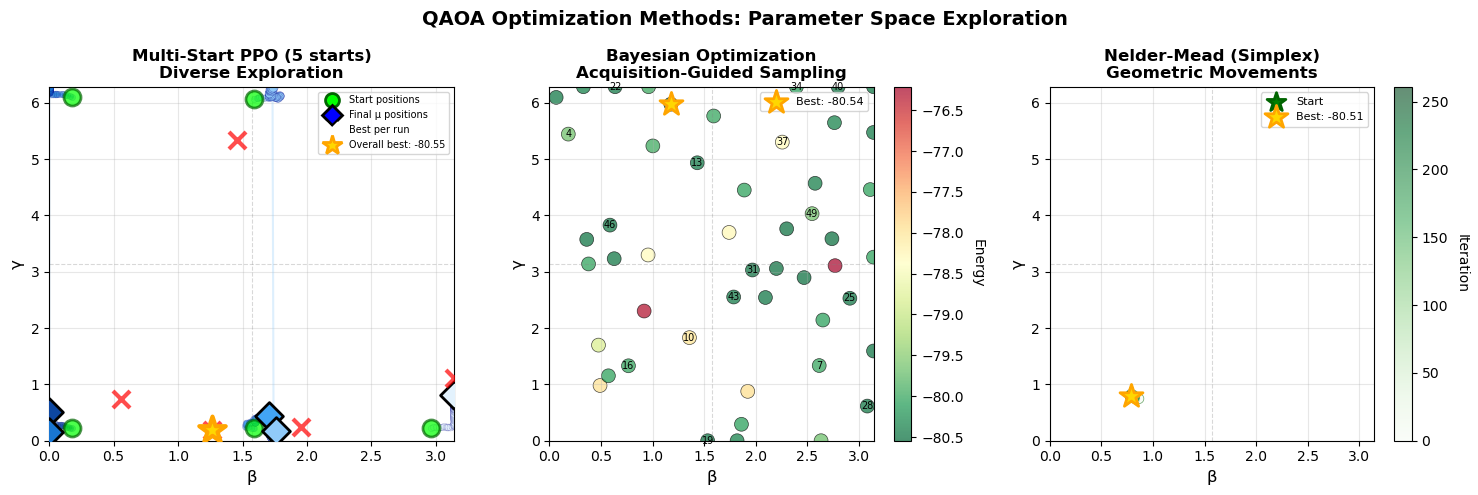

In [75]:
mu = np.array(mu_annual)
Sigma = np.array(sigma_annual)
v_levels = [0.0, 0.25, 0.5, 0.75, 1.0]
lam, A_onehot, B_budget = 2, 20.0, 20.0

h, J, idx_map = build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot, B_budget)
z_lin, z_pair, _ = qubo_to_ising_onehot(h, J)

ppo_result = multi_start_simple_ppo(h, J, z_lin, z_pair, n_starts=5, n_iterations=60, 
                                     samples_per_iter=32, strategy ='grid')

bo_result = bo_qaoa_optimized(h, J, z_lin, z_pair, n_calls=50)

nm_result = nelder_mead_qaoa_fixed(h, J, z_lin, z_pair, maxiter=100)

fig = plot_optimization_comparison(h, J, z_lin, z_pair, 
                                   ppo_result=ppo_result,
                                   bo_result=bo_result,
                                   nm_result=nm_result)
plt.show()

fig.savefig('figures/optimization_comparison.png', dpi=300, bbox_inches='tight')


# Testing on 10 buckets

In [ ]:
mu = np.array(mu_annual)
Sigma = np.array(sigma_annual)
v_levels = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
lam, A_onehot, B_budget = 3, 20.0, 20.0

In [ ]:
def save_figures(figs_dict, out_dir, base_name=None, dpi=300):
    """
    figs_dict: {'convergence': fig1, 'trajectory': fig2}
    out_dir: base output dir
    base_name: file stem; default timestamp if None
    """
    os.makedirs(out_dir, exist_ok=True)
    if base_name is None:
        base_name = datetime.now().strftime("%Y%m%d-%H%M%S")
    for key, fig in figs_dict.items():
        path = os.path.join(out_dir, f"{base_name}-{key}.png")
        fig.savefig(path, dpi=dpi, bbox_inches="tight")
        print(f"Saved: {path}")

In [ ]:
# Plotter (Nelder–Mead only; two separate figures)

def plot_optimization_comparison(results_dict):
    """
    Plot convergence and parameter trajectory in separate figures.
    results_dict: {'Nelder-Mead': (result, eval_history, param_history)}
    """
    method_name, (result, eval_history, param_history) = next(iter(results_dict.items()))
    params = np.array(param_history)

    # Figure 1: Convergence
    fig1, ax1 = plt.subplots(figsize=(7, 4))
    ax1.plot(eval_history, label=method_name, marker='o', markersize=3, alpha=0.8)
    ax1.set_xlabel('Function Evaluations', fontsize=12)
    ax1.set_ylabel('Energy', fontsize=12)
    ax1.set_title('Convergence (Nelder–Mead)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Figure 2: Parameter trajectory
    fig2, ax2 = plt.subplots(figsize=(7, 4))
    if len(params) > 0:
        ax2.plot(params[:, 0], params[:, 1], label=method_name,
                 marker='o', markersize=4, alpha=0.8)
        ax2.plot(result.x[0], result.x[1], 'x', markersize=12,
                 markeredgewidth=3, label='Best')
    ax2.set_xlabel('β', fontsize=12)
    ax2.set_ylabel('γ', fontsize=12)
    ax2.set_title('Parameter Trajectory (Nelder–Mead)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, np.pi)
    ax2.set_ylim(0, 2*np.pi)
    ax2.legend()

    return fig1, fig2

🚀 Running Nelder–Mead only:
   shots=256, n_repeats=1, maxiter=10

BONUS METHOD: Nelder-Mead Optimization
Iteration 10: E = 381.895614, β = 0.8173, γ = 0.7682
Iteration 20: E = -34.897015, β = 0.7929, γ = 0.8144
Iteration 30: E = 123.066734, β = 0.7926, γ = 0.8104
Iteration 40: E = -39.671990, β = 0.7934, γ = 0.8107

Nelder-Mead Results:
  Best β  = 0.793375
  Best γ  = 0.810555
  Energy  = -80.262655
  Evaluations: 48
  Success: False
Saved: figures/nelder_mead/lam3_shots512_repeats1_maxiter20-convergence.png
Saved: figures/nelder_mead/lam3_shots512_repeats1_maxiter20-trajectory.png


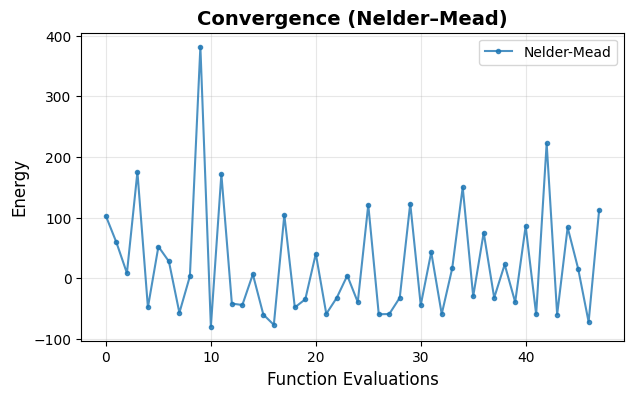

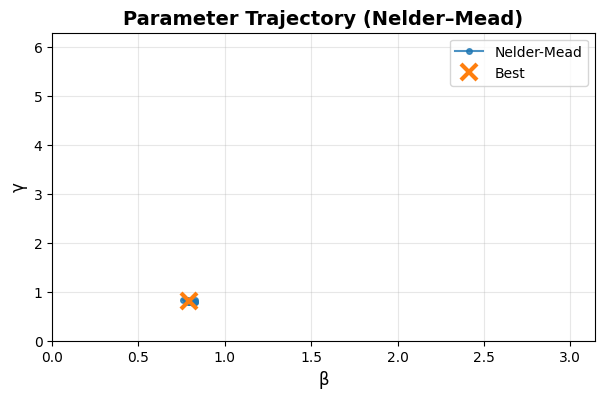


NELDER–MEAD SUMMARY
  Energy: -80.262655
  β = 0.7934, γ = 0.8106
  Evaluations: 48
  Success: False


In [196]:
shots = 512
n_repeats = 1
maxiter = 20

# Build QUBO and Ising terms
h, J, idx_map = build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot, B_budget)
z_lin, z_pair, _ = qubo_to_ising_onehot(h, J)

# Run Nelder–Mead only
print("Running Nelder–Mead only:")
print("   shots=256, n_repeats=1, maxiter=10")

result_nm, hist_nm, params_nm = nelder_mead_qaoa(
    h, J, z_lin, z_pair, shots=shots, n_repeats=n_repeats, maxiter=maxiter
)

# Prepare results dict with a single entry
results = {
    'Nelder-Mead': (result_nm, hist_nm, params_nm)
}

fig_conv, fig_traj = plot_optimization_comparison(results)
save_figures(
    {'convergence': fig_conv, 'trajectory': fig_traj},
    out_dir="figures/nelder_mead",
    base_name=f"lam{lam}_shots{shots}_repeats{n_repeats}_maxiter{maxiter}"  # customize
)
plt.show()  # shows both figures (or display them separately if preferred)

# Summary
print("\n" + "=" * 60)
print("NELDER–MEAD SUMMARY")
print("=" * 60)
print(f"  Energy: {result_nm.fun:.6f}")
print(f"  β = {result_nm.x[0]:.4f}, γ = {result_nm.x[1]:.4f}")
print(f"  Evaluations: {len(hist_nm)}")
print(f"  Success: {getattr(result_nm, 'success', False)}")

In [197]:
# After you’ve run Nelder–Mead:
# result_nm, hist_nm, params_nm = nelder_mead_qaoa(...)

beta_opt  = float(result_nm.x[0])
gamma_opt = float(result_nm.x[1])

# Run QAOA with optimized parameters (same as your BO block)
qc = qaoa_circuit(z_lin, z_pair, np.array([gamma_opt]), np.array([beta_opt]), measure=False)

res = run_stable_final_weights(
    qc=qc, h=h, J=J, idx_map=idx_map, v_levels=v_levels,
    n_runs=10, shots=50_000, renormalize=True
)

res_nm = res

# Display results with asset names
asset_names = ['AAPL', 'NVDA', 'TSLA']
weights = res["weights"]

print(f"\n🎯 Optimized QAOA Results (Nelder–Mead):")
print("="*40)
for name, weight in zip(asset_names, weights):
    print(f"{name}: {weight:.1%}")

# Portfolio metrics
portfolio_return = np.dot(weights, mu)
portfolio_var    = np.dot(weights.T, np.dot(Sigma, weights))
portfolio_std    = np.sqrt(portfolio_var)
sharpe           = portfolio_return / portfolio_std

print(f"\nPortfolio Metrics:")
print(f"Expected Return: {portfolio_return:.1%}")
print(f"Volatility: {portfolio_std:.1%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Best Energy: {res['energy']:.6f}")

Run 1/10: Best energy = -79.959045
Run 6/10: Best energy = -79.960731

🎯 FINAL RESULTS:
   Best bitstring: '000000100000000001001000000'
   Best energy: -80.284797
   Portfolio weights: [0.75 0.   0.25]
   Weight std across runs: [0.33462053 0.1569092  0.30545504]

🎯 Optimized QAOA Results (Nelder–Mead):
AAPL: 75.0%
NVDA: 0.0%
TSLA: 25.0%

Portfolio Metrics:
Expected Return: 76.7%
Volatility: 40.1%
Sharpe Ratio: 1.91
Best Energy: -80.284797


Eval 5: E = -15.0062, β = 1.8885, γ = 4.4490
Eval 10: E = -36.8443, β = 1.3570, γ = 1.8298
Eval 15: E = -64.9948, β = 1.8611, γ = 0.2919
Eval 20: E = -4.1623, β = 2.1496, γ = 2.7656
Eval 25: E = -19.2049, β = 1.7175, γ = 1.1615
Eval 30: E = -24.6137, β = 1.4526, γ = 0.0000
Eval 35: E = -12.3723, β = 1.2707, γ = 3.3704
Eval 40: E = -30.8784, β = 1.7404, γ = 2.0384
Eval 45: E = 2.0989, β = 0.5580, γ = 6.2832
Eval 50: E = -27.0867, β = 3.1416, γ = 3.7784

Optimized Bayesian Optimization Results:
Best β  = 0.490147
Best γ  = 0.980142
Energy  = -72.994447
Total evaluations: 50
Optimised QAOA parameters: beta = 0.49014701463702604, gamma = 0.9801424781769558
Saved: figures/bo/lam3_shots5000_calls50_random_starts25-bo-convergence.png
Saved: figures/bo/lam3_shots5000_calls50_random_starts25-bo-parameter-space.png


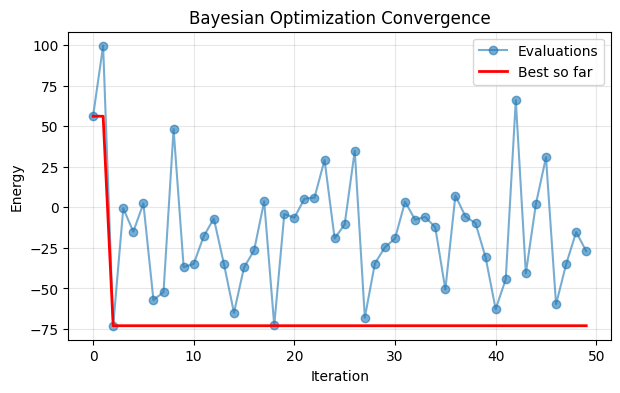

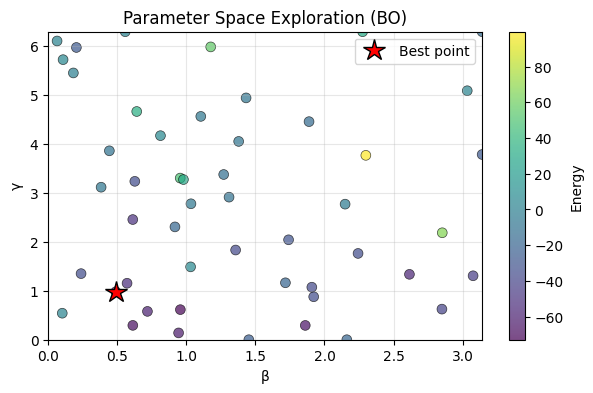

In [202]:
shots = 5000
n_calls = 50
n_random_starts = 25

# Run optimization (unchanged)
h, J, idx_map = build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot, B_budget)
z_lin, z_pair, _ = qubo_to_ising_onehot(h, J)

result_bo, history = bo_qaoa_optimized(h, J, z_lin, z_pair, shots, n_calls, n_random_starts)

gamma_opt = result_bo.x[1]
beta_opt  = result_bo.x[0]
print(f"Optimised QAOA parameters: beta = {beta_opt}, gamma = {gamma_opt}")

# Plot (now returns two figs)
fig_conv, fig_space = plot_bo_landscape(result_bo, history)
save_figures(
    {'bo-convergence': fig_conv, 'bo-parameter-space': fig_space},
    out_dir="figures/bo",
    base_name=f"lam{lam}_shots{shots}_calls{n_calls}_random_starts{n_random_starts}"
)
plt.show()  # will display both figures

In [203]:
# Run QAOA with optimized parameters
qc = qaoa_circuit(z_lin, z_pair, np.array([gamma_opt]), np.array([beta_opt]), measure=False)

res = run_stable_final_weights(
    qc=qc, h=h, J=J, idx_map=idx_map, v_levels=v_levels,
    n_runs=10, shots=50_000, renormalize=True
)
res_bo = res

# Display results with asset names
asset_names = ['AAPL', 'NVDA', 'TSLA']
weights = res["weights"]

print(f"\n🎯 Optimized QAOA Results (λ=2):")
print("="*40)
for i, (name, weight) in enumerate(zip(asset_names, weights)):
    print(f"{name}: {weight:.1%}")

# Calculate portfolio metrics
portfolio_return = np.dot(weights, mu)
portfolio_var = np.dot(weights.T, np.dot(Sigma, weights))
portfolio_std = np.sqrt(portfolio_var)
sharpe = portfolio_return / portfolio_std

print(f"\nPortfolio Metrics:")
print(f"Expected Return: {portfolio_return:.1%}")
print(f"Volatility: {portfolio_std:.1%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Best Energy: {res['energy']:.6f}")

Run 1/10: Best energy = -79.936857
Run 6/10: Best energy = -80.218718

🎯 FINAL RESULTS:
   Best bitstring: '000000001000010000000010000'
   Best energy: -80.218718
   Portfolio weights: [0.5 0.5 0. ]
   Weight std across runs: [0.25992392 0.33983648 0.27460266]

🎯 Optimized QAOA Results (λ=2):
AAPL: 50.0%
NVDA: 50.0%
TSLA: 0.0%

Portfolio Metrics:
Expected Return: 70.5%
Volatility: 40.3%
Sharpe Ratio: 1.75
Best Energy: -80.218718


In [219]:
def plot_ppo_results_separate(energy_history, param_history, best_params, final_params,
                              best_energy, best_history=None):
    """
    Create three separate figures for PPO:
      - fig_energy: energy curves (avg, rolling, best-so-far)
      - fig_params: parameter evolution (β, γ) with best lines
      - fig_space: parameter space scatter with best/final markers
    Returns (fig_energy, fig_params, fig_space).
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    param_history = np.array(param_history)

    # 1) Energy with best-so-far
    fig_energy, ax1 = plt.subplots(figsize=(7.5, 4.5))
    ax1.plot(energy_history, alpha=0.3, color='lightblue', label='Batch average')

    window = min(15, max(2, len(energy_history) // 5))
    if window > 1:
        rolling = pd.Series(energy_history).rolling(window=window, min_periods=1).mean()
        ax1.plot(rolling.values, linewidth=2, color='blue', label=f'Rolling avg ({window})')

    if best_history is not None and len(best_history) > 0:
        ax1.plot(best_history, linewidth=2.5, color='red', linestyle='-',
                 label='Best so far', zorder=10)

    ax1.axhline(y=best_energy, color='darkred', linestyle='--', linewidth=1.5,
                alpha=0.7, label=f'Final best: {best_energy:.2f}')
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Energy', fontsize=12)
    ax1.set_title('PPO Training Progress', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # 2) Parameter evolution (β, γ)
    fig_params, ax2 = plt.subplots(figsize=(7.5, 4.5))
    if len(param_history) > 0:
        ax2.plot(param_history[:, 0], label='β (policy mean)', linewidth=2, color='blue')
        ax2.plot(param_history[:, 1], label='γ (policy mean)', linewidth=2, color='green')
    ax2.axhline(y=best_params[0], color='blue', linestyle='--', alpha=0.6, linewidth=2,
                label=f'Best β: {best_params[0]:.3f}')
    ax2.axhline(y=best_params[1], color='green', linestyle='--', alpha=0.6, linewidth=2,
                label=f'Best γ: {best_params[1]:.3f}')
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Parameter (rad)', fontsize=12)
    ax2.set_title('PPO Parameter Evolution', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    # 3) Parameter space scatter
    fig_space, ax3 = plt.subplots(figsize=(7.5, 4.5))
    if len(param_history) > 0:
        iterations = np.arange(len(param_history))
        scatter = ax3.scatter(param_history[:, 0], param_history[:, 1],
                              c=iterations, cmap='viridis', s=30, alpha=0.7,
                              label='Policy trajectory')
        plt.colorbar(scatter, ax=ax3, label='Iteration')

    ax3.plot(best_params[0], best_params[1], 'r*', markersize=18,
             label=f'Best (E={best_energy:.2f})',
             markeredgecolor='black', markeredgewidth=1.5, zorder=5)
    ax3.plot(final_params[0], final_params[1], 'bs', markersize=10,
             label='Final mean', markeredgecolor='black', markeredgewidth=1.2, zorder=5)

    ax3.set_xlabel('β (rad)', fontsize=12)
    ax3.set_ylabel('γ (rad)', fontsize=12)
    ax3.set_xlim(0, np.pi)
    ax3.set_ylim(0, 2*np.pi)
    ax3.set_title('PPO Parameter Space Exploration', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=9, loc='upper right')
    ax3.grid(True, alpha=0.3)

    return fig_energy, fig_params, fig_space

Simple & Fast PPO for QAOA (training-time best only)
Device: cpu
Samples/iter: 12, Epochs: 2
Training shots: 512
Initial LR: policy=1e-02, value=2e-02
Initial std: 0.607, entropy: 0.030
Clip: 0.2

[  1] E_avg=  37.48 E_min= -44.11 E_best= -44.11 | β=0.805 γ=0.765 | σ=[0.59,0.62] | cache=0%
[  5] E_avg= 107.77 E_min= -40.01 E_best= -58.98 | β=0.869 γ=0.745 | σ=[0.58,0.60] | cache=0%
[ 10] E_avg=  42.90 E_min= -74.87 E_best= -74.87 | β=0.864 γ=0.753 | σ=[0.58,0.59] | cache=0%
[ 15] E_avg=  28.51 E_min= -43.86 E_best= -78.92 | β=0.895 γ=0.770 | σ=[0.59,0.56] | cache=0%
[ 20] E_avg=  98.32 E_min= -60.12 E_best= -78.92 | β=0.892 γ=0.792 | σ=[0.62,0.52] | cache=0%
[ 25] E_avg=  75.58 E_min= -79.96 E_best= -79.96 | β=0.891 γ=0.774 | σ=[0.63,0.49] | cache=0%
[ 30] E_avg=  39.38 E_min= -48.12 E_best= -79.96 | β=0.902 γ=0.743 | σ=[0.61,0.45] | cache=0%

FINAL (training-time best only)
Best observed: E=-79.9607 β=0.4618 γ=0.2284
Policy mean (last μ): β=0.9021 γ=0.7431

RECOMMENDED: β=0.461794 γ=0

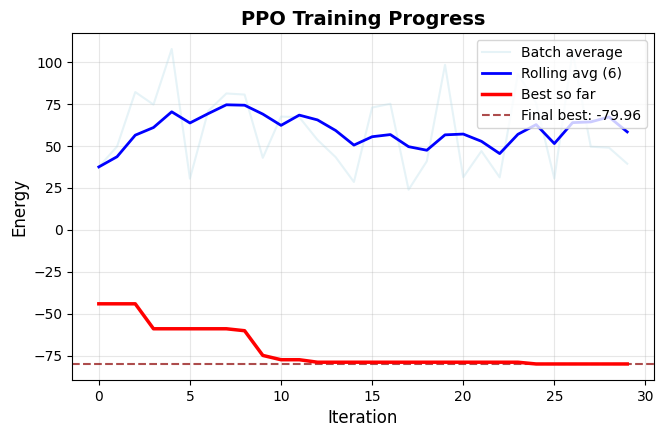

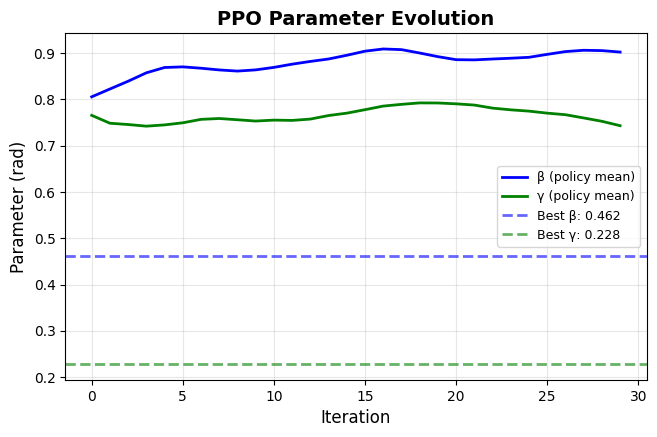

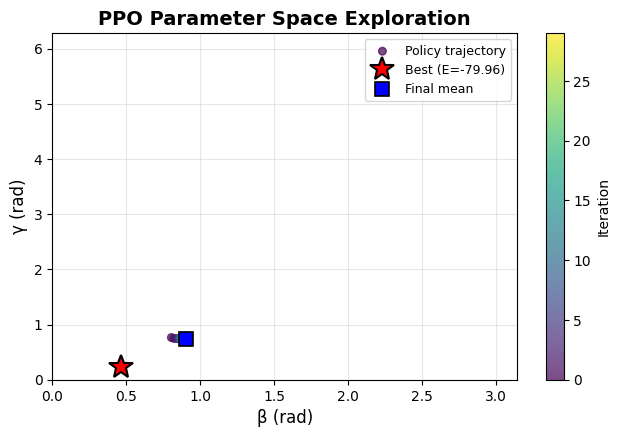

In [223]:
h, J, idx_map = build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot, B_budget)
z_lin, z_pair, _ = qubo_to_ising_onehot(h, J)

result = train_ppo_simple(
    h, J, z_lin, z_pair,
    n_iterations=30,
    samples_per_iter=12,
    n_epochs=2,
    shots=512,
    cache_precision=3,
    policy_lr=1e-2,     # slightly higher to learn faster
    value_lr=2e-2,
    entropy_coef=0.03,
    print_every=5
)

In [226]:
# Run QAOA with optimized parameters (PPO)
qc = qaoa_circuit(z_lin, z_pair, np.array([gamma_opt]), np.array([beta_opt]), measure=False)

res = run_stable_final_weights(
    qc=qc, h=h, J=J, idx_map=idx_map, v_levels=v_levels,
    n_runs=10, shots=50_000, renormalize=True
)

res_ppo = res

# Display results with asset names
asset_names = ['AAPL', 'NVDA', 'TSLA']
weights = res["weights"]

print(f"\n🎯 Optimized QAOA Results (PPO):")
print("="*40)
for name, weight in zip(asset_names, weights):
    print(f"{name}: {weight:.1%}")

# Portfolio metrics
portfolio_return = np.dot(weights, mu)
portfolio_var    = np.dot(weights.T, np.dot(Sigma, weights))
portfolio_std    = np.sqrt(portfolio_var)
sharpe           = portfolio_return / portfolio_std

print(f"\nPortfolio Metrics:")
print(f"Expected Return: {portfolio_return:.1%}")
print(f"Volatility: {portfolio_std:.1%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Best Energy: {res['energy']:.6f}")

Run 1/10: Best energy = -79.611595
Run 6/10: Best energy = -79.920349

🎯 FINAL RESULTS:
   Best bitstring: '000000100000001000000001000'
   Best energy: -80.325410
   Portfolio weights: [0.375 0.375 0.25 ]
   Weight std across runs: [0.17671    0.25173012 0.27894815]

🎯 Optimized QAOA Results (PPO):
AAPL: 37.5%
NVDA: 37.5%
TSLA: 25.0%

Portfolio Metrics:
Expected Return: 87.8%
Volatility: 42.9%
Sharpe Ratio: 2.05
Best Energy: -80.325410


### Traditional (Fully Classical)

In [ ]:
def get_optimal_weights_with_returns(combined_df, stock_names=None, max_weight=1.0, lam=lam):
    """
    Get optimal portfolio weights using Mean-Variance Optimization WITH RETURNS
    This matches the QAOA approach: min -w^T μ + λ * w^T Σ w
    
    Parameters:
    -----------
    combined_df : DataFrame
        DataFrame with Date column and stock price columns
    stock_names : list, optional
        List of stock column names (default: all except Date)
    max_weight : float, optional
        Maximum weight per asset (default: 1.0)
    lam : float, optional
        Risk aversion parameter λ (default: 0.5)
        Higher λ = more risk averse
    
    Returns:
    --------
    optimal_weights : numpy array
        Optimal portfolio weights
    weights_dict : dict
        Dictionary mapping stock names to weights
    """
    if stock_names is None:
        stock_names = [col for col in combined_df.columns if col != 'Date']
    
    # Compute log returns
    prices = combined_df[stock_names]
    log_returns = np.log(prices / prices.shift(1)).dropna()
    
    print(f"\nLog returns calculated: {len(log_returns)} days")
    print(f"Mean daily log returns:\n{log_returns.mean()}")
    print(f"\nUsing risk aversion λ = {lam}")
    
    # Expected returns (annualized)
    mu_daily = log_returns.mean()
    mu_annual = mu_daily * 252
    
    # Covariance matrix (annualized)
    cov_matrix = log_returns.cov()
    annual_cov = cov_matrix * 252
    print(f"\nCovariance matrix shape: {cov_matrix.shape}")
    
    n_assets = len(stock_names)
    
    def portfolio_objective(weights):
        """
        Mean-Variance objective: -w^T μ + λ * w^T Σ w
        We minimize this (negative returns + positive variance penalty)
        """
        # Portfolio expected return
        portfolio_return = np.dot(weights, mu_annual)
        
        # Portfolio variance
        portfolio_var = np.dot(weights.T, np.dot(annual_cov, weights))
        
        # Objective: minimize -return + λ*variance
        objective = -portfolio_return + lam * portfolio_var
        
        return objective
    
    # Constraint: weights must sum to 1
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    
    # Bounds: (weights ≥ 0)
    bounds = tuple((0, max_weight) for _ in range(n_assets))
    
    # Initial guess: equal weights
    initial_weights = np.ones(n_assets) / n_assets
    
    result = minimize(
        portfolio_objective,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': False, 'ftol': 1e-9}
    )
    
    if not result.success:
        print(f"Warning: Optimization did not fully converge")
        print(f"Message: {result.message}")
    else:
        print(f"Optimization successful!")
    
    # Results
    optimal_weights = result.x
    mean_daily_return = log_returns.mean()
    
    # Annualized metrics
    portfolio_return = np.sum(mean_daily_return * optimal_weights) * 252
    portfolio_var = np.dot(optimal_weights.T, np.dot(annual_cov, optimal_weights))
    portfolio_std = np.sqrt(portfolio_var)
    
    weights_dict = {name: float(weight) for name, weight in zip(stock_names, optimal_weights)}
    for name, weight in weights_dict.items():
        print(f"{name:10s}: {weight:7.4f} ({weight*100:6.2f}%)")
    
    print(f"\nSum of weights: {optimal_weights.sum():.6f}")
    
    print(f"\n{'='*60}")
    print(f"PORTFOLIO METRICS (WITH RETURNS, λ={lam})")
    print(f"{'='*60}")
    print(f"Expected Annual Log Return: {portfolio_return:.4f} ({portfolio_return*100:.2f}%)")
    print(f"Expected Annual Volatility: {portfolio_std:.4f} ({portfolio_std*100:.2f}%)")
    print(f"Portfolio Variance:         {portfolio_var:.6f}")
    print(f"Sharpe Ratio (rf=0):        {portfolio_return/portfolio_std:.4f}")
    
    return optimal_weights, weights_dict

In [210]:
weights_new, dict_new = get_optimal_weights_with_returns(
    combined_df, lam=lam
)


Log returns calculated: 525 days
Mean daily log returns:
AAPL    0.002208
TSLA    0.005543
NVDA    0.003390
dtype: float64

Using risk aversion λ = 3

Covariance matrix shape: (3, 3)
Optimization successful!
AAPL      :  0.3716 ( 37.16%)
TSLA      :  0.3099 ( 30.99%)
NVDA      :  0.3185 ( 31.85%)

Sum of weights: 1.000000

PORTFOLIO METRICS (WITH RETURNS, λ=3)
Expected Annual Log Return: 0.9117 (91.17%)
Expected Annual Volatility: 0.4404 (44.04%)
Portfolio Variance:         0.193983
Sharpe Ratio (rf=0):        2.0701


## Result Comparison

In [229]:
def compute_portfolio_metrics(weights, mu, Sigma):
    w = np.asarray(weights, dtype=float)
    ret = float(np.dot(w, mu))
    var = float(np.dot(w.T, np.dot(Sigma, w)))
    vol = float(np.sqrt(max(var, 0.0)))
    sharpe = ret / vol if vol > 0 else np.nan
    return {"return": ret, "vol": vol, "sharpe": sharpe}

def compare_portfolios_visual(methods, asset_names, mu, Sigma, out_dir=None, base_name=None):
    """
    methods: [{'name': str, 'weights': array_like, 'energy': optional}]
    asset_names: list[str]
    mu: (N,), Sigma: (N,N)
    Returns (df, figs). Saves if out_dir is provided via your save_figures.
    """
    rows = []
    for m in methods:
        metrics = compute_portfolio_metrics(m["weights"], mu, Sigma)
        rows.append({
            "method": m["name"],
            "return": metrics["return"],
            "vol": metrics["vol"],
            "sharpe": metrics["sharpe"],
            "weights": np.asarray(m["weights"], dtype=float),
            "energy": m.get("energy", np.nan),
        })
    df = pd.DataFrame(rows).sort_values("sharpe", ascending=False).reset_index(drop=True)

    # 1) Risk–return
    fig_rr, ax = plt.subplots(figsize=(7.5, 5))
    for _, r in df.iterrows():
        ax.scatter(r["vol"], r["return"], s=140, alpha=0.9, label=r["method"])
        ax.annotate(r["method"], (r["vol"], r["return"]), xytext=(6, 6),
                    textcoords="offset points", fontsize=9)
    ax.set_xlabel("Volatility"); ax.set_ylabel("Expected return")
    ax.set_title("Risk–Return (λ as configured)")
    ax.grid(True, alpha=0.3); ax.legend()

    # 2) Sharpe bars
    fig_sh, ax = plt.subplots(figsize=(7.5, 4.5))
    ax.bar(df["method"], df["sharpe"], color="tab:blue", alpha=0.85)
    ax.set_ylabel("Sharpe (rf=0)"); ax.set_title("Sharpe by Method")
    ax.grid(True, axis="y", alpha=0.3)

    # 3) Stacked allocations
    W = np.vstack(df["weights"].to_numpy())
    fig_ws, ax = plt.subplots(figsize=(max(7.5, 1.5 * len(df)), 5))
    bottom = np.zeros(W.shape[0])
    for j, an in enumerate(asset_names):
        ax.bar(df["method"], W[:, j], bottom=bottom, label=an)
        bottom += W[:, j]
    ax.set_ylim(0, 1); ax.set_ylabel("Weight")
    ax.set_title("Portfolio Allocation by Method")
    ax.legend(ncol=min(len(asset_names), 3)); ax.grid(True, axis="y", alpha=0.3)

    # 4) Radar (normalized; lower vol -> higher score)
    def _norm(s):
        a = np.asarray(s, dtype=float)
        lo, hi = np.nanmin(a), np.nanmax(a)
        return np.ones_like(a) if hi - lo < 1e-12 else (a - lo) / (hi - lo)

    vals_return = _norm(df["return"])
    vals_vol    = 1.0 - _norm(df["vol"])
    vals_sharpe = _norm(df["sharpe"])

    labels = ["Return", "1-Vol", "Sharpe"]
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    angles = np.concatenate([angles, angles[:1]])

    fig_rd = plt.figure(figsize=(6.5, 6.5))
    ax = fig_rd.add_subplot(111, polar=True)
    for i, row in df.iterrows():
        data = [vals_return[i], vals_vol[i], vals_sharpe[i]]
        data = np.concatenate([data, data[:1]])
        ax.plot(angles, data, label=row["method"], linewidth=2)
        ax.fill(angles, data, alpha=0.10)
    ax.set_xticks(np.linspace(0, 2*np.pi, len(labels), endpoint=False))
    ax.set_xticklabels(labels); ax.set_yticklabels([])
    ax.set_title("Normalized Comparison (higher is better)")
    ax.legend(bbox_to_anchor=(1.15, 1.0), loc="upper left", fontsize=8)

    figs = {
        "risk-return": fig_rr,
        "sharpe-bars": fig_sh,
        "weights-stacked": fig_ws,
        "radar": fig_rd,
    }
    if out_dir is not None:
        save_figures(figs, out_dir=out_dir, base_name=base_name or "compare")
    return df, figs

Saved: figures/compare/lam3-risk-return.png
Saved: figures/compare/lam3-sharpe-bars.png
Saved: figures/compare/lam3-weights-stacked.png
Saved: figures/compare/lam3-radar.png


method    return       vol    sharpe
0    Classical  0.916425  0.442237  2.072247
1     QAOA+PPO  0.878274  0.429288  2.045887
2  QAOA+Nelder  0.766560  0.400734  1.912890
3      QAOA+BO  0.705453  0.402796  1.751388

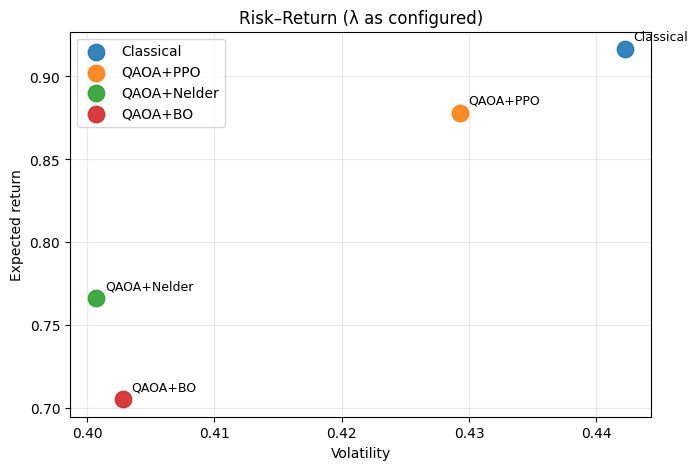

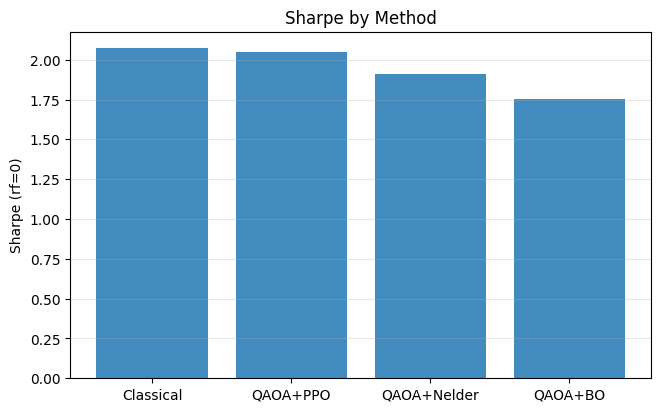

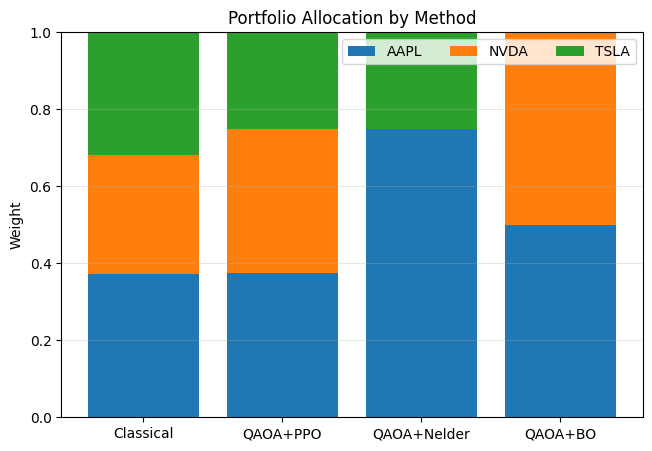

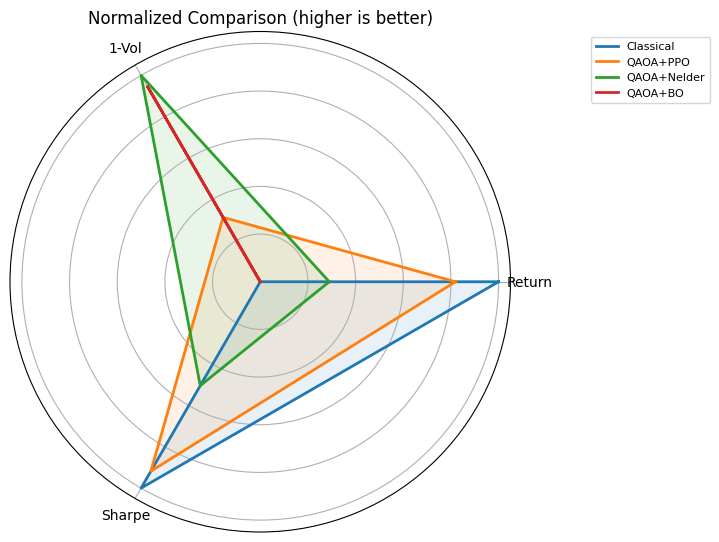

In [230]:
methods = [
    {"name": "Classical",   "weights": weights_new},
    {"name": "QAOA+Nelder", "weights": res_nm["weights"], "energy": res_nm.get("energy")},
    {"name": "QAOA+BO",     "weights": res_bo["weights"], "energy": res_bo.get("energy")},
    {"name": "QAOA+PPO",    "weights": res_ppo["weights"], "energy": res_ppo.get("energy")},
]

df_compare, figs = compare_portfolios_visual(
    methods,
    asset_names=asset_names,
    mu=mu,
    Sigma=Sigma,
    out_dir="figures/compare",
    base_name=f"lam{lam}"
)
display(df_compare[["method", "return", "vol", "sharpe"]])
plt.show()

## Running in hardware

In [ ]:
try:
    # Load your IBM Quantum account (run once with your token)
    QiskitRuntimeService.save_account(channel="ibm_cloud", token="", instance="", overwrite=True)
    service = QiskitRuntimeService()
    
    # List available backends
    print("✅ IBM Quantum account loaded successfully.")
    print("Available backends:")
    print(service.backends())

except Exception as e:
    print("Could not load IBM Quantum account.")
    print("Error:", e)
    print("\n👉 Please check if your account is set up correctly:")
    print("1. Log in at https://quantum-computing.ibm.com/")
    print("2. Copy your API token from Account settings.")
    print("3. Replace YOUR_API_TOKEN above with your actual token.")
    print("4. Re-run this cell.")

✅ IBM Quantum account loaded successfully.
Available backends:
[<IBMBackend('ibm_brussels')>, <IBMBackend('ibm_aachen')>, <IBMBackend('ibm_strasbourg')>]


In [257]:
service = QiskitRuntimeService()  # assumes you've saved account
backend = service.backend("ibm_brussels")

In [257]:
print(backend.configuration().num_qubits)

In [ ]:
def _transpile_for_hw(qc, backend):
    return transpile(qc, backend=backend, optimization_level=3,
                     layout_method="sabre", routing_method="sabre")

def _quasi_to_counts(q: QuasiDistribution, shots: int) -> dict[str, int]:
    return {k: int(round(v * shots)) for k, v in dict(q).items() if v > 0}

def estimate_expectation(qc, z_lin, z_pair, shots=20000, backend=None,
                         use_sampler=False, sampler_resilience_level=1):
    if backend is None:
        raise ValueError("Hardware backend must be provided.")
    qc_run = qc.copy()
    if qc_run.num_clbits == 0:
        qc_run.measure_all()
    tqc = _transpile_for_hw(qc_run, backend)

    if use_sampler:
        sampler = Sampler(
            backend=backend,
            options=Options(
                optimization_level=3,
                transpilation={"layout_method": "sabre", "routing_method": "sabre"},
                resilience_level=int(sampler_resilience_level),
            ),
        )
        qdist = sampler.run([tqc], shots=shots).result().quasi_dists[0]
        counts = _quasi_to_counts(qdist, shots)
    else:
        counts = backend.run(tqc, shots=shots).result().get_counts()

    return expectation_from_counts(z_lin, z_pair, counts), counts

In [ ]:
mu = np.array(mu_annual)
Sigma = np.array(sigma_annual)
v_levels = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
lam, A_onehot, B_budget = 3, 20.0, 20.0

In [ ]:
h, J, idx_map = build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot, B_budget)
z_lin, z_pair, _ = qubo_to_ising_onehot(h, J)
print("Qubits:", len(z_lin))

In [ ]:
beta_opt  = 0.7934
gamma_opt = 0.8106
gammas = np.array([float(gamma_opt)])
betas  = np.array([float(beta_opt)])
print("p=1 params → gamma:", gammas[0], "beta:", betas[0])

In [ ]:
qc = qaoa_circuit(z_lin, z_pair, gammas, betas, measure=False, add_barriers=True)
print("QAOA circuit built")

In [ ]:
tqc = transpile(qc, backend=backend, optimization_level=3,
                layout_method="sabre", routing_method="sabre")

twoq_depth = tqc.depth(filter_function=lambda inst: getattr(inst.operation, "num_qubits", 0) == 2)
twoq_count = tqc.count_ops().get("cx", 0)

print("Transpiled depth:", tqc.depth())
print("Approx. 2q-depth:", twoq_depth, "| CX count:", twoq_count)

SOFT_LIMIT_2Q = 50
HARD_LIMIT_2Q = 100
if twoq_depth > HARD_LIMIT_2Q:
    raise RuntimeError(f"2q-depth {twoq_depth} exceeds hard limit {HARD_LIMIT_2Q}. Reduce problem size or p.")
elif twoq_depth > SOFT_LIMIT_2Q:
    print(f"Warning: 2q-depth {twoq_depth} > soft limit {SOFT_LIMIT_2Q}. Consider reducing it.")

In [ ]:
MAX_TOTAL_SHOTS = 120_000   # hard cap across all repeats
MAX_RUNS        = 3         # cap repeats
MIN_SHOTS_RUN   = 8_000
MAX_SHOTS_RUN   = 40_000

scale = max(1.0, twoq_depth / 40.0)      # deeper → fewer shots per run
base_shots = int(MAX_SHOTS_RUN / scale)
base_shots = max(MIN_SHOTS_RUN, min(MAX_SHOTS_RUN, base_shots))

n_runs = max(1, min(MAX_RUNS, MAX_TOTAL_SHOTS // base_shots))
shots  = max(MIN_SHOTS_RUN, min(base_shots, MAX_TOTAL_SHOTS // n_runs))
total_shots = n_runs * shots
zne_shots = min(5_000, shots)

print(f"Planned hardware run:")
print(f"  2q-depth ~ {twoq_depth}")
print(f"  n_runs   = {n_runs}")
print(f"  shots    = {shots} per run")
print(f"  TOTAL    = {total_shots} (<= {MAX_TOTAL_SHOTS})")
print(f"  ZNE shots= {zne_shots}")

In [ ]:
try:
    from qiskit_ibm_runtime import debug_tools  # API may vary
    # Example (pseudo): report = debug_tools.neat(backend=backend, circuits=[tqc])
    # print("NEAT report:", report)
    print("NEAT tooling imported; check env docs for exact usage.")
except Exception:
    print("NEAT not available; skipping.")

In [ ]:
def quasi_to_counts(q: QuasiDistribution, shots: int) -> dict[str, int]:
    return {k: int(round(v * shots)) for k, v in dict(q).items() if v > 0}

if n_runs * shots > MAX_TOTAL_SHOTS:
    raise RuntimeError("Planned shots exceed MAX_TOTAL_SHOTS. Re-run budget cell.")

sampler_opts = Options(
    optimization_level=3,
    transpilation={"layout_method": "sabre", "routing_method": "sabre"},
    resilience_level=1,  # measurement mitigation (M3)
)
sampler = Sampler(backend=backend, options=sampler_opts)

pooled, per_run_counts = {}, []
for r in range(n_runs):
    mqc = tqc.measure_all(inplace=False)
    qdist = sampler.run([mqc], shots=shots).result().quasi_dists[0]
    counts = quasi_to_counts(qdist, shots)
    per_run_counts.append(counts)
    for k, v in counts.items():
        pooled[k] = pooled.get(k, 0) + v

best_key, best_E, onehot_vec, w_star = pick_min_energy_from_counts(
    pooled, h, J, idx_map, v_levels, renormalize=True
)

print("Final pooled weights:", w_star)
print("Most-negative pooled QUBO energy:", best_E)
print("Total pooled shots:", sum(pooled.values()))

In [ ]:
def ising_op_from_z(z_lin_arr: np.ndarray, z_pair_arr: np.ndarray) -> SparsePauliOp:
    n = len(z_lin_arr)
    paulis, coeffs = [], []
    for i, c in enumerate(z_lin_arr):
        if c != 0:
            z = ["I"] * n; z[i] = "Z"
            paulis.append("".join(reversed(z))); coeffs.append(float(c))
    inds = np.argwhere(np.triu(z_pair_arr, k=1) != 0)
    for i, j in inds:
        c = z_pair_arr[i, j]
        if c != 0:
            z = ["I"] * n; z[i] = "Z"; z[j] = "Z"
            paulis.append("".join(reversed(z))); coeffs.append(float(c))
    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

H_op = ising_op_from_z(np.asarray(z_lin), np.asarray(z_pair))

zne_opts = Options(
    optimization_level=3,
    transpilation={"layout_method": "sabre", "routing_method": "sabre"},
    resilience_level=2,  # ZNE + meas. mitigation
)

estimator = Estimator(backend=backend, options=zne_opts)
E_zne = float(estimator.run([tqc], [H_op], shots=zne_shots).result().values[0])
print("Estimator (ZNE) energy:", E_zne, "| ZNE shots:", zne_shots)

In [ ]:
ts = time.strftime("%Y%m%d-%H%M%S")
asset_names = list(returns.columns) if "returns" in globals() else ["AAPL","NVDA","TSLA"]

artifact = {
    "timestamp": ts,
    "backend": backend.name,
    "shots_per_run": int(shots),
    "n_runs": int(n_runs),
    "two_qubit_depth": int(twoq_depth),
    "qaoa_params": {"gamma": float(gammas[0]), "beta": float(betas[0])},
    "mitigation": {"sampler_resilience_level": 1, "estimator_resilience_level": 2},
    "pooled_counts": pooled,
    "per_run_counts": per_run_counts,
    "final_weights": [float(x) for x in w_star],
    "energy_from_counts": float(best_E),
    "energy_estimator_zne": float(E_zne) if "E_zne" in globals() else None,
    "assets": asset_names,
    "lam": float(lam),
    "A_onehot": float(A_onehot),
    "B_budget": float(B_budget),
    "mu": [float(x) for x in np.asarray(mu)],
    "Sigma": np.asarray(Sigma).tolist(),
    "max_total_shots": int(MAX_TOTAL_SHOTS),
}

os.makedirs("runs", exist_ok=True)
out_json = f"runs/run_{ts}_lam{lam}-hardware-mitigated.json"
with open(out_json, "w") as f:
    json.dump(artifact, f, indent=2)
print("Saved:", out_json)

# Testing weights on future data

In [76]:
apple = pd.read_csv('data/Apple.csv')
apple = apple[['Unnamed: 0', 'Close']]
apple.rename(columns={"Unnamed: 0": "date", "Close": "close"}, inplace=True)
apple.head()

date     close
0  1980-12-12  0.128348
1  1980-12-15  0.121652
2  1980-12-16  0.112723
3  1980-12-17  0.115513
4  1980-12-18  0.118862

In [77]:
tesla = pd.read_csv('data/Tesla.csv')
tesla = tesla[['Date', 'Close/Last']]
tesla.rename(columns={"Date": "date", "Close/Last": "close"}, inplace=True)
tesla.head()

date    close
0  09/13/2024  $230.29
1  09/12/2024  $229.81
2  09/11/2024  $228.13
3  09/10/2024  $226.17
4  09/09/2024  $216.27

In [78]:
nvidia = pd.read_csv('data/Nvidia.csv')
nvidia = nvidia[['Date', 'Close']]
nvidia.rename(columns={"Date": "date", "Close": "close"}, inplace=True)
nvidia.head()

date     close
0  1999-01-22 00:00:00-05:00  0.037621
1  1999-01-25 00:00:00-05:00  0.041562
2  1999-01-26 00:00:00-05:00  0.038337
3  1999-01-27 00:00:00-05:00  0.038218
4  1999-01-28 00:00:00-05:00  0.038098

In [79]:
def to_datetime_safe(series):
    s = pd.to_datetime(series, utc=True, errors='coerce')  # handles tz-aware and tz-naive
    return s.dt.tz_localize(None)

apple['date'] = to_datetime_safe(apple['date'])
tesla['date'] = to_datetime_safe(tesla['date'])
nvidia['date'] = to_datetime_safe(nvidia['date'])

for df in [apple, tesla, nvidia]:
    df['close'] = (
        df['close']
        .astype(str)
        .str.replace(r'[^0-9.\-]', '', regex=True)  # remove anything not number, dot, or minus
    )
    df['close'] = pd.to_numeric(df['close'], errors='coerce')

apple['ticker'] = 'AAPL'
tesla['ticker'] = 'TSLA'
nvidia['ticker'] = 'NVDA'

combined = pd.concat([apple, tesla, nvidia], ignore_index=True)

max_common_date = min(
    apple['date'].max(),
    tesla['date'].max(),
    nvidia['date'].max()
)

start_date = pd.Timestamp('2021-07-01')
filtered = (
    combined[(combined['date'] >= start_date) & (combined['date'] <= max_common_date)]
    .sort_values(['date', 'ticker'])
    .reset_index(drop=True)
)

filtered.head(), filtered.tail(), max_common_date

(                 date       close ticker
 0 2021-07-01 00:00:00  137.270004   AAPL
 1 2021-07-01 00:00:00  225.973300   TSLA
 2 2021-07-01 04:00:00   20.175531   NVDA
 3 2021-07-02 00:00:00  139.960007   AAPL
 4 2021-07-02 00:00:00  226.300000   TSLA,
                     date       close ticker
 2380 2024-08-27 00:00:00  209.210000   TSLA
 2381 2024-08-27 04:00:00  128.300003   NVDA
 2382 2024-08-28 00:00:00  226.490005   AAPL
 2383 2024-08-28 00:00:00  205.750000   TSLA
 2384 2024-08-28 04:00:00  125.175003   NVDA,
 Timestamp('2024-08-28 04:00:00'))

In [80]:
price_df = filtered.pivot(index='date', columns='ticker', values='close').sort_index()
returns = price_df.pct_change().dropna()

initial_investment = 1_000
cumulative_values = pd.DataFrame(index=returns.index)

def real_data_test(portfolios, lam):
    stats = []
    for name, weights in portfolios.items():
        w = pd.Series(weights)
        daily_portfolio_returns = (returns * w).sum(axis=1)
        cumulative_values[name] = (1 + daily_portfolio_returns).cumprod() * initial_investment

        # Calculate actual time period in years
        start_date = cumulative_values.index[0]
        end_date = cumulative_values.index[-1]
        num_years = (end_date - start_date).days / 365.25  # Use calendar days, not trading days

        # Calculate total and annualized returns
        total_return = cumulative_values[name].iloc[-1] / initial_investment - 1
        ann_return = (1 + total_return) ** (1 / num_years) - 1

        # Annualized volatility
        ann_vol = daily_portfolio_returns.std() * np.sqrt(252)

        # Sharpe ratio
        sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan

        stats.append({
            'Portfolio': name,
            'Total Return (%)': total_return * 100,
            'Annualized Return (%)': ann_return * 100,
            'Volatility (%)': ann_vol * 100,
            'Sharpe Ratio': sharpe
        })
    # --- Convert stats to DataFrame ---
    stats_df = pd.DataFrame(stats).set_index('Portfolio').round(3)

    # --- Plot cumulative portfolio growth ---
    plt.figure(figsize=(12, 6))
    for name in cumulative_values.columns:
        plt.plot(cumulative_values.index, cumulative_values[name], label=name)

    plt.title(f"Portfolio Growth Comparison - Lambda = {lam}")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    display(stats_df)

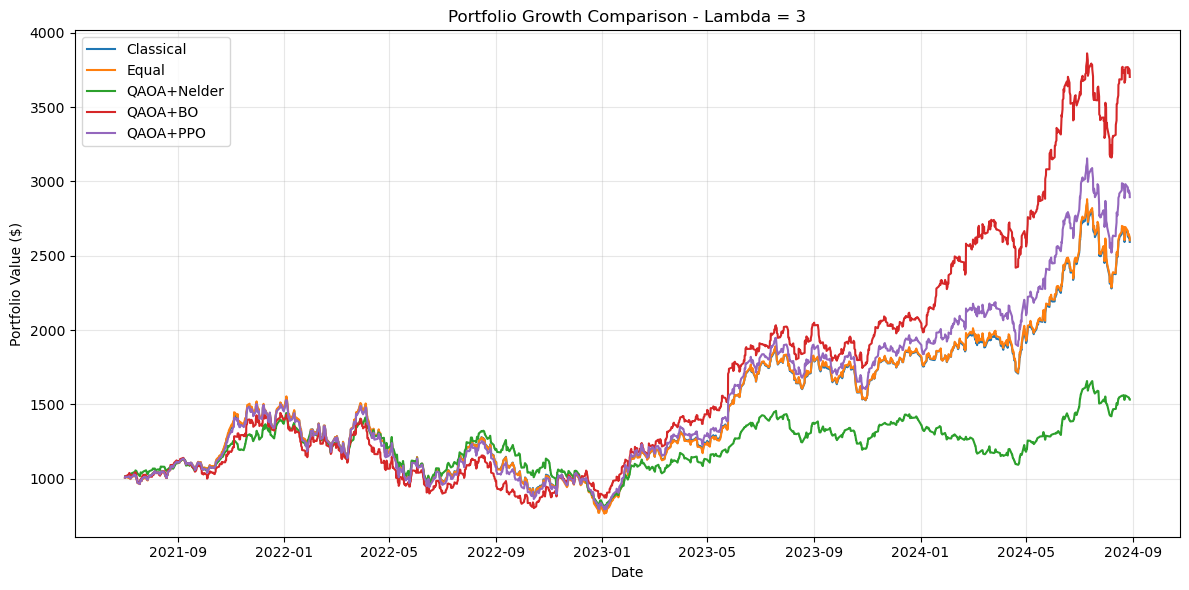

Total Return (%)  Annualized Return (%)  Volatility (%)  \
Portfolio                                                              
Classical             159.322                 35.237          21.506   
Equal                 160.417                 35.418          21.907   
QAOA+Nelder            53.179                 14.464          21.612   
QAOA+BO               270.311                 51.395          21.744   
QAOA+PPO              189.441                 40.028          21.180   

             Sharpe Ratio  
Portfolio                  
Classical           1.639  
Equal               1.617  
QAOA+Nelder         0.669  
QAOA+BO             2.364  
QAOA+PPO            1.890

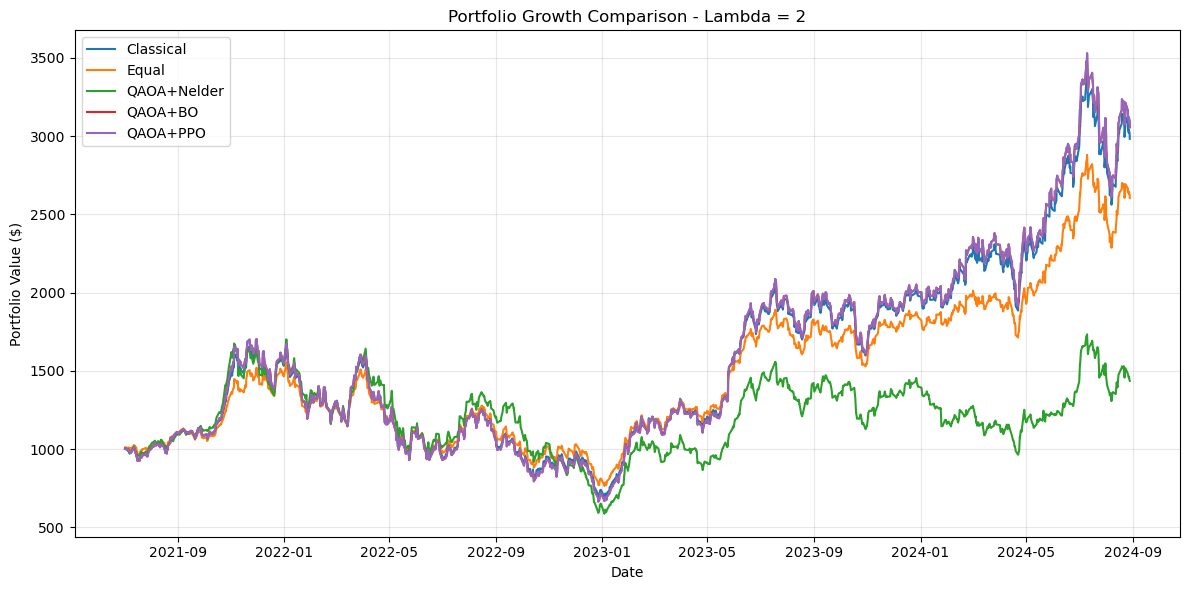

Total Return (%)  Annualized Return (%)  Volatility (%)  \
Portfolio                                                              
Classical             198.306                 41.372          26.843   
Equal                 160.417                 35.418          21.907   
QAOA+Nelder            43.565                 12.137          32.615   
QAOA+BO               205.700                 42.473          28.397   
QAOA+PPO              205.700                 42.473          28.397   

             Sharpe Ratio  
Portfolio                  
Classical           1.541  
Equal               1.617  
QAOA+Nelder         0.372  
QAOA+BO             1.496  
QAOA+PPO            1.496

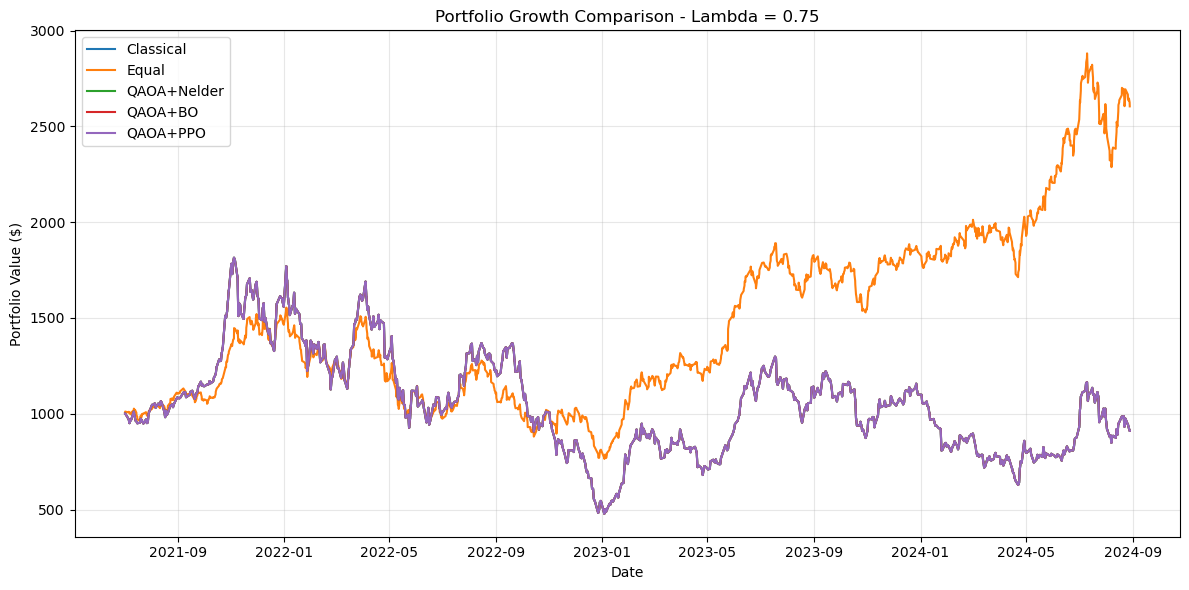

Total Return (%)  Annualized Return (%)  Volatility (%)  \
Portfolio                                                              
Classical              -8.949                 -2.926          41.269   
Equal                 160.417                 35.418          21.907   
QAOA+Nelder            -8.949                 -2.926          41.269   
QAOA+BO                -8.949                 -2.926          41.269   
QAOA+PPO               -8.949                 -2.926          41.269   

             Sharpe Ratio  
Portfolio                  
Classical          -0.071  
Equal               1.617  
QAOA+Nelder        -0.071  
QAOA+BO            -0.071  
QAOA+PPO           -0.071

In [81]:
portfolios = {
    'Classical': {'AAPL': 0.3716349567, 'NVDA': 0.3184987312, 'TSLA': 0.3098663121},
    'Equal':     {'AAPL': 0.33, 'NVDA': 0.33, 'TSLA': 0.33},
    'QAOA+Nelder': {'AAPL': 0.75, 'NVDA': 0.0, 'TSLA': 0.25},
    'QAOA+BO':     {'AAPL': 0.5, 'NVDA': 0.5, 'TSLA': 0.0},
    'QAOA+PPO':    {'AAPL': 0.375, 'NVDA': 0.375, 'TSLA': 0.25},
}
lam = 3

real_data_test(portfolios, lam)

print("")

portfolios = {
    'Classical': {'AAPL': 0.0741886144, 'NVDA': 0.4653835205, 'TSLA': 0.4604278651},
    'Equal':     {'AAPL': 0.33, 'NVDA': 0.33, 'TSLA': 0.33},
    'QAOA+Nelder': {'AAPL': 0.125, 'NVDA': 0.125, 'TSLA': 0.75},
    'QAOA+BO':     {'AAPL': 0, 'NVDA': 0.5, 'TSLA': 0.5},
    'QAOA+PPO':    {'AAPL': 0, 'NVDA': 0.5, 'TSLA': 0.5},
}
lam = 2

real_data_test(portfolios, lam)

print("")

portfolios = {
    'Classical': {'AAPL': 6.60E-17, 'NVDA': 3.21E-17, 'TSLA': 1},
    'Equal':     {'AAPL': 0.33, 'NVDA': 0.33, 'TSLA': 0.33},
    'QAOA+Nelder': {'AAPL': 0, 'NVDA': 0, 'TSLA': 1},
    'QAOA+BO':     {'AAPL': 0, 'NVDA': 0, 'TSLA': 1},
    'QAOA+PPO':    {'AAPL': 0, 'NVDA': 0, 'TSLA': 1},
}

lam = 0.75

real_data_test(portfolios, lam)

print("")

---

# Appendix

## Some unused BO optimisers

In [81]:
def bo_qaoa_multi_start(z_lin, z_pair, shots=4096, 
                        n_calls_per_start=40, n_starts=3):
    """
    Multi-start Bayesian Optimization - run BO from multiple initial points.
    This helps avoid local minima.
    """
    print("\n" + "="*60)
    print(f"MULTI-START BAYESIAN OPTIMIZATION ({n_starts} starts)")
    print("="*60)
    
    all_results = []
    all_histories = []
    
    for start_idx in range(n_starts):
        print(f"\n--- Start {start_idx + 1}/{n_starts} ---")
        
        # Use different random seeds for each start
        search_space = [Real(0, np.pi, name="beta"), Real(0, 2*np.pi, name="gamma")]
        
        eval_cache = {}
        eval_history = []
        
        @use_named_args(search_space)
        def objective(beta, gamma):
            n_repeats = 3
            key = (round(beta, 6), round(gamma, 6))
            
            if key in eval_cache:
                return eval_cache[key]
            
            energies = [evaluate_qaoa((beta, gamma), z_lin, z_pair, shots=shots) 
                        for _ in range(n_repeats)]
            avg_energy = float(np.mean(energies))
            
            eval_cache[key] = avg_energy
            eval_history.append({'beta': beta, 'gamma': gamma, 'energy': avg_energy})
            
            return avg_energy
        
        kernel = ConstantKernel(1.0) * RBF(length_scale=[0.5, 1.0])
        base_gp = SkoptGP(kernel=kernel, alpha=0.01**2, normalize_y=True)
        
        result = gp_minimize(
            func=objective,
            dimensions=search_space,
            n_calls=n_calls_per_start,
            n_random_starts=max(10, n_calls_per_start // 4),
            random_state=42 + start_idx,  # Different seed each time
            base_estimator=base_gp,
            acq_func="EI",
            xi=0.05,
            verbose=False
        )
        
        all_results.append(result)
        all_histories.append(eval_history)
        
        print(f"Start {start_idx + 1} result: E = {result.fun:.4f}, "
              f"β = {result.x[0]:.4f}, γ = {result.x[1]:.4f}")
    
    # Find best across all starts
    best_idx = np.argmin([r.fun for r in all_results])
    best_result = all_results[best_idx]
    
    print("\n" + "="*60)
    print("BEST RESULT ACROSS ALL STARTS:")
    print("="*60)
    print(f"Best start: {best_idx + 1}")
    print(f"Best β  = {best_result.x[0]:.6f}")
    print(f"Best γ  = {best_result.x[1]:.6f}")
    print(f"Energy  = {best_result.fun:.6f}")
    
    return best_result, all_results, all_histories

In [82]:
def bo_qaoa_hybrid(z_lin, z_pair, shots=4096):
    """
    Hybrid approach: Use BO for global search, then refine with local optimizer.
    """
    from scipy.optimize import minimize
    
    print("\n" + "="*60)
    print("HYBRID: BAYESIAN OPT + LOCAL REFINEMENT")
    print("="*60)
    
    # Phase 1: Bayesian Optimization for global search
    print("\nPhase 1: Global search with Bayesian Optimization...")
    result_bo, history = bo_qaoa_improved(
        z_lin, z_pair, 
        shots=shots, 
        n_calls=50, 
        n_random_starts=15
    )
    
    # Phase 2: Local refinement with Nelder-Mead
    print("\nPhase 2: Local refinement with Nelder-Mead...")
    
    def objective_local(params):
        energies = [evaluate_qaoa(params, z_lin, z_pair, shots=shots) 
                    for _ in range(5)]  # More repeats for final refinement
        return float(np.mean(energies))
    
    result_local = minimize(
        fun=objective_local,
        x0=result_bo.x,  # Start from BO result
        method='Nelder-Mead',
        options={'maxiter': 30, 'xatol': 1e-4, 'fatol': 1e-6}
    )
    
    # Ensure bounds
    result_local.x[0] = np.clip(result_local.x[0], 0, np.pi)
    result_local.x[1] = result_local.x[1] % (2*np.pi)
    
    print("\n" + "="*60)
    print("HYBRID RESULTS:")
    print("="*60)
    print(f"After BO:  E = {result_bo.fun:.6f}")
    print(f"After NM:  E = {result_local.fun:.6f}")
    print(f"Improvement: {result_bo.fun - result_local.fun:.6f}")
    print(f"\nFinal β  = {result_local.x[0]:.6f}")
    print(f"Final γ  = {result_local.x[1]:.6f}")
    
    return result_local, result_bo

## PPO Algorithms

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt
import pandas as pd

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ========================================
# Simple PPO Components (Back to Basics)
# ========================================

class QAOAPolicy(nn.Module):
    """Simple policy for 2D parameter space"""
    def __init__(self, init_mean=None, init_log_std=-0.5):
        super().__init__()
        if init_mean is None:
            init_mean = [np.pi/4, np.pi/4]
        
        self.mu = nn.Parameter(torch.tensor(init_mean, dtype=torch.float32))
        self.log_std = nn.Parameter(torch.ones(2) * init_log_std)
    
    def forward(self):
        mu = self.mu
        std = torch.exp(self.log_std).clamp(min=0.05, max=1.0)
        return mu, std
    
    def sample_action(self):
        mu, std = self.forward()
        dist = Normal(mu, std)
        action_raw = dist.sample()
        log_prob = dist.log_prob(action_raw).sum()
        
        # Project to bounds: beta in [0, pi], gamma in [0, 2pi)
        action = action_raw.clone()
        action[0] = torch.clamp(action[0], 0, np.pi)
        action[1] = torch.fmod(action[1], 2 * np.pi)
        action[1] = torch.where(action[1] < 0, action[1] + 2 * np.pi, action[1])
        
        return action, log_prob, action_raw
    
    def evaluate_actions(self, actions):
        mu, std = self.forward()
        dist = Normal(mu, std)
        log_probs = dist.log_prob(actions).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1)
        return log_probs, entropy


class QAOAValue(nn.Module):
    """Simple value baseline"""
    def __init__(self):
        super().__init__()
        self.baseline = nn.Parameter(torch.zeros(1))
    
    def forward(self, states):
        return self.baseline.expand(states.shape[0])


# ========================================
# Simple In-Memory Cache
# ========================================

class SimpleCache:
    """Lightweight in-memory cache with no disk I/O"""
    def __init__(self, precision=4):
        self.cache = {}
        self.precision = precision
        self.hits = 0
        self.misses = 0
    
    def get(self, beta, gamma):
        key = (round(beta, self.precision), round(gamma, self.precision))
        if key in self.cache:
            self.hits += 1
            return self.cache[key]
        self.misses += 1
        return None
    
    def set(self, beta, gamma, value):
        key = (round(beta, self.precision), round(gamma, self.precision))
        self.cache[key] = value
    
    def stats(self):
        total = self.hits + self.misses
        hit_rate = 100 * self.hits / total if total > 0 else 0
        return {'size': len(self.cache), 'hit_rate': hit_rate}


# ========================================
# Simple & Fast PPO Trainer
# ========================================

def train_ppo_simple(
    z_lin,
    z_pair,
    n_iterations=100,
    samples_per_iter=32,
    n_epochs=4,
    policy_lr=5e-3,          # Back to original
    value_lr=1e-2,
    clip_epsilon=0.2,
    entropy_coef=0.03,       # Back to original
    value_coef=0.5,
    max_grad_norm=0.5,
    init_mean=None,
    init_log_std=-0.5,       # Back to original (std=0.61)
    shots=1024,
    eval_shots=4096,
    eval_repeats=5,
    cache_precision=4,
    print_every=10
):
    """
    Simple PPO - back to basics with what worked in v1.
    Only improvement: proper early stopping logic.
    """
    if init_mean is None:
        init_mean = [np.pi/4, np.pi/4]
    
    # Initialize
    policy = QAOAPolicy(init_mean=init_mean, init_log_std=init_log_std).to(DEVICE)
    value_net = QAOAValue().to(DEVICE)
    
    policy_optimizer = optim.Adam(policy.parameters(), lr=policy_lr)
    value_optimizer = optim.Adam(value_net.parameters(), lr=value_lr)
    
    # Simple in-memory cache
    cache = SimpleCache(precision=cache_precision)
    
    # Tracking
    energy_history = []
    param_history = []
    best_energy = float('inf')
    best_params = None
    
    print("="*70)
    print("Simple & Fast PPO for QAOA (v5 - Back to Basics)")
    print("="*70)
    print(f"Device: {DEVICE}")
    print(f"Samples/iter: {samples_per_iter}, Epochs: {n_epochs}")
    print(f"Training shots: {shots}")
    print(f"Initial LR: policy={policy_lr:.0e}, value={value_lr:.0e}")
    print(f"Initial std: {np.exp(init_log_std):.3f}, entropy: {entropy_coef:.3f}")
    print(f"Clip: {clip_epsilon}")
    print("="*70 + "\n")
    
    for iteration in range(1, n_iterations + 1):
        # Collect batch
        actions_list = []
        actions_raw_list = []
        log_probs_list = []
        rewards_list = []
        
        for _ in range(samples_per_iter):
            with torch.no_grad():
                action, log_prob, action_raw = policy.sample_action()
            
            beta = action[0].item()
            gamma = action[1].item()
            params = (beta, gamma)
            
            # Try cache
            energy = cache.get(beta, gamma)
            if energy is None:
                energy = evaluate_qaoa(params, z_lin, z_pair, shots=shots)
                cache.set(beta, gamma, energy)
            
            reward = -energy
            
            actions_list.append(action)
            actions_raw_list.append(action_raw)
            log_probs_list.append(log_prob)
            rewards_list.append(reward)
            
            if energy < best_energy:
                best_energy = energy
                best_params = params
        
        # Convert to tensors
        actions_raw = torch.stack(actions_raw_list).to(DEVICE)
        old_log_probs = torch.stack(log_probs_list).to(DEVICE)
        rewards = torch.tensor(rewards_list, dtype=torch.float32).to(DEVICE)
        
        # Compute advantages (simple TD residual)
        with torch.no_grad():
            values = value_net(actions_raw)
            advantages = rewards - values
            returns = rewards
            
            # Normalize advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # PPO update
        for epoch in range(n_epochs):
            # Policy
            new_log_probs, entropy = policy.evaluate_actions(actions_raw)
            ratio = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
            
            policy_loss = -torch.min(surr1, surr2).mean()
            entropy_loss = -entropy_coef * entropy.mean()
            total_policy_loss = policy_loss + entropy_loss
            
            policy_optimizer.zero_grad()
            total_policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy.parameters(), max_grad_norm)
            policy_optimizer.step()
            
            # Value
            values_pred = value_net(actions_raw)
            value_loss = value_coef * nn.MSELoss()(values_pred, returns)
            
            value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(value_net.parameters(), max_grad_norm)
            value_optimizer.step()
        
        # Logging
        avg_energy = -rewards.mean().item()
        min_energy = -rewards.max().item()
        
        energy_history.append(avg_energy)
        
        with torch.no_grad():
            mu, std = policy.forward()
            current_beta = torch.clamp(mu[0], 0, np.pi).item()
            current_gamma = torch.fmod(mu[1], 2 * np.pi).item()
            if current_gamma < 0:
                current_gamma += 2 * np.pi
            param_history.append([current_beta, current_gamma])
            current_std = std.cpu().numpy()
        
        if iteration % print_every == 0 or iteration == 1:
            cache_stats = cache.stats()
            print(f"[{iteration:3d}] E_avg={avg_energy:7.2f} E_min={min_energy:7.2f} "
                  f"E_best={best_energy:7.2f} | β={current_beta:.3f} γ={current_gamma:.3f} | "
                  f"σ=[{current_std[0]:.2f},{current_std[1]:.2f}] | cache={cache_stats['hit_rate']:.0f}%")
    
    # Final evaluation
    print("\n" + "="*70)
    print("FINAL EVALUATION")
    print("="*70)
    
    energies_best = []
    for _ in range(eval_repeats):
        e = evaluate_qaoa(best_params, z_lin, z_pair, shots=eval_shots)
        energies_best.append(e)
    final_energy_best = float(np.mean(energies_best))
    std_energy_best = float(np.std(energies_best))
    
    final_params = (current_beta, current_gamma)
    energies_mean = []
    for _ in range(eval_repeats):
        e = evaluate_qaoa(final_params, z_lin, z_pair, shots=eval_shots)
        energies_mean.append(e)
    final_energy_mean = float(np.mean(energies_mean))
    
    print(f"\nBest sample: E={final_energy_best:.4f}±{std_energy_best:.4f} "
          f"β={best_params[0]:.4f} γ={best_params[1]:.4f}")
    print(f"Final mean:  E={final_energy_mean:.4f} "
          f"β={final_params[0]:.4f} γ={final_params[1]:.4f}")
    
    cache_stats = cache.stats()
    print(f"\nCache: {cache_stats['size']} entries, {cache_stats['hit_rate']:.1f}% hit rate")
    
    recommended = best_params if final_energy_best < final_energy_mean else final_params
    recommended_energy = min(final_energy_best, final_energy_mean)
    
    print(f"\n{'='*70}")
    print(f"RECOMMENDED: β={recommended[0]:.6f} γ={recommended[1]:.6f} E={recommended_energy:.4f}")
    print("="*70)
    
    plot_ppo_results(energy_history, param_history, best_params, final_params, best_energy)
    
    return {
        'policy': policy,
        'value_net': value_net,
        'best_params': best_params,
        'best_energy': final_energy_best,
        'final_params': final_params,
        'final_energy': final_energy_mean,
        'energy_history': energy_history,
        'param_history': param_history,
        'recommended_params': recommended,
        'recommended_energy': recommended_energy
    }


def plot_ppo_results(energy_history, param_history, best_params, final_params, best_energy):
    """Visualize results"""
    param_history = np.array(param_history)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Energy
    ax1 = axes[0]
    ax1.plot(energy_history, alpha=0.4, color='blue')
    window = min(15, len(energy_history) // 5)
    if window > 1:
        rolling = pd.Series(energy_history).rolling(window=window, min_periods=1).mean()
        ax1.plot(rolling.values, linewidth=2, color='darkblue', label=f'Rolling ({window})')
    ax1.axhline(y=best_energy, color='red', linestyle='--', linewidth=2, 
                label=f'Best: {best_energy:.2f}')
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Energy', fontsize=12)
    ax1.set_title('Training Progress', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Parameters
    ax2 = axes[1]
    ax2.plot(param_history[:, 0], label='β', linewidth=2, color='blue')
    ax2.plot(param_history[:, 1], label='γ', linewidth=2, color='green')
    ax2.axhline(y=best_params[0], color='blue', linestyle='--', alpha=0.5)
    ax2.axhline(y=best_params[1], color='green', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Parameter (rad)', fontsize=12)
    ax2.set_title('Parameter Evolution', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Space
    ax3 = axes[2]
    iterations = np.arange(len(param_history))
    scatter = ax3.scatter(param_history[:, 0], param_history[:, 1],
                         c=iterations, cmap='viridis', s=30, alpha=0.6)
    ax3.plot(best_params[0], best_params[1], 'r*', markersize=20,
            label='Best', markeredgecolor='black', markeredgewidth=1.5, zorder=5)
    ax3.plot(final_params[0], final_params[1], 'bs', markersize=12,
            label='Final', markeredgecolor='black', markeredgewidth=1.5, zorder=5)
    ax3.set_xlabel('β', fontsize=12)
    ax3.set_ylabel('γ', fontsize=12)
    ax3.set_xlim(0, np.pi)
    ax3.set_ylim(0, 2*np.pi)
    ax3.set_title('Parameter Space', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Iteration')
    
    plt.tight_layout()
    plt.show()


def multi_start_ppo_simple(z_lin, z_pair, n_starts=3, **kwargs):
    """Multi-start with simple PPO"""
    print("\n" + "="*70)
    print(f"MULTI-START SIMPLE PPO ({n_starts} starts)")
    print("="*70 + "\n")
    
    init_means = [
        [np.pi/4, np.pi/4],
        [np.pi/2, np.pi],
        [np.pi/3, 3*np.pi/2]
    ][:n_starts]
    
    all_results = []
    
    for i, init_mean in enumerate(init_means):
        print(f"\n{'='*70}")
        print(f"Start {i+1}/{n_starts} - β={init_mean[0]:.3f}, γ={init_mean[1]:.3f}")
        print("="*70 + "\n")
        
        result = train_ppo_simple(
            z_lin, z_pair,
            init_mean=init_mean,
            print_every=15,
            **kwargs
        )
        all_results.append(result)
        print(f"\nStart {i+1}: E={result['recommended_energy']:.4f}\n")
    
    best_result = min(all_results, key=lambda x: x['recommended_energy'])
    
    print("\n" + "="*70)
    print("BEST ACROSS ALL STARTS")
    print("="*70)
    print(f"Energy: {best_result['recommended_energy']:.4f}")
    print(f"β={best_result['recommended_params'][0]:.6f} "
          f"γ={best_result['recommended_params'][1]:.6f}")
    print("="*70)
    
    return best_result, all_results


# ========================================
# USAGE
# ========================================

# Simple and effective - just like v1 but cleaner
result = train_ppo_simple(
    z_lin, z_pair,
    n_iterations=100,
    samples_per_iter=32,
    n_epochs=4,
    shots=1024,
    policy_lr=5e-3,
    entropy_coef=0.03,
    init_log_std=-0.5
)

# Multi-start
best, all_results = multi_start_ppo_simple(
    z_lin, z_pair,
    n_starts=3,
    n_iterations=60,
    samples_per_iter=24
)

# What's different from v1:
# - Cleaner code structure
# - Lightweight in-memory cache (no disk I/O)
# - Proper parameter bounds enforcement
# - Better visualization
# 
# What's the SAME as v1 (the good stuff):
# - Aggressive exploration (std=0.61, entropy=0.03)
# - Higher learning rates (5e-3)
# - More update epochs (4)
# - Simple and fast!
#
# Expected: Similar to v1 results (E ~ -40), runtime ~20-25 min


Simple & Fast PPO for QAOA (v5 - Back to Basics)
Device: cpu
Samples/iter: 32, Epochs: 4
Training shots: 1024
Initial LR: policy=5e-03, value=1e-02
Initial std: 0.607, entropy: 0.030
Clip: 0.2

[  1] E_avg=   3.17 E_min= -29.66 E_best= -29.66 | β=0.805 γ=0.805 | σ=[0.62,0.62] | cache=0%
[ 10] E_avg=  -1.84 E_min= -28.90 E_best= -32.05 | β=0.906 γ=0.972 | σ=[0.69,0.65] | cache=0%
[ 20] E_avg=   0.67 E_min= -10.11 E_best= -32.05 | β=0.913 γ=1.130 | σ=[0.63,0.67] | cache=0%
[ 30] E_avg=  -3.16 E_min= -17.27 E_best= -32.05 | β=0.936 γ=1.305 | σ=[0.65,0.64] | cache=0%
[ 40] E_avg=  -1.82 E_min= -17.14 E_best= -32.05 | β=0.995 γ=1.427 | σ=[0.60,0.58] | cache=0%
[ 50] E_avg=  -0.74 E_min= -15.73 E_best= -32.77 | β=1.028 γ=1.486 | σ=[0.54,0.61] | cache=0%
[ 60] E_avg=  -2.67 E_min= -11.67 E_best= -32.77 | β=1.100 γ=1.582 | σ=[0.52,0.61] | cache=0%
[ 70] E_avg=  -1.61 E_min= -29.20 E_best= -32.77 | β=0.898 γ=1.677 | σ=[0.49,0.60] | cache=0%
[ 80] E_avg=  -4.17 E_min= -24.53 E_best= -32.77 | β=0

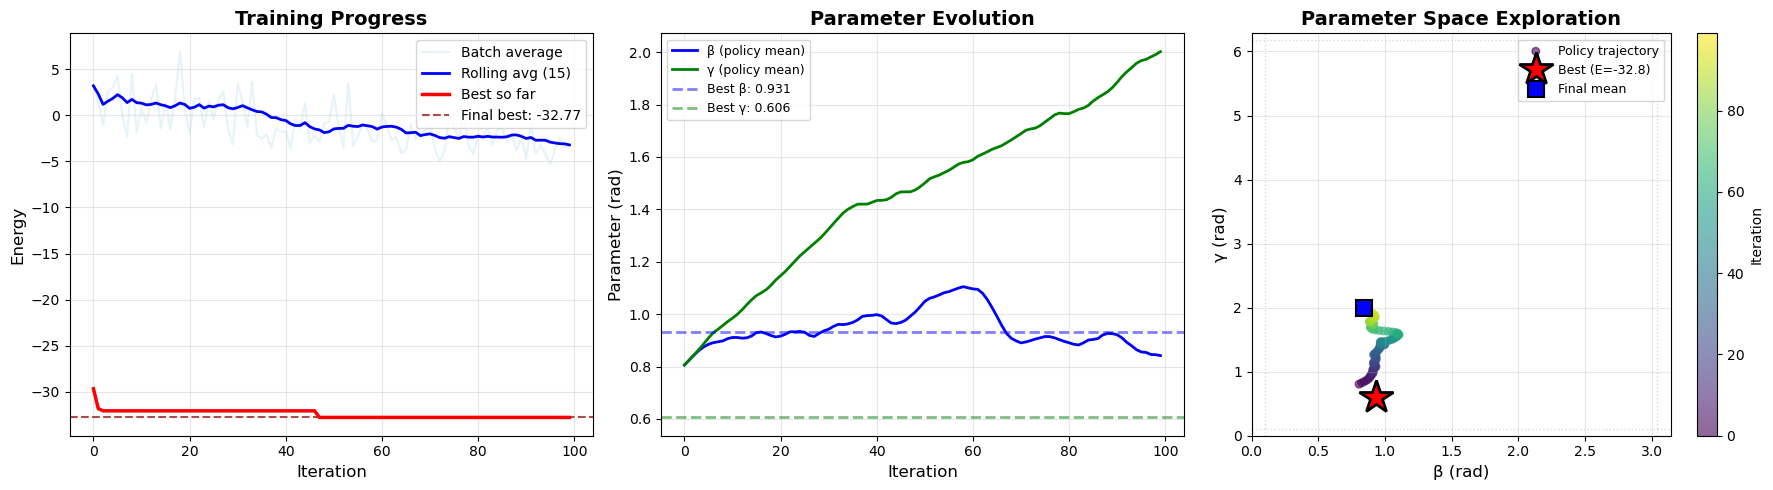


MULTI-START SIMPLE PPO (5 starts)
Including boundary exploration strategies


Start 1/5 - β=0.785, γ=0.785

Simple & Fast PPO for QAOA (v5 - Back to Basics)
Device: cpu
Samples/iter: 24, Epochs: 4
Training shots: 1024
Initial LR: policy=5e-03, value=1e-02
Initial std: 0.607, entropy: 0.030
Clip: 0.2

[  1] E_avg=   0.08 E_min= -30.55 E_best= -30.55 | β=0.805 γ=0.805 | σ=[0.62,0.59] | cache=0%
[ 15] E_avg=  -0.87 E_min= -11.78 E_best= -32.30 | β=0.754 γ=1.096 | σ=[0.66,0.53] | cache=0%
[ 30] E_avg=  -1.87 E_min=  -8.00 E_best= -32.30 | β=0.684 γ=1.277 | σ=[0.58,0.49] | cache=0%
[ 45] E_avg=  -0.58 E_min=  -8.30 E_best= -32.30 | β=0.695 γ=1.468 | σ=[0.51,0.52] | cache=0%
[ 60] E_avg=  -2.49 E_min=  -9.73 E_best= -32.30 | β=0.738 γ=1.670 | σ=[0.40,0.52] | cache=0%

FINAL EVALUATION

Best sample: E=-32.6786±0.3852 β=0.8456 γ=0.6123
Final mean:  E=-4.4684 β=0.7378 γ=1.6704

Cache: 1439 entries, 0.1% hit rate

RECOMMENDED: β=0.845645 γ=0.612335 E=-32.6786


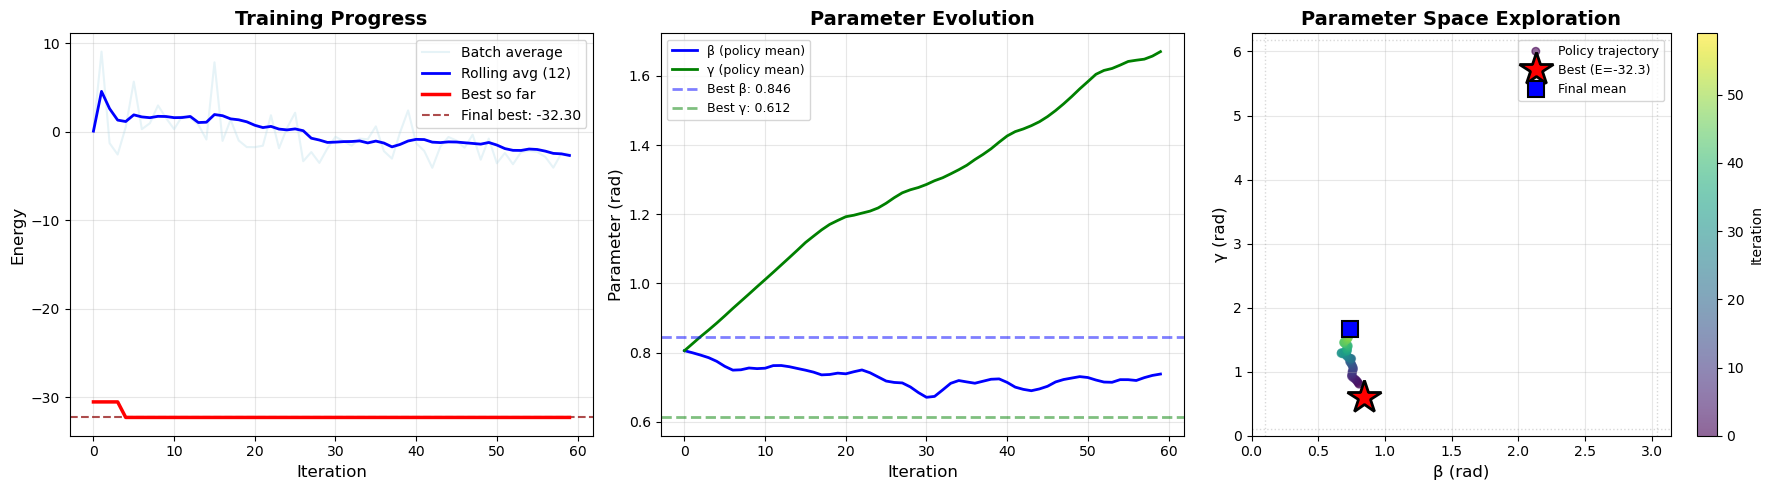


Start 1: E=-32.6786


Start 2/5 - β=1.571, γ=3.142

Simple & Fast PPO for QAOA (v5 - Back to Basics)
Device: cpu
Samples/iter: 24, Epochs: 4
Training shots: 1024
Initial LR: policy=5e-03, value=1e-02
Initial std: 0.607, entropy: 0.030
Clip: 0.2

[  1] E_avg=  -0.18 E_min= -12.45 E_best= -12.45 | β=1.591 γ=3.122 | σ=[0.62,0.59] | cache=0%
[ 15] E_avg=  -0.39 E_min= -16.47 E_best= -18.81 | β=1.641 γ=2.896 | σ=[0.69,0.61] | cache=0%
[ 30] E_avg=  -0.15 E_min=  -8.52 E_best= -18.81 | β=1.609 γ=2.629 | σ=[0.74,0.59] | cache=0%
[ 45] E_avg=  -1.89 E_min= -15.05 E_best= -21.65 | β=1.562 γ=2.481 | σ=[0.79,0.56] | cache=0%
[ 60] E_avg=  -1.35 E_min= -11.18 E_best= -21.65 | β=1.505 γ=2.320 | σ=[0.76,0.48] | cache=0%

FINAL EVALUATION

Best sample: E=-21.7149±0.4934 β=1.0678 γ=0.6980
Final mean:  E=-0.8870 β=1.5050 γ=2.3198

Cache: 1440 entries, 0.0% hit rate

RECOMMENDED: β=1.067822 γ=0.698024 E=-21.7149


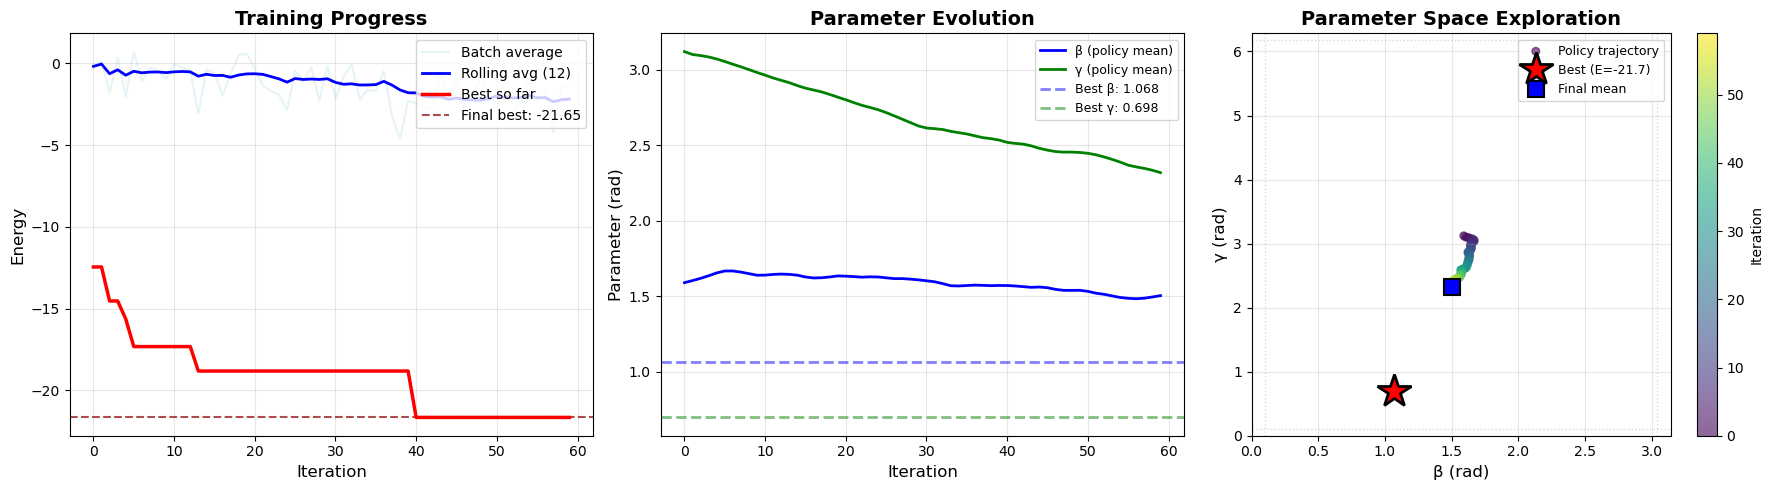


Start 2: E=-21.7149


Start 3/5 - β=0.200, γ=0.100
  Strategy: Low β boundary exploration
  Strategy: γ boundary exploration

Simple & Fast PPO for QAOA (v5 - Back to Basics)
Device: cpu
Samples/iter: 24, Epochs: 4
Training shots: 1024
Initial LR: policy=5e-03, value=1e-02
Initial std: 0.607, entropy: 0.030
Clip: 0.2

[  1] E_avg=   8.80 E_min= -24.16 E_best= -24.16 | β=0.180 γ=0.120 | σ=[0.59,0.62] | cache=0%
[ 15] E_avg=   0.58 E_min= -16.30 E_best= -30.51 | β=0.030 γ=0.202 | σ=[0.68,0.80] | cache=0%
[ 30] E_avg=   3.32 E_min= -11.64 E_best= -30.51 | β=0.000 γ=0.368 | σ=[0.73,0.97] | cache=1%
[ 45] E_avg=   2.79 E_min= -17.84 E_best= -31.61 | β=0.000 γ=0.593 | σ=[0.76,1.00] | cache=0%
[ 60] E_avg=   1.53 E_min= -12.06 E_best= -31.61 | β=0.000 γ=0.839 | σ=[0.77,1.00] | cache=1%

FINAL EVALUATION

Best sample: E=-31.7178±0.1579 β=1.0579 γ=0.6077
Final mean:  E=0.6037 β=0.0000 γ=0.8390

Cache: 1432 entries, 0.6% hit rate

RECOMMENDED: β=1.057902 γ=0.607689 E=-31.7178


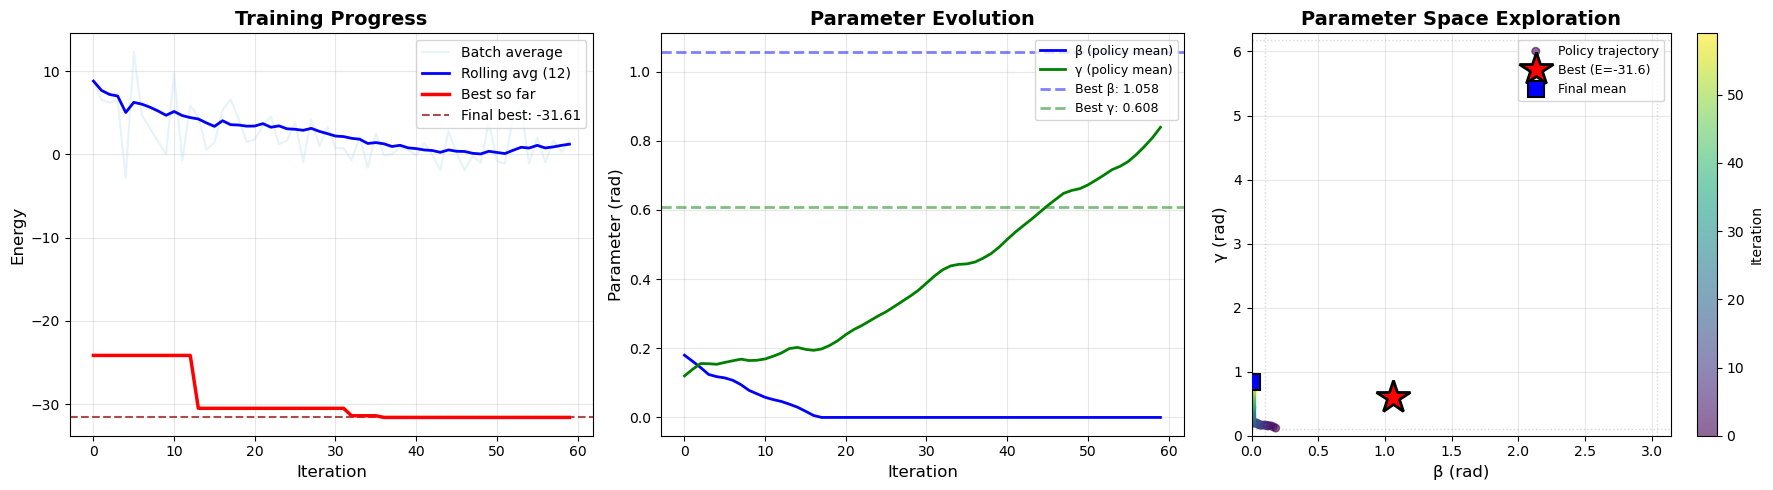


Start 3: E=-31.7178


Start 4/5 - β=2.800, γ=0.100
  Strategy: High β boundary exploration
  Strategy: γ boundary exploration

Simple & Fast PPO for QAOA (v5 - Back to Basics)
Device: cpu
Samples/iter: 24, Epochs: 4
Training shots: 1024
Initial LR: policy=5e-03, value=1e-02
Initial std: 0.607, entropy: 0.030
Clip: 0.2

[  1] E_avg=  -0.81 E_min= -30.44 E_best= -30.44 | β=2.780 γ=0.120 | σ=[0.60,0.59] | cache=0%
[ 15] E_avg=   1.66 E_min=  -9.79 E_best= -50.84 | β=2.904 γ=0.197 | σ=[0.65,0.74] | cache=0%
[ 30] E_avg=  -2.19 E_min= -21.13 E_best= -50.84 | β=3.121 γ=0.283 | σ=[0.72,0.94] | cache=0%
[ 45] E_avg=  -2.46 E_min= -46.99 E_best= -50.84 | β=3.142 γ=0.337 | σ=[0.82,1.00] | cache=1%
[ 60] E_avg=   0.30 E_min= -31.62 E_best= -50.84 | β=3.142 γ=0.363 | σ=[0.83,1.00] | cache=0%

FINAL EVALUATION

Best sample: E=-50.6728±0.1824 β=2.7029 γ=0.0455
Final mean:  E=0.4112 β=3.1416 γ=0.3626

Cache: 1433 entries, 0.5% hit rate

RECOMMENDED: β=2.702866 γ=0.045473 E=-50.6728


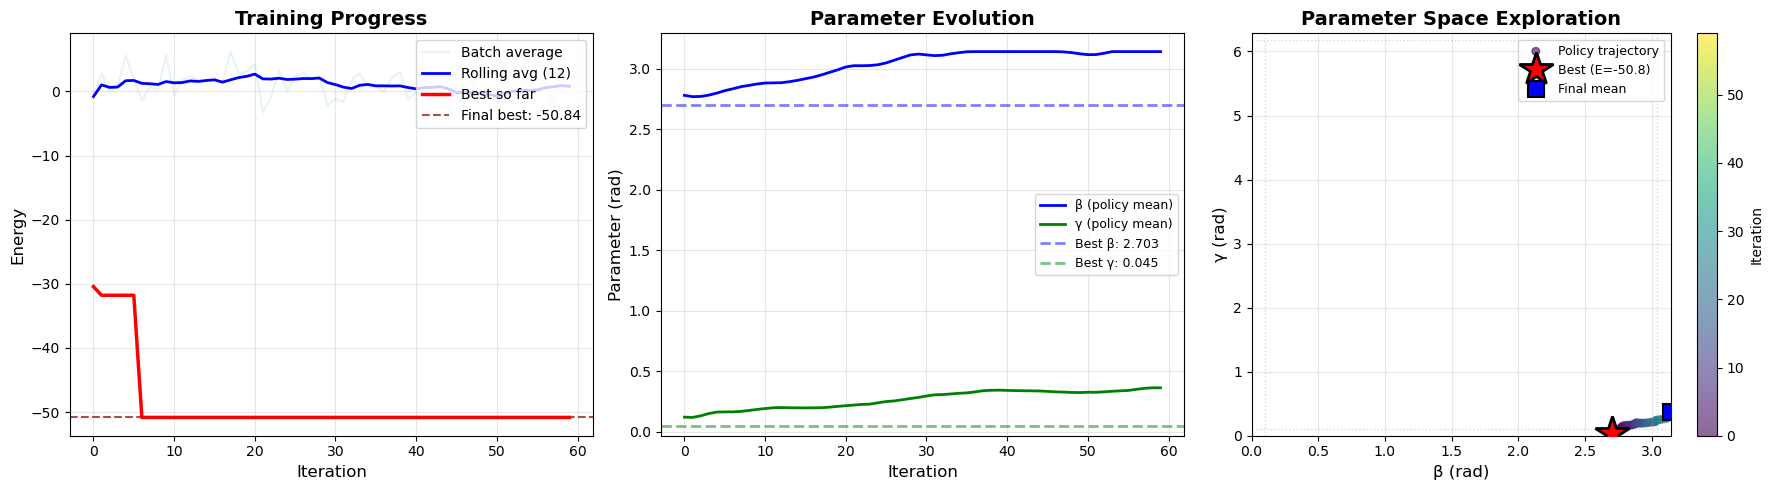


Start 4: E=-50.6728


Start 5/5 - β=1.571, γ=5.500

Simple & Fast PPO for QAOA (v5 - Back to Basics)
Device: cpu
Samples/iter: 24, Epochs: 4
Training shots: 1024
Initial LR: policy=5e-03, value=1e-02
Initial std: 0.607, entropy: 0.030
Clip: 0.2

[  1] E_avg=   7.61 E_min=  -8.86 E_best=  -8.86 | β=1.591 γ=5.480 | σ=[0.62,0.59] | cache=0%
[ 15] E_avg=  -0.73 E_min= -24.59 E_best= -24.59 | β=1.693 γ=5.378 | σ=[0.63,0.50] | cache=0%
[ 30] E_avg=   1.88 E_min=  -7.20 E_best= -38.41 | β=1.690 γ=5.324 | σ=[0.64,0.46] | cache=0%
[ 45] E_avg=  -0.48 E_min= -31.69 E_best= -38.41 | β=1.759 γ=5.256 | σ=[0.67,0.45] | cache=0%
[ 60] E_avg=  -1.52 E_min= -45.08 E_best= -45.08 | β=1.826 γ=5.136 | σ=[0.76,0.51] | cache=0%

FINAL EVALUATION

Best sample: E=-45.3409±0.1833 β=2.4697 γ=0.0516
Final mean:  E=-5.7899 β=1.8262 γ=5.1363

Cache: 1440 entries, 0.0% hit rate

RECOMMENDED: β=2.469728 γ=0.051623 E=-45.3409


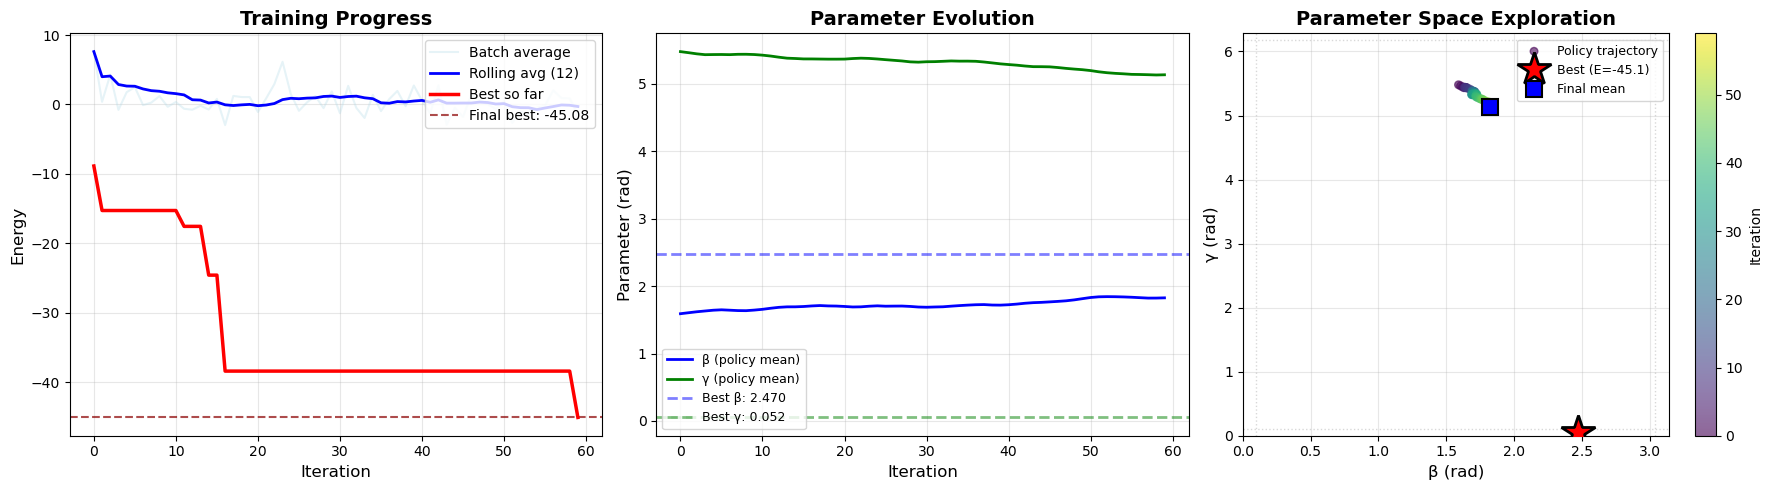


Start 5: E=-45.3409


BEST ACROSS ALL STARTS
Energy: -50.6728
β=2.702866 γ=0.045473

ALL RESULTS (sorted by energy):
1. E= -50.67 | β=2.7029 γ=0.0455
2. E= -45.34 | β=2.4697 γ=0.0516
3. E= -32.68 | β=0.8456 γ=0.6123
4. E= -31.72 | β=1.0579 γ=0.6077
5. E= -21.71 | β=1.0678 γ=0.6980


In [44]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt
import pandas as pd

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ========================================
# Simple PPO Components (Back to Basics)
# ========================================

class QAOAPolicy(nn.Module):
    """Simple policy for 2D parameter space"""
    def __init__(self, init_mean=None, init_log_std=-0.5):
        super().__init__()
        if init_mean is None:
            init_mean = [np.pi/4, np.pi/4]
        
        self.mu = nn.Parameter(torch.tensor(init_mean, dtype=torch.float32))
        self.log_std = nn.Parameter(torch.ones(2) * init_log_std)
    
    def forward(self):
        mu = self.mu
        std = torch.exp(self.log_std).clamp(min=0.05, max=1.0)
        return mu, std
    
    def sample_action(self):
        mu, std = self.forward()
        dist = Normal(mu, std)
        action_raw = dist.sample()
        log_prob = dist.log_prob(action_raw).sum()
        
        # Project to bounds: beta in [0, pi], gamma in [0, 2pi)
        action = action_raw.clone()
        action[0] = torch.clamp(action[0], 0, np.pi)
        action[1] = torch.fmod(action[1], 2 * np.pi)
        action[1] = torch.where(action[1] < 0, action[1] + 2 * np.pi, action[1])
        
        return action, log_prob, action_raw
    
    def evaluate_actions(self, actions):
        mu, std = self.forward()
        dist = Normal(mu, std)
        log_probs = dist.log_prob(actions).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1)
        return log_probs, entropy


class QAOAValue(nn.Module):
    """Simple value baseline"""
    def __init__(self):
        super().__init__()
        self.baseline = nn.Parameter(torch.zeros(1))
    
    def forward(self, states):
        return self.baseline.expand(states.shape[0])


# ========================================
# Simple In-Memory Cache
# ========================================

class SimpleCache:
    """Lightweight in-memory cache with no disk I/O"""
    def __init__(self, precision=4):
        self.cache = {}
        self.precision = precision
        self.hits = 0
        self.misses = 0
    
    def get(self, beta, gamma):
        key = (round(beta, self.precision), round(gamma, self.precision))
        if key in self.cache:
            self.hits += 1
            return self.cache[key]
        self.misses += 1
        return None
    
    def set(self, beta, gamma, value):
        key = (round(beta, self.precision), round(gamma, self.precision))
        self.cache[key] = value
    
    def stats(self):
        total = self.hits + self.misses
        hit_rate = 100 * self.hits / total if total > 0 else 0
        return {'size': len(self.cache), 'hit_rate': hit_rate}


# ========================================
# Simple & Fast PPO Trainer
# ========================================

def train_ppo_simple(
    z_lin,
    z_pair,
    n_iterations=100,
    samples_per_iter=32,
    n_epochs=4,
    policy_lr=5e-3,          # Back to original
    value_lr=1e-2,
    clip_epsilon=0.2,
    entropy_coef=0.03,       # Back to original
    value_coef=0.5,
    max_grad_norm=0.5,
    init_mean=None,
    init_log_std=-0.5,       # Back to original (std=0.61)
    shots=1024,
    eval_shots=4096,
    eval_repeats=5,
    cache_precision=4,
    print_every=10
):
    """
    Simple PPO - back to basics with what worked in v1.
    Only improvement: proper early stopping logic.
    """
    if init_mean is None:
        init_mean = [np.pi/4, np.pi/4]
    
    # Initialize
    policy = QAOAPolicy(init_mean=init_mean, init_log_std=init_log_std).to(DEVICE)
    value_net = QAOAValue().to(DEVICE)
    
    policy_optimizer = optim.Adam(policy.parameters(), lr=policy_lr)
    value_optimizer = optim.Adam(value_net.parameters(), lr=value_lr)
    
    # Simple in-memory cache
    cache = SimpleCache(precision=cache_precision)
    
    # Tracking
    energy_history = []
    param_history = []
    best_energy_history = []  # Track best-so-far over time
    best_energy = float('inf')
    best_params = None
    
    print("="*70)
    print("Simple & Fast PPO for QAOA (v5 - Back to Basics)")
    print("="*70)
    print(f"Device: {DEVICE}")
    print(f"Samples/iter: {samples_per_iter}, Epochs: {n_epochs}")
    print(f"Training shots: {shots}")
    print(f"Initial LR: policy={policy_lr:.0e}, value={value_lr:.0e}")
    print(f"Initial std: {np.exp(init_log_std):.3f}, entropy: {entropy_coef:.3f}")
    print(f"Clip: {clip_epsilon}")
    print("="*70 + "\n")
    
    for iteration in range(1, n_iterations + 1):
        # Collect batch
        actions_list = []
        actions_raw_list = []
        log_probs_list = []
        rewards_list = []
        
        for _ in range(samples_per_iter):
            with torch.no_grad():
                action, log_prob, action_raw = policy.sample_action()
            
            beta = action[0].item()
            gamma = action[1].item()
            params = (beta, gamma)
            
            # Try cache
            energy = cache.get(beta, gamma)
            if energy is None:
                energy = evaluate_qaoa(params, z_lin, z_pair, shots=shots)
                cache.set(beta, gamma, energy)
            
            reward = -energy
            
            actions_list.append(action)
            actions_raw_list.append(action_raw)
            log_probs_list.append(log_prob)
            rewards_list.append(reward)
            
            if energy < best_energy:
                best_energy = energy
                best_params = params
        
        # Convert to tensors
        actions_raw = torch.stack(actions_raw_list).to(DEVICE)
        old_log_probs = torch.stack(log_probs_list).to(DEVICE)
        rewards = torch.tensor(rewards_list, dtype=torch.float32).to(DEVICE)
        
        # Compute advantages (simple TD residual)
        with torch.no_grad():
            values = value_net(actions_raw)
            advantages = rewards - values
            returns = rewards
            
            # Normalize advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # PPO update
        for epoch in range(n_epochs):
            # Policy
            new_log_probs, entropy = policy.evaluate_actions(actions_raw)
            ratio = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
            
            policy_loss = -torch.min(surr1, surr2).mean()
            entropy_loss = -entropy_coef * entropy.mean()
            total_policy_loss = policy_loss + entropy_loss
            
            policy_optimizer.zero_grad()
            total_policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy.parameters(), max_grad_norm)
            policy_optimizer.step()
            
            # Value
            values_pred = value_net(actions_raw)
            value_loss = value_coef * nn.MSELoss()(values_pred, returns)
            
            value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(value_net.parameters(), max_grad_norm)
            value_optimizer.step()
        
        # Logging
        avg_energy = -rewards.mean().item()
        min_energy = -rewards.max().item()
        
        energy_history.append(avg_energy)
        best_energy_history.append(best_energy)  # Track best so far
        
        with torch.no_grad():
            mu, std = policy.forward()
            current_beta = torch.clamp(mu[0], 0, np.pi).item()
            current_gamma = torch.fmod(mu[1], 2 * np.pi).item()
            if current_gamma < 0:
                current_gamma += 2 * np.pi
            param_history.append([current_beta, current_gamma])
            current_std = std.cpu().numpy()
        
        if iteration % print_every == 0 or iteration == 1:
            cache_stats = cache.stats()
            print(f"[{iteration:3d}] E_avg={avg_energy:7.2f} E_min={min_energy:7.2f} "
                  f"E_best={best_energy:7.2f} | β={current_beta:.3f} γ={current_gamma:.3f} | "
                  f"σ=[{current_std[0]:.2f},{current_std[1]:.2f}] | cache={cache_stats['hit_rate']:.0f}%")
    
    # Final evaluation
    print("\n" + "="*70)
    print("FINAL EVALUATION")
    print("="*70)
    
    energies_best = []
    for _ in range(eval_repeats):
        e = evaluate_qaoa(best_params, z_lin, z_pair, shots=eval_shots)
        energies_best.append(e)
    final_energy_best = float(np.mean(energies_best))
    std_energy_best = float(np.std(energies_best))
    
    final_params = (current_beta, current_gamma)
    energies_mean = []
    for _ in range(eval_repeats):
        e = evaluate_qaoa(final_params, z_lin, z_pair, shots=eval_shots)
        energies_mean.append(e)
    final_energy_mean = float(np.mean(energies_mean))
    
    print(f"\nBest sample: E={final_energy_best:.4f}±{std_energy_best:.4f} "
          f"β={best_params[0]:.4f} γ={best_params[1]:.4f}")
    print(f"Final mean:  E={final_energy_mean:.4f} "
          f"β={final_params[0]:.4f} γ={final_params[1]:.4f}")
    
    cache_stats = cache.stats()
    print(f"\nCache: {cache_stats['size']} entries, {cache_stats['hit_rate']:.1f}% hit rate")
    
    recommended = best_params if final_energy_best < final_energy_mean else final_params
    recommended_energy = min(final_energy_best, final_energy_mean)
    
    print(f"\n{'='*70}")
    print(f"RECOMMENDED: β={recommended[0]:.6f} γ={recommended[1]:.6f} E={recommended_energy:.4f}")
    print("="*70)
    
    plot_ppo_results(energy_history, param_history, best_params, final_params, 
                     best_energy, best_history=best_energy_history)
    
    return {
        'policy': policy,
        'value_net': value_net,
        'best_params': best_params,
        'best_energy': final_energy_best,
        'final_params': final_params,
        'final_energy': final_energy_mean,
        'energy_history': energy_history,
        'param_history': param_history,
        'recommended_params': recommended,
        'recommended_energy': recommended_energy
    }


def plot_ppo_results(energy_history, param_history, best_params, final_params, best_energy, best_history=None):
    """Visualize results with best-so-far tracking"""
    param_history = np.array(param_history)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Energy with best-so-far
    ax1 = axes[0]
    ax1.plot(energy_history, alpha=0.3, color='lightblue', label='Batch average')
    
    # Rolling average
    window = min(15, len(energy_history) // 5)
    if window > 1:
        rolling = pd.Series(energy_history).rolling(window=window, min_periods=1).mean()
        ax1.plot(rolling.values, linewidth=2, color='blue', label=f'Rolling avg ({window})')
    
    # Best-so-far trajectory
    if best_history is not None:
        ax1.plot(best_history, linewidth=2.5, color='red', linestyle='-', 
                label='Best so far', zorder=10)
    
    ax1.axhline(y=best_energy, color='darkred', linestyle='--', linewidth=1.5, 
                alpha=0.7, label=f'Final best: {best_energy:.2f}')
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Energy', fontsize=12)
    ax1.set_title('Training Progress', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Parameters
    ax2 = axes[1]
    ax2.plot(param_history[:, 0], label='β (policy mean)', linewidth=2, color='blue')
    ax2.plot(param_history[:, 1], label='γ (policy mean)', linewidth=2, color='green')
    ax2.axhline(y=best_params[0], color='blue', linestyle='--', alpha=0.5, linewidth=2,
                label=f'Best β: {best_params[0]:.3f}')
    ax2.axhline(y=best_params[1], color='green', linestyle='--', alpha=0.5, linewidth=2,
                label=f'Best γ: {best_params[1]:.3f}')
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Parameter (rad)', fontsize=12)
    ax2.set_title('Parameter Evolution', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    # Space
    ax3 = axes[2]
    iterations = np.arange(len(param_history))
    scatter = ax3.scatter(param_history[:, 0], param_history[:, 1],
                         c=iterations, cmap='viridis', s=30, alpha=0.6,
                         label='Policy trajectory')
    ax3.plot(best_params[0], best_params[1], 'r*', markersize=25,
            label=f'Best (E={best_energy:.1f})', 
            markeredgecolor='black', markeredgewidth=2, zorder=5)
    ax3.plot(final_params[0], final_params[1], 'bs', markersize=12,
            label='Final mean', markeredgecolor='black', markeredgewidth=1.5, zorder=5)
    
    # Highlight boundary regions where good solutions often are
    ax3.axvline(x=0.1, color='gray', linestyle=':', alpha=0.3, linewidth=1)
    ax3.axvline(x=np.pi-0.1, color='gray', linestyle=':', alpha=0.3, linewidth=1)
    ax3.axhline(y=0.1, color='gray', linestyle=':', alpha=0.3, linewidth=1)
    ax3.axhline(y=2*np.pi-0.1, color='gray', linestyle=':', alpha=0.3, linewidth=1)
    
    ax3.set_xlabel('β (rad)', fontsize=12)
    ax3.set_ylabel('γ (rad)', fontsize=12)
    ax3.set_xlim(0, np.pi)
    ax3.set_ylim(0, 2*np.pi)
    ax3.set_title('Parameter Space Exploration', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=9, loc='upper right')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Iteration')
    
    plt.tight_layout()
    plt.show()


def multi_start_ppo_simple(z_lin, z_pair, n_starts=5, explore_boundaries=True, **kwargs):
    """
    Multi-start with simple PPO.
    Now includes boundary-focused initializations to find edge solutions.
    """
    print("\n" + "="*70)
    print(f"MULTI-START SIMPLE PPO ({n_starts} starts)")
    if explore_boundaries:
        print("Including boundary exploration strategies")
    print("="*70 + "\n")
    
    if explore_boundaries:
        # Strategic initializations including boundaries
        init_means = [
            [np.pi/4, np.pi/4],           # Center
            [np.pi/2, np.pi],             # Mid-range
            [0.2, 0.1],                   # Near β=0, γ=0 boundary
            [2.8, 0.1],                   # Near β=π, γ=0 boundary
            [np.pi/2, 5.5],               # Near γ=2π boundary
            [0.2, np.pi],                 # Low β, mid γ
            [2.8, np.pi],                 # High β, mid γ
        ][:n_starts]
    else:
        # Original initializations
        init_means = [
            [np.pi/4, np.pi/4],
            [np.pi/2, np.pi],
            [np.pi/3, 3*np.pi/2]
        ][:n_starts]
    
    all_results = []
    
    for i, init_mean in enumerate(init_means):
        print(f"\n{'='*70}")
        print(f"Start {i+1}/{n_starts} - β={init_mean[0]:.3f}, γ={init_mean[1]:.3f}")
        if explore_boundaries:
            if init_mean[0] < 0.5:
                print("  Strategy: Low β boundary exploration")
            elif init_mean[0] > 2.5:
                print("  Strategy: High β boundary exploration")
            if init_mean[1] < 0.5 or init_mean[1] > 5.5:
                print("  Strategy: γ boundary exploration")
        print("="*70 + "\n")
        
        result = train_ppo_simple(
            z_lin, z_pair,
            init_mean=init_mean,
            print_every=15,
            **kwargs
        )
        all_results.append(result)
        print(f"\nStart {i+1}: E={result['recommended_energy']:.4f}\n")
    
    best_result = min(all_results, key=lambda x: x['recommended_energy'])
    
    print("\n" + "="*70)
    print("BEST ACROSS ALL STARTS")
    print("="*70)
    print(f"Energy: {best_result['recommended_energy']:.4f}")
    print(f"β={best_result['recommended_params'][0]:.6f} "
          f"γ={best_result['recommended_params'][1]:.6f}")
    
    # Show all results sorted
    print("\n" + "="*70)
    print("ALL RESULTS (sorted by energy):")
    print("="*70)
    sorted_results = sorted(all_results, key=lambda x: x['recommended_energy'])
    for i, res in enumerate(sorted_results, 1):
        params = res['recommended_params']
        energy = res['recommended_energy']
        print(f"{i}. E={energy:7.2f} | β={params[0]:.4f} γ={params[1]:.4f}")
    print("="*70)
    
    return best_result, all_results


# ========================================
# USAGE
# ========================================

# Simple and effective - just like v1 but cleaner
result = train_ppo_simple(
    z_lin, z_pair,
    n_iterations=100,
    samples_per_iter=32,
    n_epochs=4,
    shots=1024,
    policy_lr=5e-3,
    entropy_coef=0.03,
    init_log_std=-0.5
)

# Multi-start
best, all_results = multi_start_ppo_simple(
    z_lin, z_pair,
    n_starts=5,
    n_iterations=60,
    samples_per_iter=24
)

# What's different from v1:
# - Cleaner code structure
# - Lightweight in-memory cache (no disk I/O)
# - Proper parameter bounds enforcement
# - Better visualization
# 
# What's the SAME as v1 (the good stuff):
# - Aggressive exploration (std=0.61, entropy=0.03)
# - Higher learning rates (5e-3)
# - More update epochs (4)
# - Simple and fast!
#
# Expected: Similar to v1 results (E ~ -40), runtime ~20-25 min


Ultra-Fast PPO for QAOA
Device: cpu
Samples/iter: 24, Epochs: 4
Training shots: 1024, Cache precision: 3
GAE: True, Adaptive LR: True

[  1] E_avg=  -0.31 E_min= -17.93 E_best= -17.93 | β=0.765 γ=0.805 | σ=[0.62,0.62] | cache=0% lr=5.0e-03
[ 10] E_avg=   0.98 E_min= -10.80 E_best= -31.01 | β=0.691 γ=0.861 | σ=[0.70,0.68] | cache=0% lr=5.0e-03
[ 20] E_avg=  -2.00 E_min= -20.68 E_best= -31.01 | β=0.650 γ=0.946 | σ=[0.67,0.72] | cache=0% lr=5.0e-03
  Reducing LR: 5.00e-03 → 3.50e-03
  Reducing LR: 1.00e-02 → 7.00e-03
[ 30] E_avg=  -4.51 E_min= -23.62 E_best= -31.26 | β=0.606 γ=1.033 | σ=[0.67,0.75] | cache=0% lr=3.5e-03
[ 40] E_avg=  -0.82 E_min= -22.48 E_best= -31.26 | β=0.590 γ=1.060 | σ=[0.64,0.76] | cache=1% lr=3.5e-03
  Reducing LR: 3.50e-03 → 2.45e-03
  Reducing LR: 7.00e-03 → 4.90e-03
[ 50] E_avg=   2.47 E_min=  -7.06 E_best= -31.26 | β=0.637 γ=1.106 | σ=[0.63,0.80] | cache=0% lr=2.4e-03
[ 60] E_avg=   2.34 E_min=  -8.17 E_best= -33.13 | β=0.595 γ=1.090 | σ=[0.64,0.78] | cache=1% l

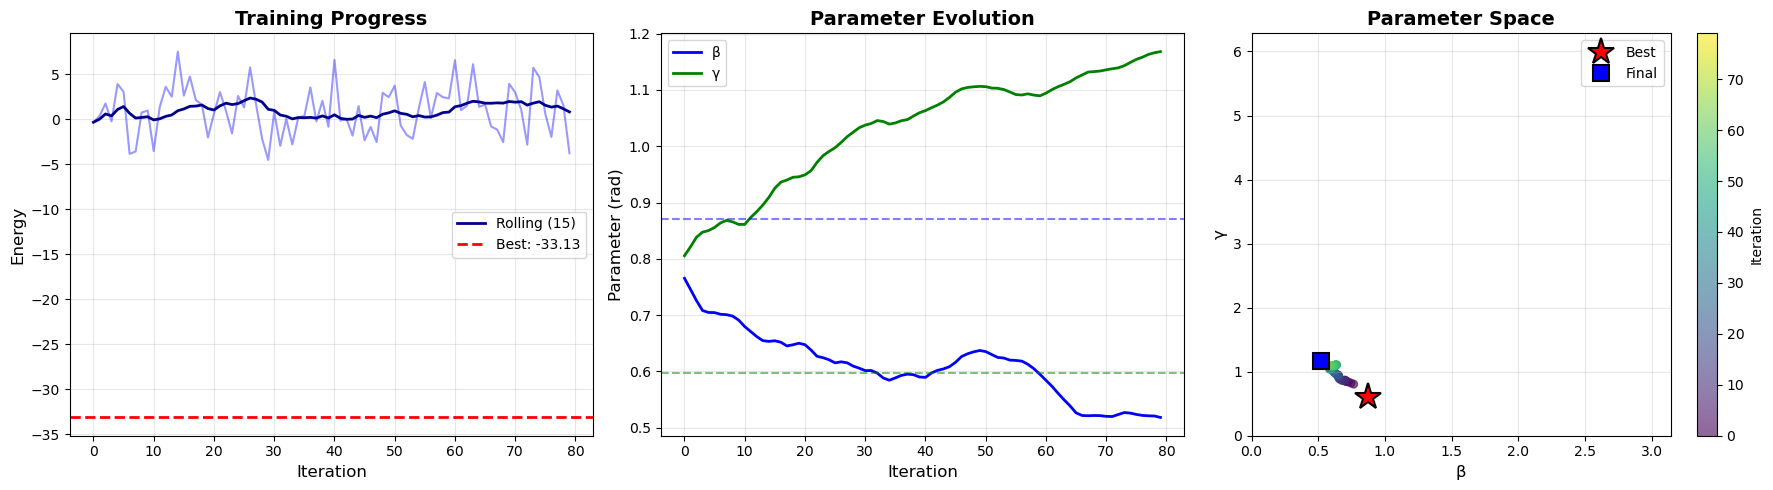


MULTI-START ULTRA-FAST PPO (3 starts)


Start 1/3 - β=0.785, γ=0.785

Ultra-Fast PPO for QAOA
Device: cpu
Samples/iter: 24, Epochs: 4
Training shots: 1024, Cache precision: 3
GAE: True, Adaptive LR: True

[  1] E_avg=   1.18 E_min= -26.11 E_best= -26.11 | β=0.805 γ=0.805 | σ=[0.59,0.59] | cache=0% lr=5.0e-03
[ 15] E_avg=   0.28 E_min= -29.20 E_best= -33.41 | β=0.949 γ=0.980 | σ=[0.67,0.54] | cache=0% lr=5.0e-03
[ 30] E_avg=  -2.09 E_min= -17.12 E_best= -40.68 | β=1.146 γ=1.177 | σ=[0.61,0.45] | cache=0% lr=5.0e-03
  Reducing LR: 5.00e-03 → 3.50e-03
  Reducing LR: 1.00e-02 → 7.00e-03
[ 45] E_avg=  -0.12 E_min= -12.27 E_best= -40.68 | β=1.245 γ=1.220 | σ=[0.64,0.46] | cache=0% lr=3.5e-03
  Reducing LR: 3.50e-03 → 2.45e-03
  Reducing LR: 7.00e-03 → 4.90e-03
[ 60] E_avg=  -1.91 E_min= -16.61 E_best= -40.68 | β=1.271 γ=1.223 | σ=[0.63,0.44] | cache=0% lr=2.4e-03

FINAL EVALUATION

Best sample: E=-40.3921±0.1178 β=2.3638 γ=0.0500
Final mean:  E=6.6540 β=1.2713 γ=1.2234

Cache stats: 1439 en

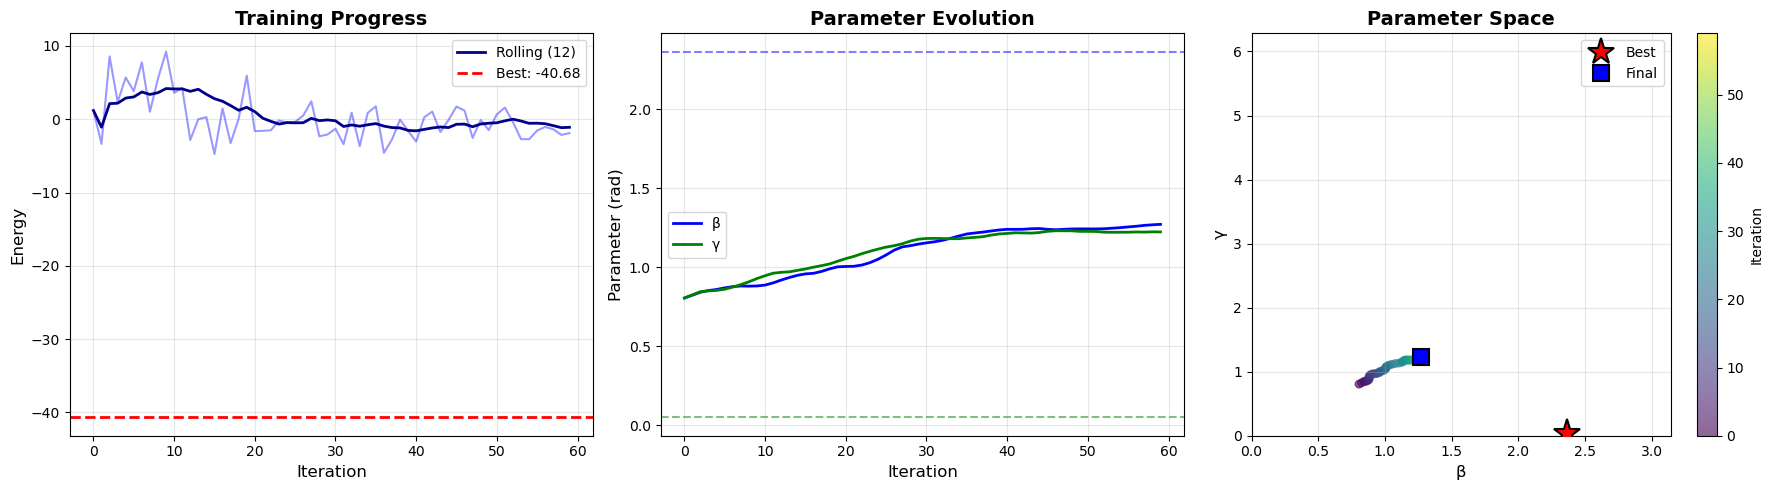


Start 1: E=-40.3921


Start 2/3 - β=1.571, γ=3.142

Ultra-Fast PPO for QAOA
Device: cpu
Samples/iter: 24, Epochs: 4
Training shots: 1024, Cache precision: 3
GAE: True, Adaptive LR: True

[  1] E_avg=  -1.08 E_min= -10.92 E_best= -10.92 | β=1.591 γ=3.122 | σ=[0.59,0.59] | cache=0% lr=5.0e-03
[ 15] E_avg=  -0.18 E_min= -13.06 E_best= -17.80 | β=1.736 γ=3.042 | σ=[0.64,0.59] | cache=0% lr=5.0e-03
  Reducing LR: 5.00e-03 → 3.50e-03
  Reducing LR: 1.00e-02 → 7.00e-03
[ 30] E_avg=  -1.54 E_min= -11.24 E_best= -17.80 | β=1.693 γ=3.058 | σ=[0.68,0.57] | cache=0% lr=3.5e-03
  Reducing LR: 3.50e-03 → 2.45e-03
  Reducing LR: 7.00e-03 → 4.90e-03
[ 45] E_avg=   0.17 E_min=  -8.49 E_best= -17.80 | β=1.708 γ=3.069 | σ=[0.72,0.62] | cache=0% lr=2.4e-03
  Reducing LR: 2.45e-03 → 1.71e-03
  Reducing LR: 4.90e-03 → 3.43e-03
[ 60] E_avg=  -1.16 E_min=  -8.93 E_best= -17.80 | β=1.665 γ=3.092 | σ=[0.76,0.63] | cache=0% lr=1.7e-03

FINAL EVALUATION

Best sample: E=-17.7809±0.3909 β=2.4003 γ=2.5882
Final mea

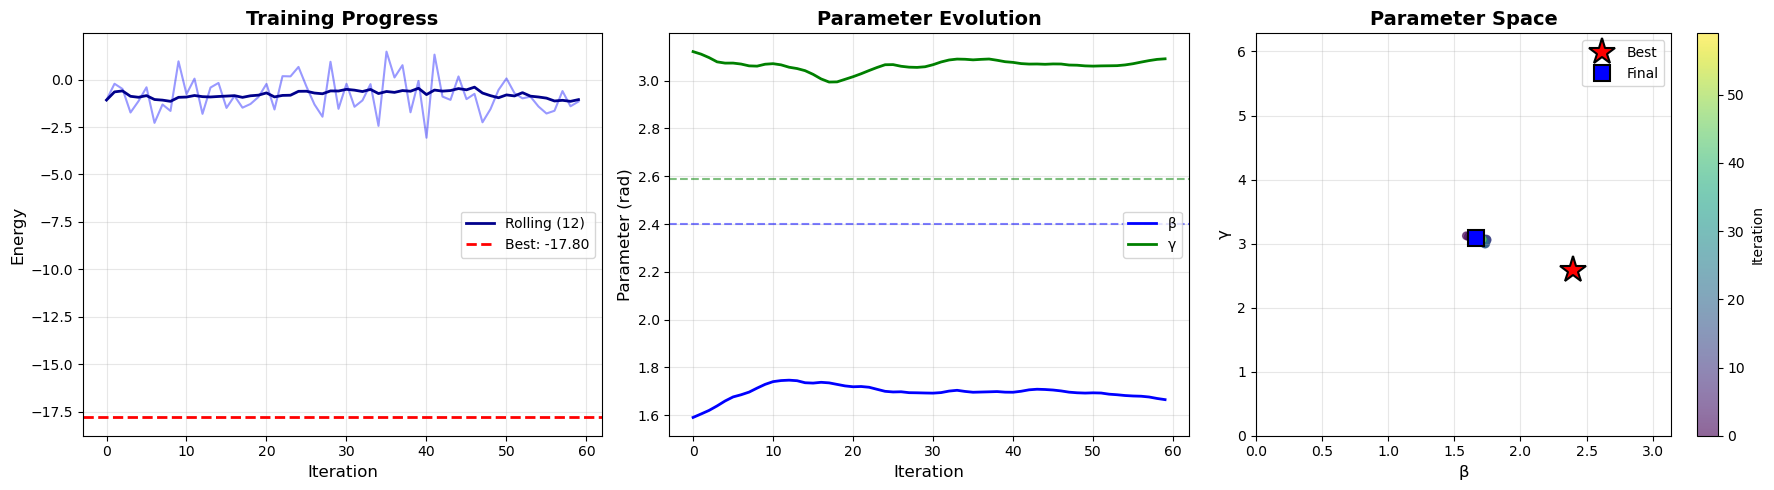


Start 2: E=-17.7809


Start 3/3 - β=1.047, γ=4.712

Ultra-Fast PPO for QAOA
Device: cpu
Samples/iter: 24, Epochs: 4
Training shots: 1024, Cache precision: 3
GAE: True, Adaptive LR: True

[  1] E_avg=   0.01 E_min= -14.63 E_best= -14.63 | β=1.067 γ=4.692 | σ=[0.59,0.59] | cache=0% lr=5.0e-03
[ 15] E_avg=  -0.97 E_min= -14.12 E_best= -16.85 | β=1.049 γ=4.721 | σ=[0.58,0.59] | cache=0% lr=5.0e-03
  Reducing LR: 5.00e-03 → 3.50e-03
  Reducing LR: 1.00e-02 → 7.00e-03
[ 30] E_avg=   1.40 E_min=  -8.53 E_best= -16.85 | β=1.048 γ=4.645 | σ=[0.59,0.57] | cache=0% lr=3.5e-03
  Reducing LR: 3.50e-03 → 2.45e-03
  Reducing LR: 7.00e-03 → 4.90e-03
[ 45] E_avg=   3.44 E_min= -14.53 E_best= -17.40 | β=1.087 γ=4.559 | σ=[0.57,0.59] | cache=0% lr=2.4e-03
  Reducing LR: 2.45e-03 → 1.71e-03
  Reducing LR: 4.90e-03 → 3.43e-03
[ 60] E_avg=   1.09 E_min= -12.66 E_best= -17.40 | β=1.119 γ=4.569 | σ=[0.61,0.60] | cache=0% lr=1.7e-03

FINAL EVALUATION

Best sample: E=-15.5111±0.0702 β=0.6137 γ=5.7179
Final mea

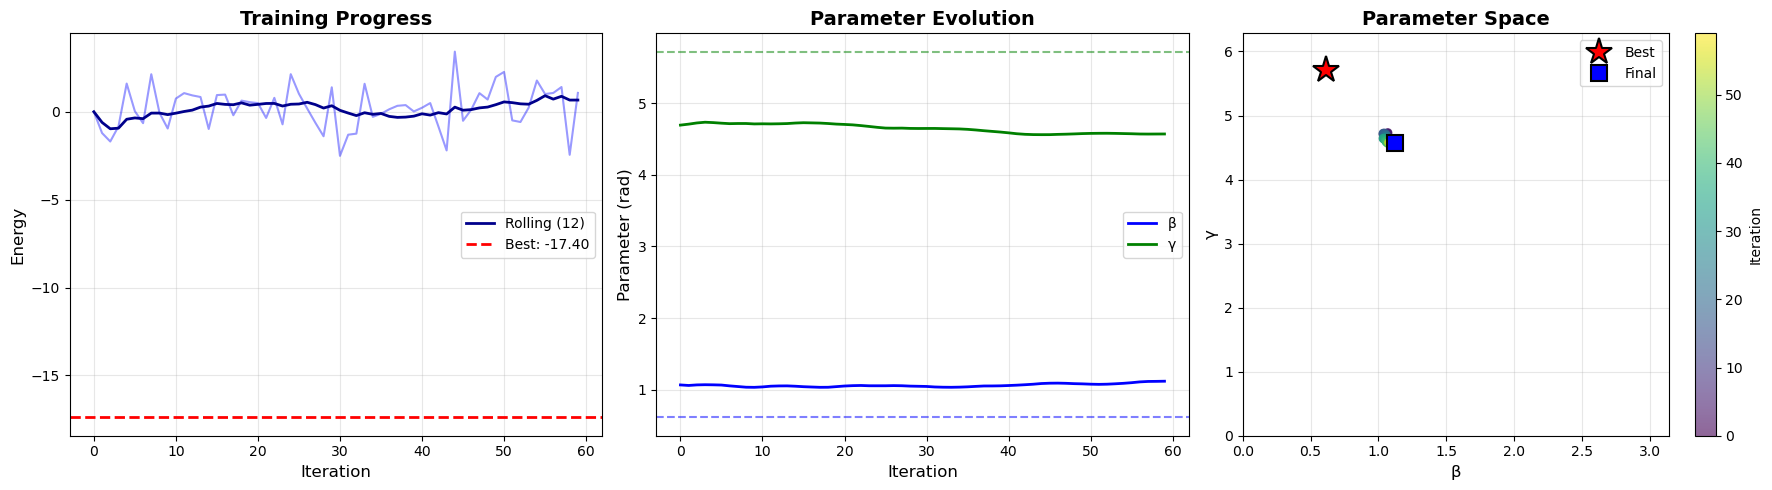


Start 3: E=-15.5111


BEST ACROSS ALL STARTS
Energy: -40.3921
β=2.363835 γ=0.049991


In [35]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import pickle
import hashlib

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ========================================
# ADVANCED CACHING SYSTEM
# ========================================

class PersistentCache:
    """
    Enhanced caching with:
    1. In-memory dict for fast access
    2. Coarser granularity (4 decimals instead of 6)
    3. Optional disk persistence
    4. LRU eviction for memory management
    """
    def __init__(self, max_size=10000, precision=4, use_disk=False, cache_file='qaoa_cache.pkl'):
        self.cache = OrderedDict()
        self.max_size = max_size
        self.precision = precision
        self.use_disk = use_disk
        self.cache_file = cache_file
        self.hits = 0
        self.misses = 0
        
        # Load existing cache from disk
        if use_disk:
            self._load_from_disk()
    
    def _make_key(self, beta, gamma):
        """Create cache key with specified precision"""
        return (round(beta, self.precision), round(gamma, self.precision))
    
    def get(self, beta, gamma):
        """Get cached value"""
        key = self._make_key(beta, gamma)
        if key in self.cache:
            self.hits += 1
            # Move to end (LRU)
            self.cache.move_to_end(key)
            return self.cache[key]
        self.misses += 1
        return None
    
    def set(self, beta, gamma, value):
        """Set cached value with LRU eviction"""
        key = self._make_key(beta, gamma)
        
        if key in self.cache:
            self.cache.move_to_end(key)
        else:
            if len(self.cache) >= self.max_size:
                # Remove oldest item
                self.cache.popitem(last=False)
        
        self.cache[key] = value
    
    def _load_from_disk(self):
        """Load cache from disk"""
        try:
            with open(self.cache_file, 'rb') as f:
                self.cache = pickle.load(f)
            print(f"Loaded {len(self.cache)} cached evaluations from {self.cache_file}")
        except FileNotFoundError:
            print(f"No cache file found. Starting fresh.")
    
    def save_to_disk(self):
        """Save cache to disk"""
        if self.use_disk:
            with open(self.cache_file, 'wb') as f:
                pickle.dump(self.cache, f)
            print(f"Saved {len(self.cache)} evaluations to {self.cache_file}")
    
    def stats(self):
        """Print cache statistics"""
        total = self.hits + self.misses
        hit_rate = 100 * self.hits / total if total > 0 else 0
        return {
            'size': len(self.cache),
            'hits': self.hits,
            'misses': self.misses,
            'hit_rate': hit_rate
        }


# ========================================
# GAE (Generalized Advantage Estimation)
# ========================================

def compute_gae(rewards, values, gamma=0.0, lmbda=0.95):
    """
    Compute Generalized Advantage Estimation (GAE).
    For single-step episodes (gamma=0), this simplifies but still provides variance reduction.
    
    Args:
        rewards: tensor of rewards [batch_size]
        values: tensor of value estimates [batch_size]
        gamma: discount factor (0 for single-step)
        lmbda: GAE lambda parameter (0.95 standard)
    
    Returns:
        advantages: GAE advantages
        returns: target values for critic
    """
    advantages = rewards - values  # TD residual
    
    # For single-step case, GAE reduces to TD residual
    # but we can still smooth across the batch
    if gamma > 0:
        # Standard GAE for multi-step (not used here but included for completeness)
        batch_size = len(rewards)
        gae = torch.zeros(batch_size, device=rewards.device)
        
        for t in reversed(range(batch_size)):
            if t == batch_size - 1:
                next_value = 0
            else:
                next_value = values[t + 1]
            
            delta = rewards[t] + gamma * next_value - values[t]
            gae[t] = delta + gamma * lmbda * (gae[t + 1] if t < batch_size - 1 else 0)
        
        advantages = gae
    
    returns = rewards  # For episodic/single-step, return = reward
    
    return advantages, returns


# ========================================
# Adaptive Learning Rate Scheduler
# ========================================

class AdaptiveLRScheduler:
    """
    Adaptive learning rate based on performance.
    Reduces LR if no improvement, increases if improving.
    """
    def __init__(self, optimizer, initial_lr, min_lr=1e-5, max_lr=1e-2, 
                 patience=10, factor=0.5, improvement_threshold=0.01):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.current_lr = initial_lr
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.patience = patience
        self.factor = factor
        self.improvement_threshold = improvement_threshold
        
        self.best_energy = float('inf')
        self.no_improve_count = 0
        self.history = []
    
    def step(self, energy):
        """Update learning rate based on energy"""
        self.history.append(energy)
        
        # Check for improvement
        if energy < self.best_energy - self.improvement_threshold:
            self.best_energy = energy
            self.no_improve_count = 0
            # Optionally increase LR slightly when improving
            # self.current_lr = min(self.current_lr * 1.05, self.max_lr)
        else:
            self.no_improve_count += 1
        
        # Reduce LR if stuck
        if self.no_improve_count >= self.patience:
            old_lr = self.current_lr
            self.current_lr = max(self.current_lr * self.factor, self.min_lr)
            self.no_improve_count = 0
            
            if self.current_lr < old_lr:
                print(f"  Reducing LR: {old_lr:.2e} → {self.current_lr:.2e}")
        
        # Update optimizer
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_lr
    
    def get_lr(self):
        return self.current_lr


# ========================================
# Optimized PPO Components
# ========================================

class QAOAPolicy(nn.Module):
    """Simple policy for 2D parameter space"""
    def __init__(self, init_mean=None, init_log_std=-0.5):
        super().__init__()
        if init_mean is None:
            init_mean = [np.pi/4, np.pi/4]
        
        self.mu = nn.Parameter(torch.tensor(init_mean, dtype=torch.float32))
        self.log_std = nn.Parameter(torch.ones(2) * init_log_std)
    
    def forward(self):
        mu = self.mu
        std = torch.exp(self.log_std).clamp(min=0.05, max=1.0)
        return mu, std
    
    def sample_action(self):
        mu, std = self.forward()
        dist = Normal(mu, std)
        action_raw = dist.sample()
        log_prob = dist.log_prob(action_raw).sum()
        
        # Project to bounds
        action = action_raw.clone()
        action[0] = torch.clamp(action[0], 0, np.pi)
        action[1] = torch.fmod(action[1], 2 * np.pi)
        action[1] = torch.where(action[1] < 0, action[1] + 2 * np.pi, action[1])
        
        return action, log_prob, action_raw
    
    def evaluate_actions(self, actions):
        mu, std = self.forward()
        dist = Normal(mu, std)
        log_probs = dist.log_prob(actions).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1)
        return log_probs, entropy


class QAOAValue(nn.Module):
    """Simple value network"""
    def __init__(self):
        super().__init__()
        self.baseline = nn.Parameter(torch.zeros(1))
    
    def forward(self, states):
        return self.baseline.expand(states.shape[0])


# ========================================
# ULTRA-FAST PPO TRAINER
# ========================================

def train_ppo_qaoa_fast(
    z_lin,
    z_pair,
    n_iterations=80,           # Reduced
    samples_per_iter=24,       # Reduced further
    n_epochs=4,                # Reduced
    policy_lr=5e-3,
    value_lr=1e-2,
    clip_epsilon=0.2,
    entropy_coef=0.03,
    value_coef=0.5,
    max_grad_norm=0.5,
    gamma=0.0,                 # Single-step
    lmbda=0.95,                # GAE lambda
    init_mean=None,
    init_log_std=-0.5,
    shots=1024,                # Lower shots for speed
    eval_shots=4096,
    eval_repeats=3,
    use_gae=True,
    use_adaptive_lr=True,
    cache_precision=3,         # Coarser caching (3 decimals)
    use_disk_cache=False,
    print_every=10
):
    """
    Ultra-fast PPO with:
    - Advanced caching (LRU, disk persistence)
    - GAE for better advantage estimation
    - Adaptive learning rates
    - Reduced samples/epochs for speed
    - Lower training shots
    """
    if init_mean is None:
        init_mean = [np.pi/4, np.pi/4]
    
    # Initialize
    policy = QAOAPolicy(init_mean=init_mean, init_log_std=init_log_std).to(DEVICE)
    value_net = QAOAValue().to(DEVICE)
    
    policy_optimizer = optim.Adam(policy.parameters(), lr=policy_lr)
    value_optimizer = optim.Adam(value_net.parameters(), lr=value_lr)
    
    # Advanced caching
    cache = PersistentCache(
        max_size=10000, 
        precision=cache_precision, 
        use_disk=use_disk_cache
    )
    
    # Adaptive LR
    if use_adaptive_lr:
        policy_scheduler = AdaptiveLRScheduler(
            policy_optimizer, policy_lr, 
            patience=15, factor=0.7
        )
        value_scheduler = AdaptiveLRScheduler(
            value_optimizer, value_lr,
            patience=15, factor=0.7
        )
    
    # Tracking
    energy_history = []
    param_history = []
    best_energy = float('inf')
    best_params = None
    
    print("="*70)
    print("Ultra-Fast PPO for QAOA")
    print("="*70)
    print(f"Device: {DEVICE}")
    print(f"Samples/iter: {samples_per_iter}, Epochs: {n_epochs}")
    print(f"Training shots: {shots}, Cache precision: {cache_precision}")
    print(f"GAE: {use_gae}, Adaptive LR: {use_adaptive_lr}")
    print("="*70 + "\n")
    
    for iteration in range(1, n_iterations + 1):
        # Collect batch
        actions_list = []
        actions_raw_list = []
        log_probs_list = []
        rewards_list = []
        
        for _ in range(samples_per_iter):
            with torch.no_grad():
                action, log_prob, action_raw = policy.sample_action()
            
            beta = action[0].item()
            gamma = action[1].item()
            params = (beta, gamma)
            
            # Try cache first
            energy = cache.get(beta, gamma)
            if energy is None:
                energy = evaluate_qaoa(params, z_lin, z_pair, shots=shots)
                cache.set(beta, gamma, energy)
            
            reward = -energy
            
            actions_list.append(action)
            actions_raw_list.append(action_raw)
            log_probs_list.append(log_prob)
            rewards_list.append(reward)
            
            if energy < best_energy:
                best_energy = energy
                best_params = params
        
        # Convert to tensors
        actions_raw = torch.stack(actions_raw_list).to(DEVICE)
        old_log_probs = torch.stack(log_probs_list).to(DEVICE)
        rewards = torch.tensor(rewards_list, dtype=torch.float32).to(DEVICE)
        
        # Compute advantages with GAE
        with torch.no_grad():
            values = value_net(actions_raw)
            
            if use_gae:
                advantages, returns = compute_gae(rewards, values, gamma, lmbda)
            else:
                advantages = rewards - values
                returns = rewards
            
            # Normalize advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # PPO update
        for epoch in range(n_epochs):
            # Policy
            new_log_probs, entropy = policy.evaluate_actions(actions_raw)
            ratio = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
            
            policy_loss = -torch.min(surr1, surr2).mean()
            entropy_loss = -entropy_coef * entropy.mean()
            total_policy_loss = policy_loss + entropy_loss
            
            policy_optimizer.zero_grad()
            total_policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy.parameters(), max_grad_norm)
            policy_optimizer.step()
            
            # Value
            values_pred = value_net(actions_raw)
            value_loss = value_coef * nn.MSELoss()(values_pred, returns)
            
            value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(value_net.parameters(), max_grad_norm)
            value_optimizer.step()
        
        # Logging
        avg_energy = -rewards.mean().item()
        min_energy = -rewards.max().item()
        
        energy_history.append(avg_energy)
        
        with torch.no_grad():
            mu, std = policy.forward()
            current_beta = torch.clamp(mu[0], 0, np.pi).item()
            current_gamma = torch.fmod(mu[1], 2 * np.pi).item()
            if current_gamma < 0:
                current_gamma += 2 * np.pi
            param_history.append([current_beta, current_gamma])
            current_std = std.cpu().numpy()
        
        # Adaptive LR
        if use_adaptive_lr:
            policy_scheduler.step(best_energy)
            value_scheduler.step(best_energy)
        
        if iteration % print_every == 0 or iteration == 1:
            cache_stats = cache.stats()
            lr_info = f"lr={policy_scheduler.get_lr():.1e}" if use_adaptive_lr else ""
            print(f"[{iteration:3d}] E_avg={avg_energy:7.2f} E_min={min_energy:7.2f} "
                  f"E_best={best_energy:7.2f} | β={current_beta:.3f} γ={current_gamma:.3f} | "
                  f"σ=[{current_std[0]:.2f},{current_std[1]:.2f}] | "
                  f"cache={cache_stats['hit_rate']:.0f}% {lr_info}")
    
    # Save cache
    cache.save_to_disk()
    
    # Final evaluation
    print("\n" + "="*70)
    print("FINAL EVALUATION")
    print("="*70)
    
    energies_best = []
    for _ in range(eval_repeats):
        e = evaluate_qaoa(best_params, z_lin, z_pair, shots=eval_shots)
        energies_best.append(e)
    final_energy_best = float(np.mean(energies_best))
    std_energy_best = float(np.std(energies_best))
    
    final_params = (current_beta, current_gamma)
    energies_mean = []
    for _ in range(eval_repeats):
        e = evaluate_qaoa(final_params, z_lin, z_pair, shots=eval_shots)
        energies_mean.append(e)
    final_energy_mean = float(np.mean(energies_mean))
    
    print(f"\nBest sample: E={final_energy_best:.4f}±{std_energy_best:.4f} "
          f"β={best_params[0]:.4f} γ={best_params[1]:.4f}")
    print(f"Final mean:  E={final_energy_mean:.4f} "
          f"β={final_params[0]:.4f} γ={final_params[1]:.4f}")
    
    cache_stats = cache.stats()
    print(f"\nCache stats: {cache_stats['size']} entries, "
          f"{cache_stats['hit_rate']:.1f}% hit rate")
    
    recommended = best_params if final_energy_best < final_energy_mean else final_params
    recommended_energy = min(final_energy_best, final_energy_mean)
    
    print(f"\n{'='*70}")
    print(f"RECOMMENDED: β={recommended[0]:.6f} γ={recommended[1]:.6f} E={recommended_energy:.4f}")
    print("="*70)
    
    plot_ppo_results(energy_history, param_history, best_params, final_params, best_energy)
    
    return {
        'policy': policy,
        'value_net': value_net,
        'best_params': best_params,
        'best_energy': final_energy_best,
        'final_params': final_params,
        'final_energy': final_energy_mean,
        'energy_history': energy_history,
        'param_history': param_history,
        'recommended_params': recommended,
        'recommended_energy': recommended_energy,
        'cache': cache
    }


def plot_ppo_results(energy_history, param_history, best_params, final_params, best_energy):
    """Visualize results"""
    param_history = np.array(param_history)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Energy
    ax1 = axes[0]
    ax1.plot(energy_history, alpha=0.4, color='blue')
    window = min(15, len(energy_history) // 5)
    if window > 1:
        rolling = pd.Series(energy_history).rolling(window=window, min_periods=1).mean()
        ax1.plot(rolling.values, linewidth=2, color='darkblue', label=f'Rolling ({window})')
    ax1.axhline(y=best_energy, color='red', linestyle='--', linewidth=2, 
                label=f'Best: {best_energy:.2f}')
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Energy', fontsize=12)
    ax1.set_title('Training Progress', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Parameters
    ax2 = axes[1]
    ax2.plot(param_history[:, 0], label='β', linewidth=2, color='blue')
    ax2.plot(param_history[:, 1], label='γ', linewidth=2, color='green')
    ax2.axhline(y=best_params[0], color='blue', linestyle='--', alpha=0.5)
    ax2.axhline(y=best_params[1], color='green', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Parameter (rad)', fontsize=12)
    ax2.set_title('Parameter Evolution', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Space
    ax3 = axes[2]
    iterations = np.arange(len(param_history))
    scatter = ax3.scatter(param_history[:, 0], param_history[:, 1],
                         c=iterations, cmap='viridis', s=30, alpha=0.6)
    ax3.plot(best_params[0], best_params[1], 'r*', markersize=20,
            label='Best', markeredgecolor='black', markeredgewidth=1.5, zorder=5)
    ax3.plot(final_params[0], final_params[1], 'bs', markersize=12,
            label='Final', markeredgecolor='black', markeredgewidth=1.5, zorder=5)
    ax3.set_xlabel('β', fontsize=12)
    ax3.set_ylabel('γ', fontsize=12)
    ax3.set_xlim(0, np.pi)
    ax3.set_ylim(0, 2*np.pi)
    ax3.set_title('Parameter Space', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Iteration')
    
    plt.tight_layout()
    plt.show()


def multi_start_ppo_fast(z_lin, z_pair, n_starts=3, **kwargs):
    """Multi-start with shared cache across runs"""
    print("\n" + "="*70)
    print(f"MULTI-START ULTRA-FAST PPO ({n_starts} starts)")
    print("="*70 + "\n")
    
    init_means = [
        [np.pi/4, np.pi/4],
        [np.pi/2, np.pi],
        [np.pi/3, 3*np.pi/2]
    ][:n_starts]
    
    all_results = []
    
    for i, init_mean in enumerate(init_means):
        print(f"\n{'='*70}")
        print(f"Start {i+1}/{n_starts} - β={init_mean[0]:.3f}, γ={init_mean[1]:.3f}")
        print("="*70 + "\n")
        
        result = train_ppo_qaoa_fast(
            z_lin, z_pair,
            init_mean=init_mean,
            print_every=15,
            **kwargs
        )
        all_results.append(result)
        print(f"\nStart {i+1}: E={result['recommended_energy']:.4f}\n")
    
    best_result = min(all_results, key=lambda x: x['recommended_energy'])
    
    print("\n" + "="*70)
    print("BEST ACROSS ALL STARTS")
    print("="*70)
    print(f"Energy: {best_result['recommended_energy']:.4f}")
    print(f"β={best_result['recommended_params'][0]:.6f} "
          f"γ={best_result['recommended_params'][1]:.6f}")
    print("="*70)
    
    return best_result, all_results


# ========================================
# Same setup as before
# ========================================
# 1. Build QUBO and Ising terms (exactly as before)
mu = np.array(mu_annual)
Sigma = np.array(sigma_annual)
v_levels = [0.0, 0.25, 0.5, 0.75, 1.0]
lam, A_onehot, B_budget = 0.5, 5.0, 1.0

h, J, idx_map = build_qubo_onehot(mu, Sigma, v_levels, lam, A_onehot, B_budget)
z_lin, z_pair, _ = qubo_to_ising_onehot(h, J)

# 2. Run the new ultra-fast PPO (same interface!)
result = train_ppo_qaoa_fast(
    z_lin, z_pair,  # ← Same inputs as before
    n_iterations=80,
    samples_per_iter=24,
    shots=1024,
    use_gae=True,
    use_adaptive_lr=True,
    cache_precision=3
)

# Or multi-start
best_result, all_results = multi_start_ppo_fast(
    z_lin, z_pair,  # ← Same inputs
    n_starts=3,
    n_iterations=60,
    shots=1024
)
